# Project 4 - Mc907/Mo651 - Mobile Robotics

### Student:
Luiz Eduardo Cartolano - RA: 183012

### Instructor:
Esther Luna Colombini

### Github Link:
[Project Repository](https://github.com/luizcartolano2/mc907-mobile-robotics)

### Youtube Link:
[Link to Video](https://youtu.be/uqNeEhWo0dA)

### Subject of this Work:
The general objective of this work is to implement a deep learning approach for solve the Visual Odometry problem.

### Goals:
1. Implement and evaluate a Deep VO strategy using images from the [AirSim](https://github.com/microsoft/AirSim) simulator.

In [1]:
import pandas as pd
import glob
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.autograd import Function
from torch.autograd import Variable
from torchvision import models
import torch.optim as optim
import math
from scipy.spatial.transform import Rotation as R
import matplotlib
import matplotlib.pyplot as plt

## Data Pre-Processing

### Clean wrong images

While upload images obtained from the AirSim simulator were noted that some of them had failure, so, we have to clean this data to avoid noise in the dataset.

In [ ]:
for dt in ['1','2','3','4','5','6']:
    path = 'dataset/'+'seq'+dt+'/'
    print("-------------------------------------------")
    print('|    '+path)
    all_images = glob.glob(path+'images'+'/*')
    df_poses = pd.read_csv(path+'poses.csv')[['ImageFile']].values
    for img in df_poses:
        if not (path+'images/'+img) in all_images:
            print('|        '+img[0])
    print("-------------------------------------------")          

### Images

In [2]:
def compute_rgb_mean(image_sequence):
    '''
        Compute the mean over each channel separately over a set of images.
        Parameters
        ----------
        image_sequence  :   np.ndarray
                        Array of shape ``(N, h, w, c)`` or ``(h, w, c)``
    '''
    if image_sequence.ndim == 4:
        _, h, w, c = image_sequence.shape
    if image_sequence.ndim == 3:
        h, w, c = image_sequence.shape
    # compute mean separately for each channel
    # somehow this expression is buggy, so we must do it manually
    # mode = image_sequence.mean((0, 1, 2))
    mean_r = image_sequence[..., 0].mean()
    mean_g = image_sequence[..., 1].mean()
    mean_b = image_sequence[..., 2].mean()
    mean = np.array([mean_r, mean_g, mean_b])
    return mean

def mean_normalize(images_vector):
    '''
        Normalize data to the range -1 to 1
    '''
    out_images = []
    
    N = len(images_vector)
    
    print('|    Mean-normalizing ...')

    mean_accumlator = np.zeros((3,), dtype=np.float32)

    # run over entire dataset to compute mean (fucking inefficient but I have other shit to do)
    for idx in range(N):
        img = images_vector[idx]
        mean_accumlator += compute_rgb_mean(img)

    mean_accumlator /= N
    print(f'|    Mean: {mean_accumlator}')
    
    for idx in range(N):
        img = images_vector[idx]
        out_images.append(img - mean_accumlator)
    
    print('|    Done')
    
    return out_images

In [3]:
def get_image(path,img_size=(256,144)):
    """
        Function to read an image from a given path.
        
        :param: path - image path
        :param: img_size - image size
        
        :return: img - numpy array with the images pixels (converted to grayscale and normalized)
        
    """
    # read image from path
    img = cv2.imread(path)

    # normalize image pixels
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return img

In [34]:
def load_images(img_dir, img_size=(256,144)):

    """
        Function to coordinate the load of all the images that are going to be used.
        
        :param: img_dir - path to the directory containing the images
        :param: img_size - image size
        
        :return: images_set - numpy array with all images at the set
        
    """
    print("----------------------------------------------------------------------")
    print ("|    Loading images from: ", img_dir)
    # create two empty list that are going to be used for save the images
    images= []
    images_set =[]
    # loop to read all the images of the directory
    for img in glob.glob(img_dir+'/*'):
        images.append(get_image(img,img_size))
    
    images = mean_normalize(images)
    
    # loop on the read images agrupping them two by two
    for i in range(len(images)-1):
        img1 = images[i]
        img2 = images[i+1]

        ret = np.empty((1, img_size[1], img_size[0], 6))
        ret[0, ..., 0:3] = img1
        ret[0, ..., 3:6] = img2
        
        assert (ret[0, ..., :3] == img1).all()
        assert (ret[0, ..., 3:6] == img2).all()
        
        images_set.append(ret)
        
    print("|    Images count : ",len(images_set))

    # reshape the array of all images
    images_set = np.reshape(images_set, (-1,144, 256, 6))
    print("----------------------------------------------------------------------")

    return images_set

### Pose

The next three functions are used to the Kitti Dataset poses.

In [ ]:
def isRotationMatrix(R):
    """ 
        Checks if a matrix is a valid rotation matrix referred from 
        https://www.learnopencv.com/rotation-matrix-to-euler-angles/
        
        :param: R - rotation matrix
        
        :return: True or False
        
    """
    # calc the transpose
    Rt = np.transpose(R)

    # check identity
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    
    return n < 1e-6

In [ ]:
def rotationMatrixToEulerAngles(R):
    """ 
        Calculates rotation matrix to euler angles
        referred from https://www.learnopencv.com/rotation-matrix-to-euler-angles
        
        :param: R - rotation matrix
        
        :return: rotation matrix for Euler angles
    """
    assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

In [ ]:
def getMatrices(all_poses):
    """
        Function to extract matrices from poses
        
        :param: all_poses - list with all poses from the sequence
        
        :return: all_matrices - list with all matrices obtained from the poses
    """
    all_matrices = []
    for i in range(len(all_poses)):
        #print("I: ",i)
        j = all_poses[i]
        #print("J:   ",j)
        p = np.array([j[3], j[7], j[11]])
        #print("P:   ", p)
        R = np.array([[j[0],j[1],j[2]],
                      [j[4],j[5],j[6]],
                      [j[8],j[9],j[10]]
                     ])
        #print("R:   ", R)
        angles = rotationMatrixToEulerAngles(R)
        #print("Angles: ",angles)
        matrix = np.concatenate((p,angles))
        #print("MATRIX: ", matrix)
        all_matrices.append(matrix)
    return all_matrices

In [ ]:
def load_kitti_images(pose_file):
    poses = []
    poses_set = []

    with open(pose_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            pose = np.fromstring(line, dtype=float, sep=' ')
            poses.append(pose)
    
    poses = getMatrices(poses)
    pose1 = poses[0]
    for i in range(len(poses)-1):
        pose2 = poses[i+1]
        finalpose = np.zeros(pose1)
        poses_set.append(finalpose)

    return poses_set

The next three functions are used for the poses obtained from the AirSim simulator.

In [5]:
def add_pi_to_poses(pose):
    '''Add Pi to every pose angle.'''
    pose += np.pi
    
    return pose

In [6]:
def quat_to_euler_angles(quat_matrix):
    # create a scipy object from the quaternion angles
    rot_mat = R.from_quat(quat_matrix)
    # convert the quaternion to euler (in degrees)
    euler_mat = rot_mat.as_euler('yxz', degrees=False)
    # convert from (-pi,pi) to (0,2pi)
    euler_convert = add_pi_to_poses(euler_mat)
    
    return euler_convert

In [7]:
def load_airsim_pose(pose_file):
    
    poses = []
    poses_set = []
    
    df_poses = pd.read_csv(pose_file)
    for index, row in df_poses.iterrows():
        # get the (x,y,z) positions of the camera
        position = np.array([row['POS_X'],row['POS_Y'],row['POS_Z']])
        # get the quaternions angles of the camera
        quat_matrix = np.array([row['Q_X'],row['Q_Y'], row['Q_Z'],row['Q_W']])
        # call the func that convert the quaternions to euler angles
        euler_matrix = quat_to_euler_angles(quat_matrix)
        # concatenate both position(x,y,z) and euler angles
        poses.append(np.concatenate((position,euler_matrix)))
        
    pose1 = poses[0]
    for i in range(len(poses)-1):
        pose2 = poses[i+1]

        pose_diff = np.subtract(pose2, pose1)
        pose_diff[4:] = np.arctan2(np.sin(pose_diff[4:]), np.cos(pose_diff[4:]))

        poses_set.append(pose_diff)
        
    return poses_set

In [8]:
def load_poses(pose_file, pose_format='airsim'):
    """
        Function to load the image poses.
        
        :param: pose_file - path to the pose file
        :param: pose_format - where the pose were obtained from (AirSim, VREP, Kitti, etc...)
        
        :return: pose_set - set of the poses for the sequence
    """
    print("----------------------------------------------------------------------")
    print ("|    Pose from: ",pose_file)
    
    if pose_format.lower() == 'kitti':
        poses_set = load_kitti_images(pose_file)
    elif pose_format.lower() == 'airsim':
        poses_set = load_airsim_pose(pose_file)
        
    print("|        Poses count: ",len(poses_set))
    print("----------------------------------------------------------------------")    
    return poses_set

### General

Function that acquire all data that will be used for training.

In [9]:
def VODataLoader(datapath,img_size=(256,144), test=False):
    if test:
        sequences = ['3']
    else:
        sequences = ['1','2','4','5','6']
        
    images_set = []
    odometry_set = []
    
    for sequence in sequences:
        dir_path = os.path.join(datapath,'seq'+sequence)
        image_path = os.path.join(dir_path,'images')
        pose_path = os.path.join(dir_path,'poses.csv')
        print("-----------------------------------------------------------------------")
        print("|Load from: ", dir_path)
        images_set.append(torch.FloatTensor(load_images(image_path,img_size)))
        odometry_set.append(torch.FloatTensor(load_poses(pose_path, 'AirSim')))
        print("-----------------------------------------------------------------------")
    
    print("---------------------------------------------------")
    print("|   Total Images: ", len(images_set))
    print("|   Total Odometry: ", len(odometry_set))
    print("---------------------------------------------------")    
    return images_set, odometry_set

In [38]:
X,y = VODataLoader(datapath='dataset', test=False)

-----------------------------------------------------------------------
|Load from:  dataset/seq1
----------------------------------------------------------------------
|    Loading images from:  dataset/seq1/images
|    Mean-normalizing ...
|    Mean: [0.3115534  0.29183614 0.27286035]
|    Done
|    Images count :  326
----------------------------------------------------------------------
----------------------------------------------------------------------
|    Pose from:  dataset/seq1/poses.csv
|        Poses count:  326
----------------------------------------------------------------------
-----------------------------------------------------------------------
-----------------------------------------------------------------------
|Load from:  dataset/seq2
----------------------------------------------------------------------
|    Loading images from:  dataset/seq2/images
|    Mean-normalizing ...
|    Mean: [0.2615339  0.24993458 0.2350733 ]
|    Done
|    Images count :  283
--

## Data Acquire

Converting lists containing tensors to tensors as per the batchsize (10)

In [40]:
X_train = [item for x in X for item in x]
Y_train = [item for a in y for item in a]

Some info about the training data

In [41]:
print("---------------------------------")
print("Details of X :")
print(type(X_train)) 
print(type(X_train[0]))
print(len(X_train)) 
print(X_train[0].size())
print("---------------------------------")
print("Details of y :")
print(type(Y_train))
print(type(Y_train[0]))
print(len(Y_train))
print(Y_train[0].size())
print("---------------------------------")

---------------------------------
Details of X :
<class 'list'>
<class 'torch.Tensor'>
1306
torch.Size([144, 256, 6])
---------------------------------
Details of y :
<class 'list'>
<class 'torch.Tensor'>
1306
torch.Size([6])
---------------------------------


In [42]:
X_stack = torch.stack(X_train)

In [43]:
y_stack = torch.stack(Y_train)

In [56]:
X_batch = X_stack.view(-1,1,6,144,256)
y_batch = y_stack.view(-1,1,6)

In [57]:
print("Details of X :")
print(X_batch.size())
print("Details of y :")
print(y_batch.size())

Details of X :
torch.Size([1306, 1, 6, 144, 256])
Details of y :
torch.Size([1306, 1, 6])


## Defining DeepVO model

In [46]:
class DeepVONet(nn.Module):
    def __init__(self):
        super(DeepVONet, self).__init__()

        self.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) #6 64
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d (64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d (128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)
        self.conv3_1 = nn.Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d (256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.conv4_1 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.conv5_1 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d (512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.lstm1 = nn.LSTMCell(2*6*1024, 100)
        self.lstm2 = nn.LSTMCell(100, 100)
        self.fc = nn.Linear(in_features=100, out_features=6)

        self.reset_hidden_states()

    def reset_hidden_states(self, size=1, zero=True):
        if zero == True:
            self.hx1 = Variable(torch.zeros(size, 100))
            self.cx1 = Variable(torch.zeros(size, 100))
            self.hx2 = Variable(torch.zeros(size, 100))
            self.cx2 = Variable(torch.zeros(size, 100))
        else:
            self.hx1 = Variable(self.hx1.data)
            self.cx1 = Variable(self.cx1.data)
            self.hx2 = Variable(self.hx2.data)
            self.cx2 = Variable(self.cx2.data)

        if next(self.parameters()).is_cuda == True:
            self.hx1 = self.hx1.cuda()
            self.cx1 = self.cx1.cuda()
            self.hx2 = self.hx2.cuda()
            self.cx2 = self.cx2.cuda()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv5_1(x)
        x = self.relu5_1(x)
        x = self.conv6(x)
        # print(x.size())
        x = x.view(x.size(0), 2 * 6 * 1024)
        #print(x.size())
        self.hx1, self.cx1 = self.lstm1(x, (self.hx1, self.cx1))
        x = self.hx1
        self.hx2, self.cx2 = self.lstm2(x, (self.hx2, self.cx2))
        x = self.hx2
        #print(x.size())
        x = self.fc(x)
        return x


Defines the training function

In [64]:
# creating model
model = DeepVONet()
print(model)

DeepVONet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu3): ReLU(inplace=True)
  (conv3_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (conv4_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4_1): ReLU(inplace=True)
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5_1): ReLU(inplace=True)
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm1): LSTMCell(12288, 10

In [65]:
# defining loss and optimizer to be used 
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=0.5)

First we load the pretrained weight of FlowNet ( CNN part ).

In [66]:
pre_trained = torch.load('flownets_EPE1.951.pth.tar',map_location=torch.device('cpu'))

In [67]:
update_dict = model.state_dict()

In [68]:
update_dict['conv1.weight'] = pre_trained['state_dict']['conv1.0.weight']
update_dict['conv1.bias'] = pre_trained['state_dict']['conv1.0.bias']
update_dict['conv2.weight'] = pre_trained['state_dict']['conv2.0.weight']
update_dict['conv2.bias'] = pre_trained['state_dict']['conv2.0.bias']
update_dict['conv3.weight'] = pre_trained['state_dict']['conv3.0.weight']
update_dict['conv3.bias'] = pre_trained['state_dict']['conv3.0.bias']
update_dict['conv4.weight'] = pre_trained['state_dict']['conv4.0.weight']
update_dict['conv4.bias'] = pre_trained['state_dict']['conv4.0.bias']
update_dict['conv4_1.weight'] = pre_trained['state_dict']['conv4_1.0.weight']
update_dict['conv4_1.bias'] = pre_trained['state_dict']['conv4_1.0.bias']
update_dict['conv5.weight'] = pre_trained['state_dict']['conv5.0.weight']
update_dict['conv5.bias'] = pre_trained['state_dict']['conv5.0.bias']
update_dict['conv5_1.weight'] = pre_trained['state_dict']['conv5_1.0.weight']
update_dict['conv5_1.bias'] = pre_trained['state_dict']['conv5_1.0.bias']
update_dict['conv6.weight'] = pre_trained['state_dict']['conv6.0.weight']
update_dict['conv6.bias'] = pre_trained['state_dict']['conv6.0.bias']

In [69]:
model.load_state_dict(update_dict)

<All keys matched successfully>

## Training Model

In [70]:
def training_model(model, train_num, X, y, epoch_num=25):
    start_time = time.time()
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        print("Epoch : ", epoch+1)
        for i in range(train_num):
            print("    Train num :", i+1)
            inputs = X[i]
            print("        Input Size: {}".format(inputs.size()))
            labels = y[i]
            print("        Labels: ",labels)
            
            model.zero_grad()
            model.reset_hidden_states()

            outputs = model(inputs)
            print("        Outputs: ",outputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('    Epoch : %d Loss: %.3f' %(epoch+1, running_loss/train_num))


    print('Finished Training')
    print ("Time taken in Training {0}".format((time.time() - start_time)))

Agora a gnt chora hehe

In [71]:
training_model(model,1306,X_batch,y_batch,5)

Epoch :  1
    Train num : 1
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 4.6534e-02, -9.3037e-02,  1.3868e-05,  7.8737e-02,  9.1435e-02,
         -5.7582e-02]], grad_fn=<AddmmBackward>)
    Train num : 2
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 4.7990e-02, -9.2970e-02, -1.0258e-05,  7.8670e-02,  9.1376e-02,
         -5.7529e-02]], grad_fn=<AddmmBackward>)
    Train num : 3
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[12.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 5.1649e-02, -9.2877e-02, -7.2190e-05,  7.8581e-02,  9.1293e-02,
         -5.7476e-02]], grad_fn=<AddmmBackward>)
    Train num : 4
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[16.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 0.0579, -0.0928, -0.0002,  0.0785,  0.0912, -0.057

    Train num : 34
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -3.4906e-02]])
        Outputs:  tensor([[ 0.8757, -0.0962, -0.0082,  0.0754,  0.0902, -0.0595]],
       grad_fn=<AddmmBackward>)
    Train num : 35
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -3.4906e-02]])
        Outputs:  tensor([[ 0.9127, -0.0964, -0.0085,  0.0753,  0.0901, -0.0596]],
       grad_fn=<AddmmBackward>)
    Train num : 36
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -3.4906e-02]])
        Outputs:  tensor([[ 0.9497, -0.0966, -0.0088,  0.0752,  0.0901, -0.0598]],
       grad_fn=<AddmmBackward>)
    Train num : 37
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2000e+01,

    Train num : 64
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.2443]])
        Outputs:  tensor([[ 2.1531, -0.1140, -0.0191,  0.0710,  0.0895, -0.0684]],
       grad_fn=<AddmmBackward>)
    Train num : 65
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.2443]])
        Outputs:  tensor([[ 2.2026, -0.1154, -0.0196,  0.0708,  0.0894, -0.0690]],
       grad_fn=<AddmmBackward>)
    Train num : 66
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.2618]])
        Outputs:  tensor([[ 2.2524, -0.1167, -0.0201,  0.0705,  0.0894, -0.0696]],
       grad_fn=<AddmmBackward>)
    Train num : 67
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.2793]])
        Outputs:  tensor([[ 2.3027, -0.1181, -0.0206,  

    Train num : 95
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.4189]])
        Outputs:  tensor([[ 4.5186, -0.2530, -0.0606,  0.0432,  0.0920, -0.1109]],
       grad_fn=<AddmmBackward>)
    Train num : 96
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.4363]])
        Outputs:  tensor([[ 4.6878, -0.2673, -0.0643,  0.0404,  0.0916, -0.1149]],
       grad_fn=<AddmmBackward>)
    Train num : 97
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.4363]])
        Outputs:  tensor([[ 4.8714, -0.2826, -0.0680,  0.0374,  0.0911, -0.1192]],
       grad_fn=<AddmmBackward>)
    Train num : 98
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.4538]])
        Outputs:  tensor([[ 5.0710, -0.2993, -0.0718,  

    Train num : 125
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.7330]])
        Outputs:  tensor([[ 2.3040e+01, -1.9384e+00, -1.1477e-01, -2.0934e-02,  1.0172e-01,
         -3.1189e-01]], grad_fn=<AddmmBackward>)
    Train num : 126
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.7505]])
        Outputs:  tensor([[ 2.4246e+01, -2.0515e+00, -1.1239e-01, -2.3734e-02,  9.9320e-02,
         -3.2172e-01]], grad_fn=<AddmmBackward>)
    Train num : 127
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.7505]])
        Outputs:  tensor([[25.4700, -2.1667, -0.1098, -0.0265,  0.0968, -0.3321]],
       grad_fn=<AddmmBackward>)
    Train num : 128
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.7679]])

    Train num : 154
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.9948]])
        Outputs:  tensor([[ 5.6357e+01, -6.2810e+00, -2.9177e-02, -2.3622e-03,  4.7369e-03,
         -6.2703e-01]], grad_fn=<AddmmBackward>)
    Train num : 155
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -1.0123]])
        Outputs:  tensor([[ 5.7171e+01, -6.4009e+00, -2.7403e-02, -7.4214e-04,  2.1034e-03,
         -6.3787e-01]], grad_fn=<AddmmBackward>)
    Train num : 156
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -1.0123]])
        Outputs:  tensor([[ 5.7960e+01, -6.5173e+00, -2.5717e-02,  7.7934e-04, -4.0324e-04,
         -6.4872e-01]], grad_fn=<AddmmBackward>)
    Train num : 157
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -

    Train num : 182
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -17.5746,   0.0000,   0.0000,   0.0000,  -1.3788]])
        Outputs:  tensor([[ 7.2043e+01, -1.0005e+01, -2.7211e-03,  1.5350e-02, -3.0699e-02,
         -9.6525e-01]], grad_fn=<AddmmBackward>)
    Train num : 183
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -17.5746,   0.0000,   0.0000,   0.0000,  -1.3963]])
        Outputs:  tensor([[ 7.2401e+01, -1.0210e+01, -2.3470e-03,  1.5357e-02, -3.0951e-02,
         -9.7827e-01]], grad_fn=<AddmmBackward>)
    Train num : 184
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -17.5746,   0.0000,   0.0000,   0.0000,  -1.4137]])
        Outputs:  tensor([[ 7.2750e+01, -1.0425e+01, -1.9936e-03,  1.5349e-02, -3.1170e-02,
         -9.9117e-01]], grad_fn=<AddmmBackward>)
    Train num : 185
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -

    Train num : 210
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5795, -53.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.6689e+01, -1.9543e+01,  2.0718e-03,  1.2452e-02, -2.7251e-02,
         -1.3050e+00]], grad_fn=<AddmmBackward>)
    Train num : 211
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5795, -53.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.6752e+01, -2.0518e+01,  2.2461e-03,  1.2587e-02, -2.7630e-02,
         -1.3136e+00]], grad_fn=<AddmmBackward>)
    Train num : 212
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5795, -53.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.6816e+01, -2.1527e+01,  2.4196e-03,  1.2725e-02, -2.8058e-02,
         -1.3220e+00]], grad_fn=<AddmmBackward>)
    Train num : 213
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5795, -

    Train num : 238
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5800, -104.3377,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.8561e+01, -5.7018e+01,  4.7312e-03,  1.3289e-02, -4.4329e-02,
         -1.4872e+00]], grad_fn=<AddmmBackward>)
    Train num : 239
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5800, -104.3377,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.8610e+01, -5.8723e+01,  4.6213e-03,  1.3061e-02, -4.4408e-02,
         -1.4913e+00]], grad_fn=<AddmmBackward>)
    Train num : 240
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5800, -104.3377,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.8652e+01, -6.0375e+01,  4.5022e-03,  1.2803e-02, -4.4345e-02,
         -1.4952e+00]], grad_fn=<AddmmBackward>)
    Train num : 241
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 265
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.6755]])
        Outputs:  tensor([[ 7.7608e+01, -9.7339e+01,  1.8630e-03,  3.9753e-03, -2.6274e-02,
         -1.5558e+00]], grad_fn=<AddmmBackward>)
    Train num : 266
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.6930]])
        Outputs:  tensor([[ 7.7477e+01, -9.8365e+01,  1.7611e-03,  3.6431e-03, -2.5336e-02,
         -1.5591e+00]], grad_fn=<AddmmBackward>)
    Train num : 267
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.7104]])
        Outputs:  tensor([[ 7.7349e+01, -9.9350e+01,  1.6617e-03,  3.3199e-03, -2.4412e-02,
         -1.5627e+00]], grad_fn=<AddmmBackward>)
    Train num : 268
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 292
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -2.1816]])
        Outputs:  tensor([[ 7.5128e+01, -1.1439e+02,  6.8765e-05, -1.5290e-03, -8.0236e-03,
         -1.7643e+00]], grad_fn=<AddmmBackward>)
    Train num : 293
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -2.2166]])
        Outputs:  tensor([[ 7.5072e+01, -1.1472e+02,  3.6299e-05, -1.6099e-03, -7.6251e-03,
         -1.7777e+00]], grad_fn=<AddmmBackward>)
    Train num : 294
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -2.2340]])
        Outputs:  tensor([[ 7.5017e+01, -1.1505e+02,  5.6573e-06, -1.6844e-03, -7.2427e-03,
         -1.7917e+00]], grad_fn=<AddmmBackward>)
    Train num : 295
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 319
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.5307]])
        Outputs:  tensor([[ 7.2841e+01, -1.2113e+02, -3.9073e-04, -2.4407e-03, -1.4056e-03,
         -2.1469e+00]], grad_fn=<AddmmBackward>)
    Train num : 320
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.5307]])
        Outputs:  tensor([[ 7.2757e+01, -1.2130e+02, -3.9569e-04, -2.4366e-03, -1.2816e-03,
         -2.1591e+00]], grad_fn=<AddmmBackward>)
    Train num : 321
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.5307]])
        Outputs:  tensor([[ 7.2677e+01, -1.2146e+02, -4.0012e-04, -2.4304e-03, -1.1637e-03,
         -2.1710e+00]], grad_fn=<AddmmBackward>)
    Train num : 322
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 348
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-17.0904,   2.5611,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[ 1.7633e+00,  2.7982e+00, -2.4544e-03,  6.0744e-02,  7.0110e-02,
          4.3987e-03]], grad_fn=<AddmmBackward>)
    Train num : 349
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-17.0904,   2.5611,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[ 1.6234e+00,  3.0073e+00, -2.1941e-03,  6.0655e-02,  6.9534e-02,
          8.5542e-03]], grad_fn=<AddmmBackward>)
    Train num : 350
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-20.9541,   1.5257,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[ 1.5004e+00,  3.1848e+00, -1.9607e-03,  6.0548e-02,  6.8966e-02,
          1.2040e-02]], grad_fn=<AddmmBackward>)
    Train num : 351
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-20.9541,  

    Train num : 376
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-33.3713,   2.6182,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-1.0592e+00,  5.9460e+00,  2.5652e-03,  5.7025e-02,  5.8311e-02,
          5.8021e-02]], grad_fn=<AddmmBackward>)
    Train num : 377
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-33.3713,   2.6182,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-1.2269e+00,  6.1356e+00,  2.9482e-03,  5.6817e-02,  5.7728e-02,
          6.1155e-02]], grad_fn=<AddmmBackward>)
    Train num : 378
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-33.3713,   2.6182,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-1.4146e+00,  6.3555e+00,  3.3777e-03,  5.6570e-02,  5.7105e-02,
          6.4785e-02]], grad_fn=<AddmmBackward>)
    Train num : 379
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-37.2977,  

    Train num : 405
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-57.6935,   1.9646,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-21.1076,  21.8110,   0.0590,   0.1576,  -0.0732,   0.3663]],
       grad_fn=<AddmmBackward>)
    Train num : 406
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-57.6935,   1.9646,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-21.8809,  21.6509,   0.0622,   0.1666,  -0.0788,   0.3688]],
       grad_fn=<AddmmBackward>)
    Train num : 407
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-57.6935,   1.9646,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-22.6361,  21.4488,   0.0655,   0.1745,  -0.0839,   0.3699]],
       grad_fn=<AddmmBackward>)
    Train num : 408
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-57.6935,   1.9646,   0.0000,   0.0000,   0.0000,  -0.3491]])
        O

    Train num : 435
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-74.1628,   2.8378,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.7612e+01,  1.5112e+01,  4.3060e-02,  1.6357e-01, -3.9856e-02,
          1.6194e-01]], grad_fn=<AddmmBackward>)
    Train num : 436
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-74.1628,   2.8378,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.8624e+01,  1.5126e+01,  3.9773e-02,  1.6271e-01, -3.4625e-02,
          1.5228e-01]], grad_fn=<AddmmBackward>)
    Train num : 437
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-78.0893,   2.0744,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.9565e+01,  1.5045e+01,  3.7052e-02,  1.6136e-01, -2.9859e-02,
          1.4149e-01]], grad_fn=<AddmmBackward>)
    Train num : 438
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-78.0893,  

    Train num : 463
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-106.2949,    0.8076,    0.0000,    0.0000,    0.0000,   -0.3665]])
        Outputs:  tensor([[-7.8822e+01,  7.7274e+00,  3.7700e-03,  1.1333e-01,  3.7829e-02,
         -1.2420e-01]], grad_fn=<AddmmBackward>)
    Train num : 464
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-106.2949,    0.8076,    0.0000,    0.0000,    0.0000,   -0.3665]])
        Outputs:  tensor([[-7.9819e+01,  7.5364e+00,  2.6135e-03,  1.1118e-01,  3.8202e-02,
         -1.3230e-01]], grad_fn=<AddmmBackward>)
    Train num : 465
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-106.2949,    0.8076,    0.0000,    0.0000,    0.0000,   -0.3665]])
        Outputs:  tensor([[-8.0779e+01,  7.3543e+00,  1.4900e-03,  1.0900e-01,  3.8496e-02,
         -1.4028e-01]], grad_fn=<AddmmBackward>)
    Train num : 466
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 490
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-142.2445,   -0.4180,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.0592e+02,  4.2251e+00, -2.2827e-02,  6.9708e-02,  3.7420e-02,
         -3.0707e-01]], grad_fn=<AddmmBackward>)
    Train num : 491
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-142.2445,   -0.4180,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.0718e+02,  4.0626e+00, -2.2709e-02,  6.7660e-02,  3.7316e-02,
         -3.1148e-01]], grad_fn=<AddmmBackward>)
    Train num : 492
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-146.2055,   -0.9748,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.0842e+02,  3.8985e+00, -2.2525e-02,  6.5591e-02,  3.7186e-02,
         -3.1574e-01]], grad_fn=<AddmmBackward>)
    Train num : 493
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 517
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-162.0734,   -2.9940,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.3668e+02, -1.9049e-01, -1.3568e-02,  2.5146e-02,  2.9444e-02,
         -3.9973e-01]], grad_fn=<AddmmBackward>)
    Train num : 518
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-162.0734,   -2.9940,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.3756e+02, -3.1131e-01, -1.3207e-02,  2.4129e-02,  2.8863e-02,
         -4.0337e-01]], grad_fn=<AddmmBackward>)
    Train num : 519
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-162.0734,   -2.9940,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.3840e+02, -4.2725e-01, -1.2850e-02,  2.3148e-02,  2.8277e-02,
         -4.0691e-01]], grad_fn=<AddmmBackward>)
    Train num : 520
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 544
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5236e+02,  8.8914e-02, -6.1323e-03,  8.6996e-03,  1.3842e-02,
         -4.5578e-01]], grad_fn=<AddmmBackward>)
    Train num : 545
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-168.9408,    0.6514,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5270e+02,  1.1658e-01, -5.9310e-03,  8.3549e-03,  1.3417e-02,
         -4.5676e-01]], grad_fn=<AddmmBackward>)
    Train num : 546
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-168.9408,    0.6514,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5310e+02,  1.3847e-01, -5.7412e-03,  8.0195e-03,  1.3032e-02,
         -4.5774e-01]], grad_fn=<AddmmBackward>)
    Train num : 547
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 571
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-186.3504,   -0.2616,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.6905e+02, -6.6215e-02, -2.7244e-03,  2.4804e-03,  7.8374e-03,
         -4.7912e-01]], grad_fn=<AddmmBackward>)
    Train num : 572
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-186.3505,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.6957e+02, -7.8062e-02, -2.6384e-03,  2.3592e-03,  7.6553e-03,
         -4.8110e-01]], grad_fn=<AddmmBackward>)
    Train num : 573
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-186.3505,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7006e+02, -1.2676e-02, -2.5601e-03,  2.2563e-03,  7.4556e-03,
         -4.8304e-01]], grad_fn=<AddmmBackward>)
    Train num : 574
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 598
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-191.9437,    7.7382,    0.0000,    0.0000,    0.0000,   -0.5585]])
        Outputs:  tensor([[-1.7926e+02,  3.0017e+00, -1.2224e-03,  8.0010e-04,  3.6166e-03,
         -5.1270e-01]], grad_fn=<AddmmBackward>)
    Train num : 599
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-191.9437,    7.7382,    0.0000,    0.0000,    0.0000,   -0.5585]])
        Outputs:  tensor([[-1.7958e+02,  3.1836e+00, -1.1901e-03,  7.7139e-04,  3.5109e-03,
         -5.1366e-01]], grad_fn=<AddmmBackward>)
    Train num : 600
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-191.9437,    7.7382,    0.0000,    0.0000,    0.0000,   -0.5759]])
        Outputs:  tensor([[-1.7988e+02,  3.3589e+00, -1.1580e-03,  7.4312e-04,  3.4083e-03,
         -5.1475e-01]], grad_fn=<AddmmBackward>)
    Train num : 601
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 625
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.0807e+00, -1.1802e+01, -4.1879e-01,  3.4906e-02, -5.8249e-07,
          8.7264e-02]])
        Outputs:  tensor([[ 0.7567, -0.4499,  0.0010,  0.0336,  0.0415, -0.0559]],
       grad_fn=<AddmmBackward>)
    Train num : 626
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.0807e+00, -1.1802e+01, -4.1879e-01,  3.4906e-02, -5.8249e-07,
          8.7264e-02]])
        Outputs:  tensor([[ 1.0870e+00, -5.7679e-01,  6.8695e-04,  3.3890e-02,  4.1592e-02,
         -5.7005e-02]], grad_fn=<AddmmBackward>)
    Train num : 627
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.0807e+00, -1.1802e+01, -4.1879e-01,  3.4906e-02,  7.2495e-07,
          1.0472e-01]])
        Outputs:  tensor([[ 1.2324e+00, -6.5447e-01,  3.9856e-04,  3.3965e-02,  4.1581e-02,
         -5.7722e-02]], grad_fn=<AddmmBackward>)
    Train num : 628
        Input Size: torch.Size(

    Train num : 652
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.7776e+00, -2.3772e+01, -8.3758e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 2.5348, -2.3994, -0.0088,  0.0324,  0.0418, -0.0758]],
       grad_fn=<AddmmBackward>)
    Train num : 653
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2200e+00, -2.3911e+01, -8.3758e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 2.6198, -2.5077, -0.0092,  0.0323,  0.0420, -0.0771]],
       grad_fn=<AddmmBackward>)
    Train num : 654
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2200e+00, -2.3911e+01, -8.3758e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 3.0264, -2.7075, -0.0096,  0.0325,  0.0423, -0.0793]],
       grad_fn=<AddmmBackward>)
    Train num : 655
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2200e

    Train num : 680
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-8.7154e-01, -8.3838e+01, -2.9315e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.4139e+01, -2.4145e+01, -9.3532e-02,  6.4208e-02,  1.8297e-02,
         -3.5507e-01]], grad_fn=<AddmmBackward>)
    Train num : 681
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-8.7154e-01, -8.3838e+01, -2.9315e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.4433e+01, -2.5621e+01, -1.1101e-01,  6.4924e-02,  1.4481e-02,
         -3.6785e-01]], grad_fn=<AddmmBackward>)
    Train num : 682
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.0013e+00, -8.7555e+01, -3.0614e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.4758e+01, -2.7215e+01, -1.3132e-01,  6.5951e-02,  1.0523e-02,
         -3.8094e-01]], grad_fn=<AddmmBackward>)
    Train num : 683
     

    Train num : 706
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 1.5678e+01, -5.8691e+01, -1.1218e+00,  5.3783e-02, -1.9931e-02,
         -3.1640e-01]], grad_fn=<AddmmBackward>)
    Train num : 707
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 1.5481e+01, -5.9735e+01, -1.1697e+00,  5.2836e-02, -2.0265e-02,
         -3.0487e-01]], grad_fn=<AddmmBackward>)
    Train num : 708
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 1.5280e+01, -6.0761e+01, -1.2172e+00,  5.1894e-02, -2.0619e-02,
         -2.9323e-01]], grad_fn=<AddmmBackward>)
    Train num : 709
     

    Train num : 732
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02, -3.9643e-07,
          3.8397e-01]])
        Outputs:  tensor([[ 1.0268e+01, -8.0590e+01, -2.2280e+00,  3.6268e-02, -2.9076e-02,
         -3.3073e-02]], grad_fn=<AddmmBackward>)
    Train num : 733
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02, -3.9643e-07,
          3.8397e-01]])
        Outputs:  tensor([[ 1.0064e+01, -8.1214e+01, -2.2626e+00,  3.5796e-02, -2.9199e-02,
         -2.3635e-02]], grad_fn=<AddmmBackward>)
    Train num : 734
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02, -3.9643e-07,
          3.8397e-01]])
        Outputs:  tensor([[ 9.8594e+00, -8.1821e+01, -2.2965e+00,  3.5325e-02, -2.9306e-02,
         -1.4349e-02]], grad_fn=<AddmmBackward>)
    Train num : 735
     

    Train num : 758
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4906e-02,  3.8591e-07,
          6.6323e-01]])
        Outputs:  tensor([[ 7.1466e+00, -9.4234e+01, -2.9797e+00,  3.4298e-02, -2.1430e-02,
          2.3940e-01]], grad_fn=<AddmmBackward>)
    Train num : 759
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4907e-02,  2.6839e-07,
          6.9813e-01]])
        Outputs:  tensor([[ 7.0426e+00, -9.4644e+01, -3.0023e+00,  3.4248e-02, -2.1116e-02,
          2.4992e-01]], grad_fn=<AddmmBackward>)
    Train num : 760
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4907e-02,  2.6839e-07,
          6.9813e-01]])
        Outputs:  tensor([[ 6.9311e+00, -9.5038e+01, -3.0243e+00,  3.4161e-02, -2.0835e-02,
          2.6069e-01]], grad_fn=<AddmmBackward>)
    Train num : 761
     

    Train num : 784
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.3570e+00, -1.1345e+02, -4.0111e+00,  3.4906e-02, -1.2356e-07,
          1.0472e+00]])
        Outputs:  tensor([[ 5.2437e+00, -1.0220e+02, -3.4266e+00,  3.6277e-02, -1.1574e-02,
          5.4189e-01]], grad_fn=<AddmmBackward>)
    Train num : 785
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.3570e+00, -1.1345e+02, -4.0111e+00,  3.4906e-02, -1.2356e-07,
          1.0472e+00]])
        Outputs:  tensor([[ 5.3510e+00, -1.0254e+02, -3.4435e+00,  3.7056e-02, -1.0652e-02,
          5.5520e-01]], grad_fn=<AddmmBackward>)
    Train num : 786
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4906e-02, -1.2356e-07,
          1.0472e+00]])
        Outputs:  tensor([[ 5.4379e+00, -1.0285e+02, -3.4595e+00,  3.7722e-02, -9.8284e-03,
          5.6829e-01]], grad_fn=<AddmmBackward>)
    Train num : 787
     

    Train num : 810
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4906e-02,  4.4340e-07,
          1.1694e+00]])
        Outputs:  tensor([[ 7.5877e+00, -1.0914e+02, -3.7884e+00,  4.7464e-02,  3.3357e-03,
          8.3382e-01]], grad_fn=<AddmmBackward>)
    Train num : 811
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4906e-02,  4.4340e-07,
          1.1694e+00]])
        Outputs:  tensor([[ 7.5661e+00, -1.0926e+02, -3.7962e+00,  4.7261e-02,  3.3371e-03,
          8.4255e-01]], grad_fn=<AddmmBackward>)
    Train num : 812
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4906e-02,  4.4340e-07,
          1.1694e+00]])
        Outputs:  tensor([[ 7.5426e+00, -1.0938e+02, -3.8037e+00,  4.7050e-02,  3.3295e-03,
          8.5108e-01]], grad_fn=<AddmmBackward>)
    Train num : 813
     

    Train num : 836
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7451e+01, -1.1828e+02, -4.5695e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.0638e+01, -1.1358e+02, -4.0337e+00,  5.6049e-02,  1.3794e-02,
          1.0562e+00]], grad_fn=<AddmmBackward>)
    Train num : 837
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7451e+01, -1.1828e+02, -4.5695e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.1076e+01, -1.1380e+02, -4.0496e+00,  5.7023e-02,  1.4811e-02,
          1.0658e+00]], grad_fn=<AddmmBackward>)
    Train num : 838
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7451e+01, -1.1828e+02, -4.5695e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.1499e+01, -1.1400e+02, -4.0653e+00,  5.7804e-02,  1.5684e-02,
          1.0752e+00]], grad_fn=<AddmmBackward>)
    Train num : 839
     

    Train num : 862
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.2794e+01, -1.1628e+02, -4.7091e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 1.6824e+01, -1.1364e+02, -4.2646e+00,  5.2339e-02,  1.8422e-02,
          1.2106e+00]], grad_fn=<AddmmBackward>)
    Train num : 863
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.2794e+01, -1.1628e+02, -4.7091e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 1.7045e+01, -1.1362e+02, -4.2718e+00,  5.2053e-02,  1.8597e-02,
          1.2147e+00]], grad_fn=<AddmmBackward>)
    Train num : 864
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.2794e+01, -1.1628e+02, -4.7091e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 1.7313e+01, -1.1362e+02, -4.2802e+00,  5.1831e-02,  1.8905e-02,
          1.2190e+00]], grad_fn=<AddmmBackward>)
    Train num : 865
     

    Train num : 888
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4907e-02, -7.4516e-08,
          1.5883e+00]])
        Outputs:  tensor([[ 2.7539e+01, -1.1622e+02, -4.5992e+00,  5.1125e-02,  2.5538e-02,
          1.3016e+00]], grad_fn=<AddmmBackward>)
    Train num : 889
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4907e-02,  3.5103e-07,
          1.6232e+00]])
        Outputs:  tensor([[ 2.7968e+01, -1.1632e+02, -4.6117e+00,  5.1172e-02,  2.5619e-02,
          1.3069e+00]], grad_fn=<AddmmBackward>)
    Train num : 890
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4907e-02, -1.6349e-07,
          1.6406e+00]])
        Outputs:  tensor([[ 2.8366e+01, -1.1641e+02, -4.6237e+00,  5.1219e-02,  2.5658e-02,
          1.3129e+00]], grad_fn=<AddmmBackward>)
    Train num : 891
     

    Train num : 914
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.5686e+01, -1.1948e+02, -6.2447e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 4.2967e+01, -1.1774e+02, -5.0615e+00,  4.9041e-02,  1.1017e-02,
          1.5166e+00]], grad_fn=<AddmmBackward>)
    Train num : 915
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.9678e+01, -1.1927e+02, -6.3843e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 4.4152e+01, -1.1772e+02, -5.0941e+00,  4.5646e-02,  9.1703e-03,
          1.5199e+00]], grad_fn=<AddmmBackward>)
    Train num : 916
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.9678e+01, -1.1927e+02, -6.3843e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 4.5437e+01, -1.1768e+02, -5.1273e+00,  4.1113e-02,  6.8281e-03,
          1.5213e+00]], grad_fn=<AddmmBackward>)
    Train num : 917
     

    Train num : 940
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0182e+02, -1.2159e+02, -7.5011e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.8033e+01, -1.1887e+02, -6.0125e+00,  3.3754e-02,  2.4346e-03,
          1.6791e+00]], grad_fn=<AddmmBackward>)
    Train num : 941
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0582e+02, -1.2138e+02, -7.6407e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.9199e+01, -1.1891e+02, -6.0579e+00,  3.3834e-02,  2.4490e-03,
          1.6842e+00]], grad_fn=<AddmmBackward>)
    Train num : 942
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0582e+02, -1.2138e+02, -7.6407e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 7.0455e+01, -1.1895e+02, -6.1063e+00,  3.3916e-02,  2.4686e-03,
          1.6892e+00]], grad_fn=<AddmmBackward>)
    Train num : 943
     

    Train num : 966
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9364e+02, -1.1678e+02, -1.0712e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.1707e+02, -1.1817e+02, -7.8260e+00,  3.4917e-02,  3.1838e-03,
          1.7741e+00]], grad_fn=<AddmmBackward>)
    Train num : 967
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9364e+02, -1.1678e+02, -1.0712e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.1987e+02, -1.1807e+02, -7.9273e+00,  3.4886e-02,  3.2098e-03,
          1.7765e+00]], grad_fn=<AddmmBackward>)
    Train num : 968
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9364e+02, -1.1678e+02, -1.0712e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.2259e+02, -1.1798e+02, -8.0262e+00,  3.4848e-02,  3.2263e-03,
          1.7787e+00]], grad_fn=<AddmmBackward>)
    Train num : 969
     

    Train num : 992
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5989e+01, -2.7904e-01, -4.1879e-01,  3.4907e-02,  8.0895e-07,
         -3.4907e-02]])
        Outputs:  tensor([[ 7.2189e+01, -3.3297e+01, -2.8740e+00,  4.5351e-02,  1.0187e-01,
          6.0290e-01]], grad_fn=<AddmmBackward>)
    Train num : 993
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5989e+01, -2.7904e-01, -4.1879e-01,  3.4907e-02,  8.0895e-07,
         -3.4907e-02]])
        Outputs:  tensor([[-9.4263, -0.5288,  0.1371,  0.0166,  0.0203, -0.0830]],
       grad_fn=<AddmmBackward>)
    Train num : 994
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5989e+01, -2.7904e-01, -4.1879e-01,  3.4907e-02,  8.0895e-07,
         -3.4907e-02]])
        Outputs:  tensor([[-7.9015, -1.6548,  0.0481,  0.0174,  0.0194, -0.0641]],
       grad_fn=<AddmmBackward>)
    Train num : 995
        Input Size: torch.Size([1, 6, 144, 256])
        

    Train num : 1019
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.9732e+01, -4.5963e+00, -1.9544e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 4.0612e+01, -1.3062e+01, -1.2803e+00,  2.4094e-02,  6.0201e-02,
          2.3223e-01]], grad_fn=<AddmmBackward>)
    Train num : 1020
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.9732e+01, -4.5963e+00, -1.9544e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 4.3190e+01, -1.3197e+01, -1.3278e+00,  2.4099e-02,  6.2046e-02,
          2.4059e-01]], grad_fn=<AddmmBackward>)
    Train num : 1021
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.3700e+01, -5.0835e+00, -2.0940e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 4.5505e+01, -1.3107e+01, -1.3590e+00,  2.3821e-02,  6.3395e-02,
          2.4503e-01]], grad_fn=<AddmmBackward>)
    Train num : 1022
 

    Train num : 1045
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0985e+02, -2.2840e+01, -3.7691e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 8.7868e+01, -1.8198e+01, -2.5895e+00, -5.4304e-03,  7.4926e-02,
          2.7777e-01]], grad_fn=<AddmmBackward>)
    Train num : 1046
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0985e+02, -2.2840e+01, -3.7691e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 8.9133e+01, -1.8751e+01, -2.6589e+00, -6.3067e-03,  7.5607e-02,
          2.7650e-01]], grad_fn=<AddmmBackward>)
    Train num : 1047
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0985e+02, -2.2840e+01, -3.7691e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 9.0297e+01, -1.9400e+01, -2.7313e+00, -6.9497e-03,  7.5962e-02,
          2.7622e-01]], grad_fn=<AddmmBackward>)
    Train num : 1048
 

    Train num : 1071
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5698e+02, -3.2657e+01, -5.4443e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.1718e+02, -2.8775e+01, -3.9739e+00,  9.8041e-04,  6.5786e-02,
          1.4617e-01]], grad_fn=<AddmmBackward>)
    Train num : 1072
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.6094e+02, -3.3144e+01, -5.5839e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.1853e+02, -2.8716e+01, -4.0101e+00,  7.7467e-04,  6.5901e-02,
          1.3571e-01]], grad_fn=<AddmmBackward>)
    Train num : 1073
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.6094e+02, -3.3144e+01, -5.5839e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.1996e+02, -2.8693e+01, -4.0503e+00,  6.4522e-04,  6.6018e-02,
          1.2576e-01]], grad_fn=<AddmmBackward>)
    Train num : 1074
 

    Train num : 1097
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.0856e+02, -3.8990e+01, -7.2591e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.5518e+02, -3.0853e+01, -5.2387e+00,  9.3092e-03,  5.1734e-02,
         -3.2057e-02]], grad_fn=<AddmmBackward>)
    Train num : 1098
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.0856e+02, -3.8990e+01, -7.2591e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.5695e+02, -3.1038e+01, -5.3013e+00,  9.7280e-03,  5.1044e-02,
         -3.6401e-02]], grad_fn=<AddmmBackward>)
    Train num : 1099
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.5876e+02, -3.1228e+01, -5.3649e+00,  1.0156e-02,  5.0397e-02,
         -4.0602e-02]], grad_fn=<AddmmBackward>)
    Train num : 1100
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:

    Train num : 1123
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.4671e+01,  4.6935e+00,  6.4953e+00,  1.7455e-02, -8.1551e-07,
          7.3105e-06]])
        Outputs:  tensor([[ 2.7337e+01, -3.3311e+00, -4.0351e-01,  3.4500e-02, -2.8840e-03,
         -6.4105e-02]], grad_fn=<AddmmBackward>)
    Train num : 1124
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8275e+01,  5.5714e+00,  7.1285e+00,  1.7455e-02, -8.1551e-07,
          7.3105e-06]])
        Outputs:  tensor([[ 2.9998e+01, -3.4283e+00, -4.1606e-01,  3.5498e-02, -4.4637e-03,
         -6.7385e-02]], grad_fn=<AddmmBackward>)
    Train num : 1125
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8275e+01,  5.5714e+00,  7.1285e+00,  1.7455e-02, -8.1551e-07,
          7.3105e-06]])
        Outputs:  tensor([[ 3.3010e+01, -3.5439e+00, -4.2706e-01,  3.6441e-02, -6.2497e-03,
         -7.0812e-02]], grad_fn=<AddmmBackward>)
    Train num : 1126
 

    Train num : 1149
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.7755e+01,  1.5187e+01,  1.1006e+01,  1.2217e-01, -5.7416e-07,
          1.9917e-05]])
        Outputs:  tensor([[ 5.9964e+01,  1.6933e+00,  1.5842e+00,  5.8126e-02, -1.9092e-02,
         -1.1374e-01]], grad_fn=<AddmmBackward>)
    Train num : 1150
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.7755e+01,  1.5187e+01,  1.1006e+01,  1.2217e-01, -5.7416e-07,
          1.9917e-05]])
        Outputs:  tensor([[ 6.0922e+01,  1.9642e+00,  1.7272e+00,  5.9551e-02, -1.9608e-02,
         -1.1333e-01]], grad_fn=<AddmmBackward>)
    Train num : 1151
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.2217e-01, -5.7416e-07,
          1.9917e-05]])
        Outputs:  tensor([[ 6.1753e+01,  2.2950e+00,  1.8751e+00,  6.1059e-02, -2.0074e-02,
         -1.1334e-01]], grad_fn=<AddmmBackward>)
    Train num : 1152
 

    Train num : 1175
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.3958e+01,  9.3623e+00,  5.3756e+00,  9.1510e-02, -2.0842e-02,
         -2.0216e-02]], grad_fn=<AddmmBackward>)
    Train num : 1176
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.4211e+01,  9.5654e+00,  5.4980e+00,  9.2565e-02, -2.0629e-02,
         -1.4451e-02]], grad_fn=<AddmmBackward>)
    Train num : 1177
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.4457e+01,  9.7627e+00,  5.6187e+00,  9.3597e-02, -2.0418e-02,
         -8.7162e-03]], grad_fn=<AddmmBackward>)
    Train num : 1178
 

    Train num : 1201
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.4397e+01, 1.7838e+01, 1.1415e+01, 1.3963e-01, 3.7525e-07, 5.4107e-01]])
        Outputs:  tensor([[ 7.8763e+01,  1.3403e+01,  7.9628e+00,  1.1273e-01, -1.5235e-02,
          1.2412e-01]], grad_fn=<AddmmBackward>)
    Train num : 1202
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.4397e+01, 1.7838e+01, 1.1415e+01, 1.3963e-01, 9.2685e-07, 5.5852e-01]])
        Outputs:  tensor([[ 7.8902e+01,  1.3525e+01,  8.0394e+00,  1.1332e-01, -1.5024e-02,
          1.3207e-01]], grad_fn=<AddmmBackward>)
    Train num : 1203
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.4397e+01,  1.7838e+01,  1.1415e+01,  1.3963e-01, -3.1063e-07,
          5.9343e-01]])
        Outputs:  tensor([[ 7.9035e+01,  1.3643e+01,  8.1140e+00,  1.1390e-01, -1.4812e-02,
          1.4038e-01]], grad_fn=<AddmmBackward>)
    Train num : 1204
        Input Size: torch.Size(

    Train num : 1227
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 6.0636e-07, 1.3265e+00]])
        Outputs:  tensor([[ 8.2085e+01,  1.6780e+01,  9.5621e+00,  1.3075e-01, -1.0531e-02,
          4.1723e-01]], grad_fn=<AddmmBackward>)
    Train num : 1228
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -5.1306e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 8.2170e+01,  1.6882e+01,  9.6057e+00,  1.3131e-01, -1.0369e-02,
          4.3610e-01]], grad_fn=<AddmmBackward>)
    Train num : 1229
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.1651e-06,
          1.4312e+00]])
        Outputs:  tensor([[ 8.2251e+01,  1.6981e+01,  9.6479e+00,  1.3186e-01, -1.0207e-02,
          4.5573e-01]], grad_fn=<AddmmBackward>)
    Train num : 1230
        Input Si

    Train num : 1253
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 8.9426e-08, 2.6878e+00]])
        Outputs:  tensor([[ 8.3361e+01,  1.8550e+01,  1.0364e+01,  1.4113e-01, -6.8781e-03,
          1.1182e+00]], grad_fn=<AddmmBackward>)
    Train num : 1254
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -8.0950e-07,
          2.7402e+00]])
        Outputs:  tensor([[ 8.3384e+01,  1.8591e+01,  1.0384e+01,  1.4139e-01, -6.7645e-03,
          1.1523e+00]], grad_fn=<AddmmBackward>)
    Train num : 1255
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 4.0177e-07, 2.7925e+00]])
        Outputs:  tensor([[ 8.3407e+01,  1.8630e+01,  1.0404e+01,  1.4164e-01, -6.6528e-03,
          1.1868e+00]], grad_fn=<AddmmBackward>)
    Train num : 1256
        Input Size: torch.Size(

    Train num : 1279
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1260e+01,  1.9827e+01,  1.1643e+01,  1.5708e-01, -4.0379e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 8.3400e+01,  1.9422e+01,  1.0731e+01,  1.4601e-01, -4.2578e-03,
          1.6112e-01]], grad_fn=<AddmmBackward>)
    Train num : 1280
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1260e+01,  1.9827e+01,  1.1643e+01,  1.5708e-01, -4.0379e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 8.3234e+01,  1.9457e+01,  1.0734e+01,  1.4611e-01, -4.0916e-03,
          9.9899e-02]], grad_fn=<AddmmBackward>)
    Train num : 1281
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.8892e+01,  1.6605e+01,  1.1761e+01,  1.5708e-01, -4.0379e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 8.3044e+01,  1.9466e+01,  1.0737e+01,  1.4617e-01, -3.9196e-03,
          4.0323e-02]], grad_fn=<AddmmBackward>)
    Train num : 1282
 

    Train num : 1305
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.0060e+01,  1.0286e+01,  1.0946e+01,  3.6652e-01,  4.6134e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.3743e+01,  1.5634e+01,  1.0328e+01,  1.9077e-01,  5.7404e-04,
         -9.5165e-01]], grad_fn=<AddmmBackward>)
    Train num : 1306
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.0060e+01,  1.0286e+01,  1.0946e+01,  3.6652e-01,  4.6134e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.3422e+01,  1.5431e+01,  1.0301e+01,  1.9372e-01,  6.5817e-04,
         -9.7868e-01]], grad_fn=<AddmmBackward>)
    Epoch : 1 Loss: 292.076
Epoch :  2
    Train num : 1
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 7.3115e+01,  1.5234e+01,  1.0276e+01,  1.9658e-01,  7.3352e-04,
         -1.0050e+00]], grad_fn=<AddmmBackward>)
    Train num : 2
        Input Size: torch.Size(

    Train num : 30
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.7454e-02]])
        Outputs:  tensor([[ 4.9251e+01,  5.9910e+00,  5.6280e+00,  1.1719e-01,  6.0403e-03,
         -5.6496e-01]], grad_fn=<AddmmBackward>)
    Train num : 31
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.7454e-02]])
        Outputs:  tensor([[ 4.9437e+01,  5.7870e+00,  5.5671e+00,  1.1602e-01,  5.7143e-03,
         -5.5802e-01]], grad_fn=<AddmmBackward>)
    Train num : 32
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -3.4906e-02]])
        Outputs:  tensor([[ 4.9560e+01,  5.5761e+00,  5.4998e+00,  1.1474e-01,  5.4137e-03,
         -5.5053e-01]], grad_fn=<AddmmBackward>)
    Train num : 33
        I

    Train num : 57
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.0000,  0.0000, -0.1745]])
        Outputs:  tensor([[ 5.5421e+01,  1.8661e+00,  4.2002e+00,  8.8590e-02, -1.6961e-04,
         -4.2245e-01]], grad_fn=<AddmmBackward>)
    Train num : 58
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.0000,  0.0000, -0.1745]])
        Outputs:  tensor([[ 5.5538e+01,  1.7549e+00,  4.1437e+00,  8.7445e-02, -2.6794e-04,
         -4.1827e-01]], grad_fn=<AddmmBackward>)
    Train num : 59
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.1745]])
        Outputs:  tensor([[ 5.5647e+01,  1.6482e+00,  4.0876e+00,  8.6306e-02, -3.5886e-04,
         -4.1422e-01]], grad_fn=<AddmmBackward>)
    Train num : 60
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.000

    Train num : 86
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.3665]])
        Outputs:  tensor([[ 6.0619e+01, -6.9419e-01,  2.8405e+00,  5.9450e-02, -1.7578e-03,
         -3.7051e-01]], grad_fn=<AddmmBackward>)
    Train num : 87
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.3840]])
        Outputs:  tensor([[ 6.1024e+01, -8.6110e-01,  2.7999e+00,  5.8520e-02, -1.8084e-03,
         -3.6993e-01]], grad_fn=<AddmmBackward>)
    Train num : 88
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.3840]])
        Outputs:  tensor([[ 6.1454e+01, -1.0392e+00,  2.7592e+00,  5.7583e-02, -1.8544e-03,
         -3.6944e-01]], grad_fn=<AddmmBackward>)
    Train num : 89
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.000

    Train num : 115
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.6109]])
        Outputs:  tensor([[ 6.9554e+01, -4.6130e+00,  1.7412e+00,  3.4248e-02, -9.1403e-04,
         -3.9774e-01]], grad_fn=<AddmmBackward>)
    Train num : 116
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.6283]])
        Outputs:  tensor([[ 6.9777e+01, -4.7186e+00,  1.7087e+00,  3.3515e-02, -8.5618e-04,
         -4.0059e-01]], grad_fn=<AddmmBackward>)
    Train num : 117
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.6458]])
        Outputs:  tensor([[ 6.9992e+01, -4.8189e+00,  1.6767e+00,  3.2796e-02, -7.9861e-04,
         -4.0362e-01]], grad_fn=<AddmmBackward>)
    Train num : 118
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0

    Train num : 143
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.9250]])
        Outputs:  tensor([[ 7.4366e+01, -7.4748e+00,  9.6270e-01,  1.7843e-02,  1.2578e-04,
         -5.2208e-01]], grad_fn=<AddmmBackward>)
    Train num : 144
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.9250]])
        Outputs:  tensor([[ 7.4499e+01, -7.5663e+00,  9.4098e-01,  1.7409e-02,  1.4391e-04,
         -5.2819e-01]], grad_fn=<AddmmBackward>)
    Train num : 145
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.9425]])
        Outputs:  tensor([[ 7.4628e+01, -7.6530e+00,  9.1989e-01,  1.6987e-02,  1.6249e-04,
         -5.3438e-01]], grad_fn=<AddmmBackward>)
    Train num : 146
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -

    Train num : 171
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.2322, -13.6481,   0.0000,   0.0000,   0.0000,  -1.2392]])
        Outputs:  tensor([[ 7.7423e+01, -9.4206e+00,  5.1321e-01,  8.5459e-03,  4.5176e-04,
         -7.2199e-01]], grad_fn=<AddmmBackward>)
    Train num : 172
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.2322, -13.6481,   0.0000,   0.0000,   0.0000,  -1.2566]])
        Outputs:  tensor([[ 7.7501e+01, -9.5894e+00,  4.9348e-01,  8.3230e-03,  3.7280e-04,
         -7.2931e-01]], grad_fn=<AddmmBackward>)
    Train num : 173
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.2322, -13.6481,   0.0000,   0.0000,   0.0000,  -1.2915]])
        Outputs:  tensor([[ 7.7575e+01, -9.7519e+00,  4.7443e-01,  8.1090e-03,  2.9503e-04,
         -7.3692e-01]], grad_fn=<AddmmBackward>)
    Train num : 174
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.2322, -

    Train num : 199
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.7188, -25.4302,   0.0000,   0.0000,   0.0000,  -1.6057]])
        Outputs:  tensor([[ 7.8273e+01, -1.4806e+01,  1.7292e-02,  5.3584e-03, -4.1121e-03,
         -9.5906e-01]], grad_fn=<AddmmBackward>)
    Train num : 200
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5793, -29.4277,   0.0000,   0.0000,   0.0000,  -1.6057]])
        Outputs:  tensor([[ 7.8130e+01, -1.5280e+01, -1.8069e-02,  5.4928e-03, -4.8439e-03,
         -9.6336e-01]], grad_fn=<AddmmBackward>)
    Train num : 201
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5793, -29.4277,   0.0000,   0.0000,   0.0000,  -1.5882]])
        Outputs:  tensor([[ 7.7963e+01, -1.5884e+01, -6.2395e-02,  5.6925e-03, -5.8158e-03,
         -9.6563e-01]], grad_fn=<AddmmBackward>)
    Train num : 202
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5793, -

    Train num : 227
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5798, -85.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.5075e+01, -4.2949e+01, -1.2047e+00,  7.0111e-03, -3.2105e-02,
         -9.7922e-01]], grad_fn=<AddmmBackward>)
    Train num : 228
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5798, -89.1578,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.5137e+01, -4.4247e+01, -1.2158e+00,  6.7927e-03, -3.2124e-02,
         -9.8639e-01]], grad_fn=<AddmmBackward>)
    Train num : 229
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5798, -89.1578,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.5207e+01, -4.5622e+01, -1.2266e+00,  6.5469e-03, -3.2087e-02,
         -9.9370e-01]], grad_fn=<AddmmBackward>)
    Train num : 230
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5799, -

    Train num : 255
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.7656e+01, -8.4146e+01, -1.0096e+00,  7.7034e-04, -2.1262e-02,
         -1.2347e+00]], grad_fn=<AddmmBackward>)
    Train num : 256
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.7662e+01, -8.5576e+01, -9.9071e-01,  6.3417e-04, -2.0748e-02,
         -1.2434e+00]], grad_fn=<AddmmBackward>)
    Train num : 257
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.5882]])
        Outputs:  tensor([[ 7.7628e+01, -8.6953e+01, -9.7140e-01,  5.0690e-04, -2.0234e-02,
         -1.2519e+00]], grad_fn=<AddmmBackward>)
    Train num : 258
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 282
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.9373]])
        Outputs:  tensor([[ 7.6020e+01, -1.0894e+02, -4.9936e-01, -7.6561e-04, -9.4901e-03,
         -1.5133e+00]], grad_fn=<AddmmBackward>)
    Train num : 283
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.9548]])
        Outputs:  tensor([[ 7.5979e+01, -1.0947e+02, -4.8397e-01, -7.6381e-04, -9.1757e-03,
         -1.5256e+00]], grad_fn=<AddmmBackward>)
    Train num : 284
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.9722]])
        Outputs:  tensor([[ 7.5930e+01, -1.0997e+02, -4.6916e-01, -7.6517e-04, -8.8722e-03,
         -1.5380e+00]], grad_fn=<AddmmBackward>)
    Train num : 285
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 309
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.4434]])
        Outputs:  tensor([[ 7.4119e+01, -1.1800e+02, -2.1541e-01, -7.1873e-04, -3.7758e-03,
         -1.9235e+00]], grad_fn=<AddmmBackward>)
    Train num : 310
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.4434]])
        Outputs:  tensor([[ 7.3996e+01, -1.1825e+02, -2.0895e-01, -7.1353e-04, -3.6476e-03,
         -1.9386e+00]], grad_fn=<AddmmBackward>)
    Train num : 311
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.4434]])
        Outputs:  tensor([[ 7.3876e+01, -1.1850e+02, -2.0266e-01, -7.0786e-04, -3.5234e-03,
         -1.9531e+00]], grad_fn=<AddmmBackward>)
    Train num : 312
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 337
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000, -0.2094]])
        Outputs:  tensor([[ 2.2248e+01, -4.0890e+01, -9.9471e-02,  5.3559e-03,  5.0432e-03,
         -7.0171e-01]], grad_fn=<AddmmBackward>)
    Train num : 338
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000, -0.2269]])
        Outputs:  tensor([[-0.7118, -2.9783, -0.0909,  0.0095,  0.0115, -0.0196]],
       grad_fn=<AddmmBackward>)
    Train num : 339
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000, -0.2618]])
        Outputs:  tensor([[-1.0475, -2.7061, -0.1000,  0.0097,  0.0112, -0.0105]],
       grad_fn=<AddmmBackward>)
    Train num : 340
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000, -0.2793]])
        Outputs:  tensor(

    Train num : 368
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-28.6814,  -0.5450,   0.0000,   0.0000,   0.0000,  -0.3316]])
        Outputs:  tensor([[-9.8763e+00,  3.4766e+00, -3.4556e-01,  8.3458e-03,  9.0019e-03,
          2.0836e-01]], grad_fn=<AddmmBackward>)
    Train num : 369
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-28.6814,  -0.5450,   0.0000,   0.0000,   0.0000,  -0.3316]])
        Outputs:  tensor([[-1.0232e+01,  3.5301e+00, -3.6069e-01,  8.2577e-03,  8.8488e-03,
          2.1590e-01]], grad_fn=<AddmmBackward>)
    Train num : 370
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-28.6814,  -0.5450,   0.0000,   0.0000,   0.0000,  -0.3316]])
        Outputs:  tensor([[-1.0591e+01,  3.5798e+00, -3.7605e-01,  8.1663e-03,  8.6964e-03,
          2.2344e-01]], grad_fn=<AddmmBackward>)
    Train num : 371
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-28.6814,  

    Train num : 396
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-49.8405,   3.4913,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.0118e+01,  8.6781e+00, -1.5004e+00, -9.7010e-04,  2.6769e-03,
          7.7755e-01]], grad_fn=<AddmmBackward>)
    Train num : 397
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-49.8405,   3.4913,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.1254e+01,  8.3100e+00, -1.5441e+00, -1.8461e-03,  2.3327e-03,
          7.8644e-01]], grad_fn=<AddmmBackward>)
    Train num : 398
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-53.7670,   2.7280,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.2201e+01,  8.0360e+00, -1.5744e+00, -2.6064e-03,  2.0388e-03,
          7.9096e-01]], grad_fn=<AddmmBackward>)
    Train num : 399
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-53.7670,  

    Train num : 424
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-65.5465,   0.4380,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-5.8947e+01,  5.9268e+00, -1.4253e+00, -1.1496e-02,  1.1550e-03,
          5.6581e-01]], grad_fn=<AddmmBackward>)
    Train num : 425
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-69.4730,  -0.3254,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-5.9211e+01,  5.7620e+00, -1.4021e+00, -1.1646e-02,  1.1069e-03,
          5.4865e-01]], grad_fn=<AddmmBackward>)
    Train num : 426
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-69.4730,  -0.3254,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-5.9640e+01,  5.6832e+00, -1.3804e+00, -1.1638e-02,  1.1863e-03,
          5.3343e-01]], grad_fn=<AddmmBackward>)
    Train num : 427
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-69.4730,  

    Train num : 452
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-97.7217,  -1.7423,   0.0000,   0.0000,   0.0000,  -0.3665]])
        Outputs:  tensor([[-7.8798e+01,  6.3894e+00, -8.2284e-01, -3.0142e-03,  6.9763e-03,
          1.8848e-01]], grad_fn=<AddmmBackward>)
    Train num : 453
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-97.7217,  -1.7423,   0.0000,   0.0000,   0.0000,  -0.3665]])
        Outputs:  tensor([[-7.9623e+01,  6.2375e+00, -8.0211e-01, -2.9417e-03,  7.0050e-03,
          1.7421e-01]], grad_fn=<AddmmBackward>)
    Train num : 454
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-101.6610,   -2.4370,    0.0000,    0.0000,    0.0000,   -0.3665]])
        Outputs:  tensor([[-8.0395e+01,  6.0751e+00, -7.8144e-01, -2.8817e-03,  7.0103e-03,
          1.5995e-01]], grad_fn=<AddmmBackward>)
    Train num : 455
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-101.

    Train num : 479
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-122.6637,    2.3344,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.0012e+02,  3.8247e+00, -3.5949e-01, -2.2324e-04,  5.9932e-03,
         -1.2482e-01]], grad_fn=<AddmmBackward>)
    Train num : 480
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-122.6637,    2.3344,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.0099e+02,  3.8422e+00, -3.4713e-01, -1.1291e-04,  5.9298e-03,
         -1.3352e-01]], grad_fn=<AddmmBackward>)
    Train num : 481
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-122.6637,    2.3344,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.0182e+02,  3.8541e+00, -3.3515e-01, -1.7346e-05,  5.8598e-03,
         -1.4201e-01]], grad_fn=<AddmmBackward>)
    Train num : 482
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 506
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-158.0887,   -2.6452,    0.0000,    0.0000,    0.0000,   -0.4189]])
        Outputs:  tensor([[-1.2837e+02,  1.5465e+00, -1.3370e-01, -8.4098e-07,  3.8202e-03,
         -2.9456e-01]], grad_fn=<AddmmBackward>)
    Train num : 507
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-158.0887,   -2.6452,    0.0000,    0.0000,    0.0000,   -0.4363]])
        Outputs:  tensor([[-1.2947e+02,  1.3965e+00, -1.2866e-01, -3.7475e-05,  3.7280e-03,
         -2.9895e-01]], grad_fn=<AddmmBackward>)
    Train num : 508
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-158.0887,   -2.6452,    0.0000,    0.0000,    0.0000,   -0.4538]])
        Outputs:  tensor([[-1.3052e+02,  1.2502e+00, -1.2379e-01, -7.2726e-05,  3.6354e-03,
         -3.0358e-01]], grad_fn=<AddmmBackward>)
    Train num : 509
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 533
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.4876e+02, -6.8681e-02, -4.5682e-02, -2.8383e-04,  1.6862e-03,
         -4.0882e-01]], grad_fn=<AddmmBackward>)
    Train num : 534
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.4925e+02, -3.0716e-02, -4.3854e-02, -2.7758e-04,  1.6314e-03,
         -4.1150e-01]], grad_fn=<AddmmBackward>)
    Train num : 535
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.4972e+02,  5.4908e-03, -4.2097e-02, -2.7183e-04,  1.5780e-03,
         -4.1408e-01]], grad_fn=<AddmmBackward>)
    Train num : 536
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 560
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-184.9189,   -0.1865,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.6245e+02,  2.4709e-01, -1.4949e-02, -3.4864e-04,  7.0158e-04,
         -4.5483e-01]], grad_fn=<AddmmBackward>)
    Train num : 561
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-184.9189,   -0.1865,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.6319e+02,  2.2790e-01, -1.4332e-02, -3.5938e-04,  6.8087e-04,
         -4.5582e-01]], grad_fn=<AddmmBackward>)
    Train num : 562
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-184.9189,   -0.1865,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.6390e+02,  2.0944e-01, -1.3740e-02, -3.6868e-04,  6.6047e-04,
         -4.5676e-01]], grad_fn=<AddmmBackward>)
    Train num : 563
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 587
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-187.9436,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7558e+02,  1.5983e+00, -4.5388e-03, -2.7288e-04,  3.0055e-04,
         -4.9650e-01]], grad_fn=<AddmmBackward>)
    Train num : 588
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-187.9436,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7588e+02,  1.6802e+00, -4.3330e-03, -2.6695e-04,  2.9103e-04,
         -4.9775e-01]], grad_fn=<AddmmBackward>)
    Train num : 589
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-187.9436,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7618e+02,  1.7589e+00, -4.1361e-03, -2.6121e-04,  2.8179e-04,
         -4.9894e-01]], grad_fn=<AddmmBackward>)
    Train num : 590
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 614
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  3.4905e-02,  5.0167e-07,
         -5.4232e-07]])
        Outputs:  tensor([[-1.6105e+02,  4.5205e+00, -8.3037e-04,  1.9453e-03,  5.2573e-05,
         -4.8994e-01]], grad_fn=<AddmmBackward>)
    Train num : 615
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  3.4905e-02,  5.0167e-07,
         -5.4232e-07]])
        Outputs:  tensor([[-1.5436e+02,  4.3813e+00, -7.2149e-04,  3.0970e-03,  7.4599e-06,
         -4.6938e-01]], grad_fn=<AddmmBackward>)
    Train num : 616
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  3.4905e-02,  5.0167e-07,
         -5.4232e-07]])
        Outputs:  tensor([[-1.4773e+02,  4.2409e+00, -6.2256e-04,  4.4057e-03, -5.1185e-05,
         -4.4895e-01]], grad_fn=<AddmmBackward>)
    Train num : 617
     

    Train num : 640
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.6382e+00, -1.9777e+01, -6.9799e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[-8.9686e-01, -1.4051e+01, -1.3960e-01,  5.9843e-03,  8.0647e-03,
         -2.1903e-01]], grad_fn=<AddmmBackward>)
    Train num : 641
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.6382e+00, -1.9777e+01, -6.9799e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[-4.8643e-01, -1.5110e+01, -1.5926e-01,  5.7543e-03,  7.7561e-03,
         -2.2797e-01]], grad_fn=<AddmmBackward>)
    Train num : 642
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.6382e+00, -1.9777e+01, -6.9799e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[-6.8641e-01, -1.5976e+01, -1.7673e-01,  5.5733e-03,  7.3578e-03,
         -2.3621e-01]], grad_fn=<AddmmBackward>)
    Train num : 643
     

    Train num : 666
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.6222e-01, -3.9892e+01, -1.3960e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 4.8358e+00, -3.3921e+01, -5.8647e-01,  3.9051e-03, -6.1279e-04,
         -3.2072e-01]], grad_fn=<AddmmBackward>)
    Train num : 667
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2279e-01, -4.3887e+01, -1.5356e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 2.2045e+00, -3.3975e+01, -6.0201e-01,  3.4770e-03, -1.7841e-03,
         -3.1883e-01]], grad_fn=<AddmmBackward>)
    Train num : 668
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.4393e-01, -5.1877e+01, -1.8148e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 4.6216e+00, -3.5995e+01, -6.4841e-01,  3.3104e-03, -2.2811e-03,
         -3.2134e-01]], grad_fn=<AddmmBackward>)
    Train num : 669
     

    Train num : 692
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.0549e+01, -6.7916e+01, -1.9411e+00, -2.1068e-03, -2.1484e-02,
         -8.1629e-02]], grad_fn=<AddmmBackward>)
    Train num : 693
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.1014e+01, -6.9448e+01, -2.0049e+00, -3.2633e-04, -1.9800e-02,
         -7.0510e-02]], grad_fn=<AddmmBackward>)
    Train num : 694
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.1234e+01, -7.0906e+01, -2.0670e+00,  1.3188e-03, -1.8352e-02,
         -5.9837e-02]], grad_fn=<AddmmBackward>)
    Train num : 695
     

    Train num : 718
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 4.0586e+00, -9.1202e+01, -3.0168e+00,  2.1280e-02, -9.1169e-03,
          1.7230e-01]], grad_fn=<AddmmBackward>)
    Train num : 719
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 3.8569e+00, -9.1702e+01, -3.0407e+00,  2.1765e-02, -8.8152e-03,
          1.7938e-01]], grad_fn=<AddmmBackward>)
    Train num : 720
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 3.6623e+00, -9.2182e+01, -3.0636e+00,  2.2233e-02, -8.5201e-03,
          1.8620e-01]], grad_fn=<AddmmBackward>)
    Train num : 721
     

    Train num : 744
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4905e-02, -2.6285e-07,
          5.5851e-01]])
        Outputs:  tensor([[ 6.0239e-01, -9.9385e+01, -3.4112e+00,  2.9414e-02, -3.5042e-03,
          3.1954e-01]], grad_fn=<AddmmBackward>)
    Train num : 745
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4905e-02, -2.6285e-07,
          5.5851e-01]])
        Outputs:  tensor([[ 5.2447e-01, -9.9557e+01, -3.4196e+00,  2.9591e-02, -3.3701e-03,
          3.2735e-01]], grad_fn=<AddmmBackward>)
    Train num : 746
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4905e-02, -2.6285e-07,
          5.5851e-01]])
        Outputs:  tensor([[ 4.4940e-01, -9.9723e+01, -3.4277e+00,  2.9762e-02, -3.2407e-03,
          3.3516e-01]], grad_fn=<AddmmBackward>)
    Train num : 747
     

    Train num : 770
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4905e-02, -1.1194e-07,
          8.0285e-01]])
        Outputs:  tensor([[ 2.8925e-01, -1.0449e+02, -3.6326e+00,  3.2763e-02, -5.7177e-04,
          5.3676e-01]], grad_fn=<AddmmBackward>)
    Train num : 771
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4905e-02, -1.1194e-07,
          8.0285e-01]])
        Outputs:  tensor([[ 2.7900e-01, -1.0460e+02, -3.6377e+00,  3.2828e-02, -5.1656e-04,
          5.4584e-01]], grad_fn=<AddmmBackward>)
    Train num : 772
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4906e-02,  2.3594e-07,
          8.5521e-01]])
        Outputs:  tensor([[ 2.6862e-01, -1.0472e+02, -3.6426e+00,  3.2889e-02, -4.6423e-04,
          5.5462e-01]], grad_fn=<AddmmBackward>)
    Train num : 773
     

    Train num : 796
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4905e-02, -6.9679e-07,
          1.1170e+00]])
        Outputs:  tensor([[ 3.8957e+00, -1.0889e+02, -3.8242e+00,  3.8434e-02,  9.0736e-03,
          8.1626e-01]], grad_fn=<AddmmBackward>)
    Train num : 797
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4905e-02, -6.9679e-07,
          1.1170e+00]])
        Outputs:  tensor([[ 3.9941e+00, -1.0906e+02, -3.8325e+00,  3.8303e-02,  8.8554e-03,
          8.2624e-01]], grad_fn=<AddmmBackward>)
    Train num : 798
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4905e-02, -6.9679e-07,
          1.1170e+00]])
        Outputs:  tensor([[ 4.0830e+00, -1.0922e+02, -3.8404e+00,  3.8160e-02,  8.6169e-03,
          8.3591e-01]], grad_fn=<AddmmBackward>)
    Train num : 799
     

    Train num : 822
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.5148e+00, -1.1852e+02, -4.2903e+00,  3.4907e-02, -7.8745e-07,
          1.2043e+00]])
        Outputs:  tensor([[ 5.7307e+00, -1.1181e+02, -3.9718e+00,  3.4189e-02,  3.6504e-03,
          1.0055e+00]], grad_fn=<AddmmBackward>)
    Train num : 823
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.5148e+00, -1.1852e+02, -4.2903e+00,  3.4907e-02,  7.5050e-07,
          1.2217e+00]])
        Outputs:  tensor([[ 5.9710e+00, -1.1194e+02, -3.9786e+00,  3.3638e-02,  3.4715e-03,
          1.0101e+00]], grad_fn=<AddmmBackward>)
    Train num : 824
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.5148e+00, -1.1852e+02, -4.2903e+00,  3.4907e-02,  3.3844e-07,
          1.2566e+00]])
        Outputs:  tensor([[ 6.2219e+00, -1.1208e+02, -3.9851e+00,  3.3004e-02,  3.2830e-03,
          1.0149e+00]], grad_fn=<AddmmBackward>)
    Train num : 825
     

    Train num : 848
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9142e+01, -1.1465e+02, -4.5695e+00,  3.4907e-02, -3.6192e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.4150e+01, -1.1394e+02, -4.1886e+00,  3.2654e-02,  1.1411e-03,
          1.1605e+00]], grad_fn=<AddmmBackward>)
    Train num : 849
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9142e+01, -1.1465e+02, -4.5695e+00,  3.4907e-02, -3.6192e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.4437e+01, -1.1384e+02, -4.1959e+00,  3.2658e-02,  6.6104e-04,
          1.1653e+00]], grad_fn=<AddmmBackward>)
    Train num : 850
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9142e+01, -1.1465e+02, -4.5695e+00,  3.4907e-02, -3.6192e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.4741e+01, -1.1373e+02, -4.2024e+00,  3.2639e-02,  5.5326e-05,
          1.1696e+00]], grad_fn=<AddmmBackward>)
    Train num : 851
     

    Train num : 874
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.6446e+01, -1.1790e+02, -4.8487e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 2.1714e+01, -1.1266e+02, -4.3587e+00,  3.1466e-02, -8.1591e-03,
          1.2294e+00]], grad_fn=<AddmmBackward>)
    Train num : 875
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.6446e+01, -1.1790e+02, -4.8487e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 2.1986e+01, -1.1271e+02, -4.3697e+00,  3.1683e-02, -7.8487e-03,
          1.2320e+00]], grad_fn=<AddmmBackward>)
    Train num : 876
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.6446e+01, -1.1790e+02, -4.8487e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 2.2235e+01, -1.1277e+02, -4.3806e+00,  3.1939e-02, -7.4777e-03,
          1.2347e+00]], grad_fn=<AddmmBackward>)
    Train num : 877
     

    Train num : 900
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 4.1734e+01, -1.2074e+02, -5.4071e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 3.0775e+01, -1.1526e+02, -4.6913e+00,  4.0850e-02,  4.3544e-03,
          1.4025e+00]], grad_fn=<AddmmBackward>)
    Train num : 901
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 4.1734e+01, -1.2074e+02, -5.4071e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 3.1113e+01, -1.1534e+02, -4.7069e+00,  4.0803e-02,  4.3896e-03,
          1.4162e+00]], grad_fn=<AddmmBackward>)
    Train num : 902
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 4.5726e+01, -1.2053e+02, -5.5467e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 3.1514e+01, -1.1540e+02, -4.7232e+00,  4.0832e-02,  4.4840e-03,
          1.4293e+00]], grad_fn=<AddmmBackward>)
    Train num : 903
     

    Train num : 926
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3880e+01, -1.2306e+02, -6.5239e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.0092e+01, -1.1113e+02, -5.0566e+00,  3.4655e-02,  8.8378e-03,
          1.4182e+00]], grad_fn=<AddmmBackward>)
    Train num : 927
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3880e+01, -1.2306e+02, -6.5239e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.0748e+01, -1.1134e+02, -5.0960e+00,  3.3659e-02,  8.0177e-03,
          1.4269e+00]], grad_fn=<AddmmBackward>)
    Train num : 928
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3880e+01, -1.2306e+02, -6.5239e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.1319e+01, -1.1159e+02, -5.1378e+00,  3.3046e-02,  7.4046e-03,
          1.4376e+00]], grad_fn=<AddmmBackward>)
    Train num : 929
     

    Train num : 952
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.3376e+02, -1.1992e+02, -8.6178e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 8.6118e+01, -1.1573e+02, -6.4746e+00,  3.2669e-02,  2.6554e-03,
          1.6531e+00]], grad_fn=<AddmmBackward>)
    Train num : 953
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.3775e+02, -1.1971e+02, -8.7574e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 8.7728e+01, -1.1579e+02, -6.5434e+00,  3.2711e-02,  2.5703e-03,
          1.6589e+00]], grad_fn=<AddmmBackward>)
    Train num : 954
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.4175e+02, -1.1950e+02, -8.8970e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 8.9448e+01, -1.1583e+02, -6.6156e+00,  3.2752e-02,  2.4897e-03,
          1.6644e+00]], grad_fn=<AddmmBackward>)
    Train num : 955
     

    Train num : 978
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.4903e+02, -1.1567e+02, -8.9133e+00,  3.3477e-02,  1.1596e-03,
          1.7554e+00]], grad_fn=<AddmmBackward>)
    Train num : 979
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.4734e+02, -1.1326e+02, -8.7748e+00,  3.2761e-02,  1.2021e-03,
          1.7200e+00]], grad_fn=<AddmmBackward>)
    Train num : 980
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 4.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0175]])
        Outputs:  tensor([[ 1.4362e+02, -1.0962e+02, -8.5188e+00,  3.1666e-02,  1.3280e-03,
          1.6660e+00]], grad_fn=<AddmmBackward>)
    Train num : 981
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 4.0000e+00,  0.0000e+00,  0.0000e+00,  1.7453e-02, -2.9770e-07,
         -1.7453e-02]])


    Train num : 1004
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.3973e+01, -6.9748e-01, -6.9799e-01,  3.4906e-02,  3.1925e-07,
         -5.2360e-02]])
        Outputs:  tensor([[ 1.3401e+01, -7.9259e+00, -5.5643e-01,  9.3049e-03,  5.7771e-03,
          8.0659e-02]], grad_fn=<AddmmBackward>)
    Train num : 1005
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.3973e+01, -6.9748e-01, -6.9799e-01,  3.4907e-02, -1.6919e-07,
         -6.9813e-02]])
        Outputs:  tensor([[ 1.5673e+01, -7.5932e+00, -5.6046e-01,  9.1178e-03,  6.2572e-03,
          8.3898e-02]], grad_fn=<AddmmBackward>)
    Train num : 1006
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.7961e+01, -9.7633e-01, -8.3758e-01,  3.4907e-02, -1.6919e-07,
         -6.9813e-02]])
        Outputs:  tensor([[ 1.7734e+01, -7.1590e+00, -5.5557e-01,  8.8606e-03,  6.7770e-03,
          8.5282e-02]], grad_fn=<AddmmBackward>)
    Train num : 1007
 

    Train num : 1030
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.5116e+01, -1.0515e+01, -2.5127e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 7.1095e+01, -7.4766e+00, -1.5076e+00,  1.1809e-02,  1.1201e-02,
          1.6253e-01]], grad_fn=<AddmmBackward>)
    Train num : 1031
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.5116e+01, -1.0515e+01, -2.5127e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 7.1488e+01, -7.9303e+00, -1.5630e+00,  1.1816e-02,  1.1892e-02,
          1.5842e-01]], grad_fn=<AddmmBackward>)
    Train num : 1032
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.9084e+01, -1.1002e+01, -2.6523e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 7.1781e+01, -8.3319e+00, -1.6131e+00,  1.1893e-02,  1.2448e-02,
          1.5382e-01]], grad_fn=<AddmmBackward>)
    Train num : 1033
 

    Train num : 1056
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2475e+02, -3.2729e+01, -4.3275e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 9.3953e+01, -2.2214e+01, -3.1861e+00,  2.3769e-02,  1.6492e-02,
          9.0018e-02]], grad_fn=<AddmmBackward>)
    Train num : 1057
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.3268e+02, -3.3704e+01, -4.6067e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 9.4910e+01, -2.2973e+01, -3.2475e+00,  2.4542e-02,  1.6257e-02,
          8.9319e-02]], grad_fn=<AddmmBackward>)
    Train num : 1058
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.3665e+02, -3.4191e+01, -4.7463e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 9.6001e+01, -2.3694e+01, -3.3105e+00,  2.5162e-02,  1.5906e-02,
          8.8153e-02]], grad_fn=<AddmmBackward>)
    Train num : 1059
 

    Train num : 1082
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7682e+02, -3.5093e+01, -6.1423e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.2891e+02, -2.8931e+01, -4.4717e+00,  2.9345e-02,  8.7087e-03,
         -2.8871e-02]], grad_fn=<AddmmBackward>)
    Train num : 1083
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.8078e+02, -3.5580e+01, -6.2819e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.3041e+02, -2.9026e+01, -4.5190e+00,  2.9457e-02,  8.6141e-03,
         -3.3642e-02]], grad_fn=<AddmmBackward>)
    Train num : 1084
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.8475e+02, -3.6067e+01, -6.4215e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.3198e+02, -2.9130e+01, -4.5685e+00,  2.9564e-02,  8.5311e-03,
         -3.8377e-02]], grad_fn=<AddmmBackward>)
    Train num : 1085
 

    Train num : 1108
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.1455e+01, -9.6088e-01,  2.0573e+00,  2.2194e-08, -1.8492e-07,
          1.9771e-06]])
        Outputs:  tensor([[ 1.1723e+02, -2.4293e+01, -3.7820e+00,  2.3345e-02,  7.7786e-04,
         -4.8772e-02]], grad_fn=<AddmmBackward>)
    Train num : 1109
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5274e+01, -3.0762e-02,  2.7990e+00,  2.2194e-08, -1.8492e-07,
          1.9771e-06]])
        Outputs:  tensor([[ 1.1324e+02, -2.3150e+01, -3.5639e+00,  2.2056e-02, -8.5503e-05,
         -5.0163e-02]], grad_fn=<AddmmBackward>)
    Train num : 1110
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5274e+01, -3.0762e-02,  2.7990e+00,  2.2194e-08, -1.8492e-07,
          1.9771e-06]])
        Outputs:  tensor([[ 1.0949e+02, -2.1885e+01, -3.3310e+00,  2.0516e-02, -1.0632e-03,
         -5.3739e-02]], grad_fn=<AddmmBackward>)
    Train num : 1111
 

    Train num : 1134
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[5.0429e+01, 8.5315e+00, 8.9141e+00, 5.2359e-02, 4.0895e-07, 1.2434e-05]])
        Outputs:  tensor([[ 4.4661e+01,  4.1159e-01,  6.6329e-01,  1.9329e-02, -5.6659e-03,
         -1.3059e-01]], grad_fn=<AddmmBackward>)
    Train num : 1135
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[5.0429e+01, 8.5315e+00, 8.9141e+00, 5.2359e-02, 4.0895e-07, 1.2434e-05]])
        Outputs:  tensor([[ 4.7023e+01,  6.7185e-01,  7.8676e-01,  2.0445e-02, -6.4046e-03,
         -1.3349e-01]], grad_fn=<AddmmBackward>)
    Train num : 1136
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[5.4280e+01, 9.4695e+00, 9.4491e+00, 5.2359e-02, 4.0895e-07, 1.2434e-05]])
        Outputs:  tensor([[ 4.9039e+01,  9.7308e-01,  9.1992e-01,  2.1527e-02, -7.0512e-03,
         -1.3615e-01]], grad_fn=<AddmmBackward>)
    Train num : 1137
        Input Size: torch.Size([1, 6, 144, 256

    Train num : 1160
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.1633e+01, 1.6132e+01, 1.1263e+01, 1.2217e-01, 3.3542e-07, 2.2691e-01]])
        Outputs:  tensor([[ 7.7016e+01,  9.6736e+00,  5.9303e+00,  7.5166e-02, -1.4043e-02,
         -7.4369e-02]], grad_fn=<AddmmBackward>)
    Train num : 1161
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.1633e+01, 1.6132e+01, 1.1263e+01, 1.2217e-01, 7.3767e-07, 2.4436e-01]])
        Outputs:  tensor([[ 7.7211e+01,  9.9540e+00,  6.1091e+00,  7.6800e-02, -1.3735e-02,
         -6.6146e-02]], grad_fn=<AddmmBackward>)
    Train num : 1162
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.2217e-01, -1.0187e-06,
          2.7927e-01]])
        Outputs:  tensor([[ 7.7381e+01,  1.0219e+01,  6.2813e+00,  7.8361e-02, -1.3416e-02,
         -5.7382e-02]], grad_fn=<AddmmBackward>)
    Train num : 1163
        Input Size: torch.Size(

    Train num : 1186
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.9095e+01,  1.3728e+01,  8.9929e+00,  1.1090e-01, -6.7163e-03,
          1.4304e-01]], grad_fn=<AddmmBackward>)
    Train num : 1187
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.9122e+01,  1.3804e+01,  9.0625e+00,  1.1179e-01, -6.5108e-03,
          1.4868e-01]], grad_fn=<AddmmBackward>)
    Train num : 1188
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.9147e+01,  1.3876e+01,  9.1296e+00,  1.1264e-01, -6.3108e-03,
          1.5412e-01]], grad_fn=<AddmmBackward>)
    Train num : 1189
 

    Train num : 1212
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 3.9400e-07, 6.8070e-01]])
        Outputs:  tensor([[ 8.1438e+01,  1.6019e+01,  1.0325e+01,  1.2908e-01, -3.2138e-03,
          3.5148e-01]], grad_fn=<AddmmBackward>)
    Train num : 1213
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -6.6703e-07,
          6.9815e-01]])
        Outputs:  tensor([[ 8.1600e+01,  1.6167e+01,  1.0364e+01,  1.3000e-01, -3.1397e-03,
          3.6230e-01]], grad_fn=<AddmmBackward>)
    Train num : 1214
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 9.1563e-07, 7.3306e-01]])
        Outputs:  tensor([[ 8.1755e+01,  1.6312e+01,  1.0401e+01,  1.3089e-01, -3.0662e-03,
          3.7331e-01]], grad_fn=<AddmmBackward>)
    Train num : 1215
        Input Size: torch.Size(

    Train num : 1238
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 2.8979e-07, 1.9024e+00]])
        Outputs:  tensor([[ 8.3464e+01,  1.8626e+01,  1.0898e+01,  1.4403e-01, -1.5505e-03,
          8.8794e-01]], grad_fn=<AddmmBackward>)
    Train num : 1239
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -8.4610e-07,
          1.9548e+00]])
        Outputs:  tensor([[ 8.3497e+01,  1.8681e+01,  1.0909e+01,  1.4434e-01, -1.5043e-03,
          9.2041e-01]], grad_fn=<AddmmBackward>)
    Train num : 1240
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.2054e-06,
          2.0071e+00]])
        Outputs:  tensor([[ 8.3528e+01,  1.8735e+01,  1.0920e+01,  1.4465e-01, -1.4594e-03,
          9.5354e-01]], grad_fn=<AddmmBackward>)
    Train num : 1241
        Input Si

    Train num : 1264
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -9.1337e-07,
         -3.0194e+00]])
        Outputs:  tensor([[ 8.3970e+01,  1.9525e+01,  1.1077e+01,  1.4929e-01, -7.0730e-04,
          1.6341e+00]], grad_fn=<AddmmBackward>)
    Train num : 1265
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.0666e-06,
         -2.9671e+00]])
        Outputs:  tensor([[ 8.3979e+01,  1.9544e+01,  1.1080e+01,  1.4940e-01, -6.8611e-04,
          1.4990e+00]], grad_fn=<AddmmBackward>)
    Train num : 1266
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.0333e-06,
         -2.9147e+00]])
        Outputs:  tensor([[ 8.3987e+01,  1.9562e+01,  1.1084e+01,  1.4951e-01, -6.6560e-04,
          1.3560e+00]], grad_fn=<AddmmBackward>)
    Train num : 1267
 

    Train num : 1290
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3805e+01,  1.5382e+01,  1.1879e+01,  2.6180e-01,  5.1876e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.9863e+01,  1.8837e+01,  1.1117e+01,  1.5305e-01,  3.0186e-05,
         -8.5251e-01]], grad_fn=<AddmmBackward>)
    Train num : 1291
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3805e+01,  1.5382e+01,  1.1879e+01,  2.7925e-01,  5.0013e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.9459e+01,  1.8682e+01,  1.1116e+01,  1.5542e-01,  7.3677e-05,
         -9.0471e-01]], grad_fn=<AddmmBackward>)
    Train num : 1292
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.1993e+01,  1.2916e+01,  1.1540e+01,  2.9671e-01, -4.8409e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.9071e+01,  1.8533e+01,  1.1115e+01,  1.5844e-01,  1.1486e-04,
         -9.5486e-01]], grad_fn=<AddmmBackward>)
    Train num : 1293
 

    Train num : 11
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[28.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 1.9134e+01,  3.9332e+00,  2.9492e+00,  6.5328e-02,  5.4144e-03,
         -4.5524e-01]], grad_fn=<AddmmBackward>)
    Train num : 12
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[32.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 2.1502e+01,  4.5443e+00,  3.2773e+00,  7.1967e-02,  5.4426e-03,
         -5.0201e-01]], grad_fn=<AddmmBackward>)
    Train num : 13
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[32.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 2.3926e+01,  5.0450e+00,  3.5932e+00,  7.8510e-02,  5.4136e-03,
         -5.4633e-01]], grad_fn=<AddmmBackward>)
    Train num : 14
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[36.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 2.6033e+01,  5.3371e+00,  3.8431e+00,  8.3866

    Train num : 40
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.5998e+01, -1.3960e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -3.4906e-02]])
        Outputs:  tensor([[ 5.0617e+01,  1.6946e+00,  4.3392e+00,  9.9735e-02,  1.7205e-03,
         -6.1042e-01]], grad_fn=<AddmmBackward>)
    Train num : 41
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.5998e+01, -1.3960e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -3.4906e-02]])
        Outputs:  tensor([[ 5.1252e+01,  1.6369e+00,  4.3119e+00,  9.9047e-02,  1.6417e-03,
         -6.0634e-01]], grad_fn=<AddmmBackward>)
    Train num : 42
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.9995e+01, -2.7920e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -3.4906e-02]])
        Outputs:  tensor([[ 5.2068e+01,  1.6254e+00,  4.3021e+00,  9.8659e-02,  1.5514e-03,
         -6.0473e-01]], grad_fn=<AddmmBackward>)
    Train num : 43
        I

    Train num : 68
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.2793]])
        Outputs:  tensor([[ 6.1525e+01, -1.2002e-01,  2.7729e+00,  6.2262e-02,  1.0341e-03,
         -4.4617e-01]], grad_fn=<AddmmBackward>)
    Train num : 69
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.2967]])
        Outputs:  tensor([[ 6.1661e+01, -1.9125e-01,  2.7077e+00,  6.0786e-02,  1.0591e-03,
         -4.4177e-01]], grad_fn=<AddmmBackward>)
    Train num : 70
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.2967]])
        Outputs:  tensor([[ 6.1775e+01, -2.6048e-01,  2.6429e+00,  5.9325e-02,  1.0842e-03,
         -4.3763e-01]], grad_fn=<AddmmBackward>)
    Train num : 71
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.000

    Train num : 97
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.4363]])
        Outputs:  tensor([[ 6.8329e+01, -3.9695e+00,  1.2142e+00,  2.7553e-02,  4.0430e-03,
         -3.8593e-01]], grad_fn=<AddmmBackward>)
    Train num : 98
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.4538]])
        Outputs:  tensor([[ 6.8553e+01, -4.0914e+00,  1.1747e+00,  2.6705e-02,  4.0804e-03,
         -3.8597e-01]], grad_fn=<AddmmBackward>)
    Train num : 99
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.4538]])
        Outputs:  tensor([[ 6.8761e+01, -4.1972e+00,  1.1371e+00,  2.5893e-02,  4.0942e-03,
         -3.8645e-01]], grad_fn=<AddmmBackward>)
    Train num : 100
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.00

    Train num : 126
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.7505]])
        Outputs:  tensor([[ 7.3330e+01, -6.6337e+00,  4.3670e-01,  1.0829e-02,  3.4467e-03,
         -4.7896e-01]], grad_fn=<AddmmBackward>)
    Train num : 127
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.7505]])
        Outputs:  tensor([[ 7.3434e+01, -6.6524e+00,  4.2388e-01,  1.0490e-02,  3.3546e-03,
         -4.8568e-01]], grad_fn=<AddmmBackward>)
    Train num : 128
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.7679]])
        Outputs:  tensor([[ 7.3534e+01, -6.6694e+00,  4.1150e-01,  1.0161e-02,  3.2634e-03,
         -4.9246e-01]], grad_fn=<AddmmBackward>)
    Train num : 129
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,

    Train num : 154
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.9948]])
        Outputs:  tensor([[ 7.6653e+01, -9.2974e+00,  9.2743e-02,  4.0957e-03,  3.0078e-03,
         -6.7733e-01]], grad_fn=<AddmmBackward>)
    Train num : 155
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -1.0123]])
        Outputs:  tensor([[ 7.6731e+01, -9.3131e+00,  8.9929e-02,  3.9481e-03,  2.9354e-03,
         -6.8578e-01]], grad_fn=<AddmmBackward>)
    Train num : 156
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -1.0123]])
        Outputs:  tensor([[ 7.6805e+01, -9.3277e+00,  8.7239e-02,  3.8052e-03,  2.8639e-03,
         -6.9424e-01]], grad_fn=<AddmmBackward>)
    Train num : 157
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -

    Train num : 182
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -17.5746,   0.0000,   0.0000,   0.0000,  -1.3788]])
        Outputs:  tensor([[ 7.8437e+01, -1.2826e+01, -1.4862e-01,  2.1605e-03,  3.1300e-03,
         -9.1195e-01]], grad_fn=<AddmmBackward>)
    Train num : 183
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -17.5746,   0.0000,   0.0000,   0.0000,  -1.3963]])
        Outputs:  tensor([[ 7.8462e+01, -1.3249e+01, -1.7753e-01,  2.2821e-03,  3.1920e-03,
         -9.1638e-01]], grad_fn=<AddmmBackward>)
    Train num : 184
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -17.5746,   0.0000,   0.0000,   0.0000,  -1.4137]])
        Outputs:  tensor([[ 7.8482e+01, -1.3706e+01, -2.0874e-01,  2.4277e-03,  3.2342e-03,
         -9.2008e-01]], grad_fn=<AddmmBackward>)
    Train num : 185
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -

    Train num : 210
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5795, -53.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.6011e+01, -3.1118e+01, -1.2144e+00,  3.0669e-03, -2.3496e-03,
         -9.2257e-01]], grad_fn=<AddmmBackward>)
    Train num : 211
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5795, -53.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.5864e+01, -3.2625e+01, -1.2771e+00,  2.5144e-03, -2.6922e-03,
         -9.1169e-01]], grad_fn=<AddmmBackward>)
    Train num : 212
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5795, -53.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.5738e+01, -3.4092e+01, -1.3323e+00,  1.9485e-03, -3.0164e-03,
         -9.0309e-01]], grad_fn=<AddmmBackward>)
    Train num : 213
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5795, -

    Train num : 238
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5800, -104.3377,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.5895e+01, -6.7457e+01, -1.2504e+00,  7.1910e-04, -7.9469e-03,
         -1.0728e+00]], grad_fn=<AddmmBackward>)
    Train num : 239
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5800, -104.3377,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.5961e+01, -6.8859e+01, -1.2208e+00,  7.3082e-04, -7.7975e-03,
         -1.0854e+00]], grad_fn=<AddmmBackward>)
    Train num : 240
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5800, -104.3377,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.6026e+01, -7.0202e+01, -1.1902e+00,  7.3730e-04, -7.6342e-03,
         -1.0982e+00]], grad_fn=<AddmmBackward>)
    Train num : 241
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 265
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.6755]])
        Outputs:  tensor([[ 7.6089e+01, -1.0081e+02, -5.3981e-01,  4.3886e-04, -3.5423e-03,
         -1.3633e+00]], grad_fn=<AddmmBackward>)
    Train num : 266
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.6930]])
        Outputs:  tensor([[ 7.6005e+01, -1.0167e+02, -5.2104e-01,  4.2697e-04, -3.4208e-03,
         -1.3728e+00]], grad_fn=<AddmmBackward>)
    Train num : 267
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.7104]])
        Outputs:  tensor([[ 7.5924e+01, -1.0250e+02, -5.0282e-01,  4.1541e-04, -3.3032e-03,
         -1.3825e+00]], grad_fn=<AddmmBackward>)
    Train num : 268
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 292
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -2.1816]])
        Outputs:  tensor([[ 7.4550e+01, -1.1521e+02, -2.0023e-01,  2.2589e-04, -1.3964e-03,
         -1.6843e+00]], grad_fn=<AddmmBackward>)
    Train num : 293
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -2.2166]])
        Outputs:  tensor([[ 7.4514e+01, -1.1549e+02, -1.9287e-01,  2.2164e-04, -1.3512e-03,
         -1.7000e+00]], grad_fn=<AddmmBackward>)
    Train num : 294
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -2.2340]])
        Outputs:  tensor([[ 7.4480e+01, -1.1577e+02, -1.8578e-01,  2.1758e-04, -1.3077e-03,
         -1.7162e+00]], grad_fn=<AddmmBackward>)
    Train num : 295
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 319
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.5307]])
        Outputs:  tensor([[ 7.2622e+01, -1.2120e+02, -7.6356e-02,  1.9624e-04, -6.5526e-04,
         -2.1049e+00]], grad_fn=<AddmmBackward>)
    Train num : 320
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.5307]])
        Outputs:  tensor([[ 7.2546e+01, -1.2136e+02, -7.3804e-02,  1.9678e-04, -6.4111e-04,
         -2.1179e+00]], grad_fn=<AddmmBackward>)
    Train num : 321
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.5307]])
        Outputs:  tensor([[ 7.2473e+01, -1.2150e+02, -7.1340e-02,  1.9729e-04, -6.2751e-04,
         -2.1307e+00]], grad_fn=<AddmmBackward>)
    Train num : 322
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 347
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-13.2267,   3.5964,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[-2.3471e+00, -2.5648e+00, -1.2022e-01,  2.4097e-03,  3.5822e-03,
          1.6275e-02]], grad_fn=<AddmmBackward>)
    Train num : 348
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-17.0904,   2.5611,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[-2.9157e+00, -1.8967e+00, -1.2806e-01,  2.3481e-03,  3.6496e-03,
          3.2598e-02]], grad_fn=<AddmmBackward>)
    Train num : 349
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-17.0904,   2.5611,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[-3.5397e+00, -1.1867e+00, -1.3742e-01,  2.2788e-03,  3.7201e-03,
          5.0546e-02]], grad_fn=<AddmmBackward>)
    Train num : 350
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-20.9541,  

    Train num : 375
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-32.6079,  -1.3083,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-1.6349e+01,  4.7542e+00, -5.6387e-01,  3.2614e-04,  4.5751e-03,
          3.8992e-01]], grad_fn=<AddmmBackward>)
    Train num : 376
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-33.3713,   2.6182,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-1.6933e+01,  4.7199e+00, -5.8954e-01,  2.0589e-04,  4.6209e-03,
          4.0282e-01]], grad_fn=<AddmmBackward>)
    Train num : 377
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-33.3713,   2.6182,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-1.7597e+01,  4.7959e+00, -6.1540e-01,  8.5530e-05,  4.6773e-03,
          4.1762e-01]], grad_fn=<AddmmBackward>)
    Train num : 378
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-33.3713,  

    Train num : 403
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-57.6935,   1.9646,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.5750e+01,  7.7631e+00, -1.3272e+00, -4.6376e-03,  6.7796e-03,
          7.5850e-01]], grad_fn=<AddmmBackward>)
    Train num : 404
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-57.6935,   1.9646,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.6589e+01,  7.7031e+00, -1.3287e+00, -4.7312e-03,  6.7457e-03,
          7.5201e-01]], grad_fn=<AddmmBackward>)
    Train num : 405
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-57.6935,   1.9646,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.7381e+01,  7.6318e+00, -1.3278e+00, -4.8101e-03,  6.7010e-03,
          7.4400e-01]], grad_fn=<AddmmBackward>)
    Train num : 406
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-57.6935,  

    Train num : 431
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-69.4730,  -0.3254,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-6.1061e+01,  4.7616e+00, -9.2081e-01, -4.0273e-03,  4.2029e-03,
          3.4357e-01]], grad_fn=<AddmmBackward>)
    Train num : 432
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-70.2363,   3.6011,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-6.1427e+01,  4.6441e+00, -9.0066e-01, -3.9490e-03,  4.0996e-03,
          3.2725e-01]], grad_fn=<AddmmBackward>)
    Train num : 433
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-74.1628,   2.8378,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-6.1827e+01,  4.6296e+00, -8.7990e-01, -3.8571e-03,  4.0095e-03,
          3.1155e-01]], grad_fn=<AddmmBackward>)
    Train num : 434
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-74.1628,  

    Train num : 459
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-105.6002,   -3.1317,    0.0000,    0.0000,    0.0000,   -0.3665]])
        Outputs:  tensor([[-8.3202e+01,  3.1858e+00, -4.4294e-01, -1.8379e-03,  2.0575e-03,
         -2.5250e-02]], grad_fn=<AddmmBackward>)
    Train num : 460
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-105.6002,   -3.1317,    0.0000,    0.0000,    0.0000,   -0.3665]])
        Outputs:  tensor([[-8.4050e+01,  3.0124e+00, -4.2942e-01, -1.7786e-03,  1.9870e-03,
         -3.6081e-02]], grad_fn=<AddmmBackward>)
    Train num : 461
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-106.2949,    0.8076,    0.0000,    0.0000,    0.0000,   -0.3665]])
        Outputs:  tensor([[-8.4880e+01,  2.8378e+00, -4.1618e-01, -1.7207e-03,  1.9180e-03,
         -4.6654e-02]], grad_fn=<AddmmBackward>)
    Train num : 462
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 486
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-134.3224,    0.6956,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.0501e+02,  2.1737e+00, -1.7373e-01, -6.4333e-04,  7.6061e-04,
         -2.4580e-01]], grad_fn=<AddmmBackward>)
    Train num : 487
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-138.2834,    0.1388,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.0602e+02,  2.1450e+00, -1.6766e-01, -6.1899e-04,  7.2878e-04,
         -2.5128e-01]], grad_fn=<AddmmBackward>)
    Train num : 488
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-138.2834,    0.1388,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.0711e+02,  2.1005e+00, -1.6185e-01, -5.9618e-04,  6.9745e-04,
         -2.5658e-01]], grad_fn=<AddmmBackward>)
    Train num : 489
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 513
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-162.0734,   -2.9940,    0.0000,    0.0000,    0.0000,   -0.4538]])
        Outputs:  tensor([[-1.3465e+02, -3.0284e-01, -6.6344e-02, -2.6844e-04,  1.9803e-04,
         -3.5233e-01]], grad_fn=<AddmmBackward>)
    Train num : 514
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-162.0734,   -2.9940,    0.0000,    0.0000,    0.0000,   -0.4712]])
        Outputs:  tensor([[-1.3561e+02, -4.0571e-01, -6.3954e-02, -2.6051e-04,  1.8762e-04,
         -3.5595e-01]], grad_fn=<AddmmBackward>)
    Train num : 515
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-162.0734,   -2.9940,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.3654e+02, -5.0515e-01, -6.1640e-02, -2.5275e-04,  1.7777e-04,
         -3.5976e-01]], grad_fn=<AddmmBackward>)
    Train num : 516
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 540
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5152e+02, -1.4504e-01, -2.3310e-02, -1.0317e-04,  5.0065e-05,
         -4.3408e-01]], grad_fn=<AddmmBackward>)
    Train num : 541
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5190e+02, -1.0516e-01, -2.2403e-02, -9.9384e-05,  4.7598e-05,
         -4.3577e-01]], grad_fn=<AddmmBackward>)
    Train num : 542
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5226e+02, -6.6895e-02, -2.1532e-02, -9.5725e-05,  4.5255e-05,
         -4.3740e-01]], grad_fn=<AddmmBackward>)
    Train num : 543
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 567
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-186.3504,   -0.2616,    0.0000,    0.0000,    0.0000,   -0.5061]])
        Outputs:  tensor([[-1.6702e+02,  3.6840e-02, -8.7210e-03, -5.2303e-05,  4.2946e-06,
         -4.6348e-01]], grad_fn=<AddmmBackward>)
    Train num : 568
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-186.3504,   -0.2616,    0.0000,    0.0000,    0.0000,   -0.5236]])
        Outputs:  tensor([[-1.6762e+02,  2.4824e-02, -8.4243e-03, -5.1253e-05,  3.5171e-06,
         -4.6454e-01]], grad_fn=<AddmmBackward>)
    Train num : 569
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-186.3504,   -0.2616,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.6820e+02,  1.3111e-02, -8.1366e-03, -5.0192e-05,  2.8051e-06,
         -4.6598e-01]], grad_fn=<AddmmBackward>)
    Train num : 570
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 594
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-191.9437,    7.7382,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7795e+02,  2.2838e+00, -3.0384e-03, -2.1952e-05, -2.1921e-06,
         -5.0509e-01]], grad_fn=<AddmmBackward>)
    Train num : 595
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-191.9437,    7.7382,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7832e+02,  2.4752e+00, -2.9076e-03, -2.1079e-05, -2.2107e-06,
         -5.0600e-01]], grad_fn=<AddmmBackward>)
    Train num : 596
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-191.9437,    7.7382,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7868e+02,  2.6695e+00, -2.7806e-03, -2.0210e-05, -2.2131e-06,
         -5.0686e-01]], grad_fn=<AddmmBackward>)
    Train num : 597
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 621
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-8.9917e-01, -3.8951e+00, -1.3960e-01,  3.4907e-02, -3.8212e-07,
          6.9811e-02]])
        Outputs:  tensor([[-1.1641e+02,  2.9201e+00, -3.4999e-03,  8.5193e-03,  1.2511e-04,
         -3.5625e-01]], grad_fn=<AddmmBackward>)
    Train num : 622
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.5245e+00, -7.8435e+00, -2.7919e-01,  3.4906e-02,  1.1385e-06,
          6.9811e-02]])
        Outputs:  tensor([[-1.0990e+02,  2.6057e+00, -5.5678e-03,  9.3300e-03,  1.4531e-04,
         -3.3579e-01]], grad_fn=<AddmmBackward>)
    Train num : 623
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.5245e+00, -7.8435e+00, -2.7919e-01,  3.4906e-02,  1.1385e-06,
          6.9811e-02]])
        Outputs:  tensor([[-1.0259e+02,  2.1875e+00, -9.3764e-03,  9.9875e-03,  1.5830e-04,
         -3.1327e-01]], grad_fn=<AddmmBackward>)
    Train num : 624
     

    Train num : 647
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.6382e+00, -1.9777e+01, -6.9799e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[-2.4738e+00, -6.5176e+00, -2.4910e-02,  3.2571e-03,  1.6421e-03,
         -1.2474e-01]], grad_fn=<AddmmBackward>)
    Train num : 648
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.7776e+00, -2.3772e+01, -8.3758e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[-2.2127e+00, -6.8049e+00, -3.0472e-02,  3.2306e-03,  1.6449e-03,
         -1.2595e-01]], grad_fn=<AddmmBackward>)
    Train num : 649
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.7776e+00, -2.3772e+01, -8.3758e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[-1.9247e+00, -7.1366e+00, -3.6906e-02,  3.1987e-03,  1.6476e-03,
         -1.2741e-01]], grad_fn=<AddmmBackward>)
    Train num : 650
     

    Train num : 673
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.7438e-01, -6.3863e+01, -2.2336e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.0207e+01, -2.6857e+01, -4.7045e-01,  2.7481e-03,  1.2144e-03,
         -1.9679e-01]], grad_fn=<AddmmBackward>)
    Train num : 674
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.1381e-01, -6.7858e+01, -2.3732e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.0873e+01, -2.8838e+01, -5.2181e-01,  2.8739e-03,  1.0862e-03,
         -2.0027e-01]], grad_fn=<AddmmBackward>)
    Train num : 675
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.1381e-01, -6.7858e+01, -2.3732e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.1553e+01, -3.0977e+01, -5.7911e-01,  3.0324e-03,  9.2776e-04,
         -2.0294e-01]], grad_fn=<AddmmBackward>)
    Train num : 676
     

    Train num : 699
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02,  8.6880e-09,
          2.6180e-01]])
        Outputs:  tensor([[ 8.5837e+00, -7.6488e+01, -2.3584e+00,  1.7714e-02, -4.1816e-03,
          2.8248e-02]], grad_fn=<AddmmBackward>)
    Train num : 700
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02,  8.6880e-09,
          2.6180e-01]])
        Outputs:  tensor([[ 8.2702e+00, -7.7683e+01, -2.4128e+00,  1.8302e-02, -4.2092e-03,
          3.7733e-02]], grad_fn=<AddmmBackward>)
    Train num : 701
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4907e-02, -9.2639e-07,
          2.7925e-01]])
        Outputs:  tensor([[ 7.9575e+00, -7.8817e+01, -2.4646e+00,  1.8868e-02, -4.2199e-03,
          4.6913e-02]], grad_fn=<AddmmBackward>)
    Train num : 702
     

    Train num : 725
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 2.5432e+00, -9.4866e+01, -3.2068e+00,  2.7978e-02, -2.4135e-03,
          2.3518e-01]], grad_fn=<AddmmBackward>)
    Train num : 726
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 2.3963e+00, -9.5234e+01, -3.2240e+00,  2.8208e-02, -2.3356e-03,
          2.3999e-01]], grad_fn=<AddmmBackward>)
    Train num : 727
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02, -3.9643e-07,
          3.8397e-01]])
        Outputs:  tensor([[ 2.2543e+00, -9.5587e+01, -3.2405e+00,  2.8430e-02, -2.2596e-03,
          2.4461e-01]], grad_fn=<AddmmBackward>)
    Train num : 728
     

    Train num : 751
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4907e-02, -1.7483e-07,
          6.4577e-01]])
        Outputs:  tensor([[ 1.8678e-01, -1.0121e+02, -3.5005e+00,  3.1821e-02, -9.6817e-04,
          3.8142e-01]], grad_fn=<AddmmBackward>)
    Train num : 752
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4907e-02, -1.7483e-07,
          6.4577e-01]])
        Outputs:  tensor([[ 1.8283e-01, -1.0147e+02, -3.5113e+00,  3.1909e-02, -9.3166e-04,
          3.8986e-01]], grad_fn=<AddmmBackward>)
    Train num : 753
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4907e-02, -1.7483e-07,
          6.4577e-01]])
        Outputs:  tensor([[ 1.7917e-01, -1.0172e+02, -3.5217e+00,  3.1994e-02, -8.9644e-04,
          3.9844e-01]], grad_fn=<AddmmBackward>)
    Train num : 754
     

    Train num : 777
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4907e-02,  1.5731e-07,
          9.7739e-01]])
        Outputs:  tensor([[-1.8791e-03, -1.0535e+02, -3.6741e+00,  3.3219e-02, -3.5028e-04,
          6.1109e-01]], grad_fn=<AddmmBackward>)
    Train num : 778
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4907e-02,  1.5731e-07,
          9.7739e-01]])
        Outputs:  tensor([[-1.0000e-02, -1.0543e+02, -3.6776e+00,  3.3248e-02, -3.3655e-04,
          6.2304e-01]], grad_fn=<AddmmBackward>)
    Train num : 779
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.3570e+00, -1.1345e+02, -4.0111e+00,  3.4907e-02,  1.5731e-07,
          9.7739e-01]])
        Outputs:  tensor([[-1.8000e-02, -1.0551e+02, -3.6810e+00,  3.3275e-02, -3.2332e-04,
          6.3493e-01]], grad_fn=<AddmmBackward>)
    Train num : 780
     

    Train num : 803
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4907e-02,  2.8693e-07,
          1.1345e+00]])
        Outputs:  tensor([[ 3.0285e+00, -1.0988e+02, -3.8826e+00,  3.3800e-02,  3.5392e-05,
          8.8647e-01]], grad_fn=<AddmmBackward>)
    Train num : 804
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4907e-02,  2.8693e-07,
          1.1345e+00]])
        Outputs:  tensor([[ 3.1285e+00, -1.1001e+02, -3.8887e+00,  3.3812e-02,  4.7522e-05,
          8.9460e-01]], grad_fn=<AddmmBackward>)
    Train num : 805
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4907e-02,  2.8693e-07,
          1.1345e+00]])
        Outputs:  tensor([[ 3.2242e+00, -1.1013e+02, -3.8945e+00,  3.3824e-02,  5.9359e-05,
          9.0245e-01]], grad_fn=<AddmmBackward>)
    Train num : 806
     

    Train num : 829
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.5148e+00, -1.1852e+02, -4.2903e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 6.0852e+00, -1.1266e+02, -4.0215e+00,  3.4313e-02,  1.0223e-03,
          1.0575e+00]], grad_fn=<AddmmBackward>)
    Train num : 830
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.5148e+00, -1.1852e+02, -4.2903e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 6.2530e+00, -1.1276e+02, -4.0267e+00,  3.4358e-02,  1.1265e-03,
          1.0661e+00]], grad_fn=<AddmmBackward>)
    Train num : 831
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2138e+01, -1.2021e+02, -4.4299e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 6.4110e+00, -1.1285e+02, -4.0316e+00,  3.4399e-02,  1.2216e-03,
          1.0747e+00]], grad_fn=<AddmmBackward>)
    Train num : 832
     

    Train num : 855
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9142e+01, -1.1465e+02, -4.5695e+00,  3.4907e-02, -3.6192e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.3676e+01, -1.1330e+02, -4.2586e+00,  3.4295e-02,  1.2915e-03,
          1.2168e+00]], grad_fn=<AddmmBackward>)
    Train num : 856
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9142e+01, -1.1465e+02, -4.5695e+00,  3.4907e-02, -3.6192e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.3887e+01, -1.1321e+02, -4.2645e+00,  3.4268e-02,  1.2474e-03,
          1.2203e+00]], grad_fn=<AddmmBackward>)
    Train num : 857
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9142e+01, -1.1465e+02, -4.5695e+00,  3.4907e-02, -3.6192e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.4090e+01, -1.1313e+02, -4.2701e+00,  3.4241e-02,  1.2045e-03,
          1.2237e+00]], grad_fn=<AddmmBackward>)
    Train num : 858
     

    Train num : 881
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4907e-02,  3.2576e-07,
          1.4137e+00]])
        Outputs:  tensor([[ 2.1917e+01, -1.1340e+02, -4.4824e+00,  3.2101e-02,  2.9925e-04,
          1.2717e+00]], grad_fn=<AddmmBackward>)
    Train num : 882
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4906e-02, -4.5261e-07,
          1.4486e+00]])
        Outputs:  tensor([[ 2.2583e+01, -1.1348e+02, -4.4940e+00,  3.1683e-02,  2.2986e-04,
          1.2705e+00]], grad_fn=<AddmmBackward>)
    Train num : 883
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4906e-02, -3.4168e-07,
          1.4661e+00]])
        Outputs:  tensor([[ 2.3174e+01, -1.1359e+02, -4.5070e+00,  3.1440e-02,  1.8549e-04,
          1.2713e+00]], grad_fn=<AddmmBackward>)
    Train num : 884
     

    Train num : 907
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 4.9718e+01, -1.2032e+02, -5.6863e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 3.3422e+01, -1.1528e+02, -4.8213e+00,  3.2429e-02, -7.6361e-04,
          1.4836e+00]], grad_fn=<AddmmBackward>)
    Train num : 908
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.3710e+01, -1.2011e+02, -5.8259e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 3.4277e+01, -1.1518e+02, -4.8341e+00,  3.2264e-02, -1.2110e-03,
          1.4881e+00]], grad_fn=<AddmmBackward>)
    Train num : 909
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.1694e+01, -1.1969e+02, -6.1051e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 3.5178e+01, -1.1508e+02, -4.8490e+00,  3.2104e-02, -1.6173e-03,
          1.4925e+00]], grad_fn=<AddmmBackward>)
    Train num : 910
     

    Train num : 933
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.9848e+01, -1.2222e+02, -7.0823e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.0082e+01, -1.1416e+02, -5.5168e+00,  3.4691e-02,  1.9054e-03,
          1.5712e+00]], grad_fn=<AddmmBackward>)
    Train num : 934
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.9848e+01, -1.2222e+02, -7.0823e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.1177e+01, -1.1421e+02, -5.5521e+00,  3.4766e-02,  2.0721e-03,
          1.5739e+00]], grad_fn=<AddmmBackward>)
    Train num : 935
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.9848e+01, -1.2222e+02, -7.0823e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.2266e+01, -1.1427e+02, -5.5895e+00,  3.4750e-02,  2.1982e-03,
          1.5772e+00]], grad_fn=<AddmmBackward>)
    Train num : 936
     

    Train num : 959
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.6969e+02, -1.1803e+02, -9.8742e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 9.9539e+01, -1.1261e+02, -6.7138e+00,  3.1862e-02,  2.0672e-03,
          1.5625e+00]], grad_fn=<AddmmBackward>)
    Train num : 960
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7368e+02, -1.1782e+02, -1.0014e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.0205e+02, -1.1254e+02, -6.8029e+00,  3.1850e-02,  1.8530e-03,
          1.5641e+00]], grad_fn=<AddmmBackward>)
    Train num : 961
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7767e+02, -1.1761e+02, -1.0153e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.0461e+02, -1.1254e+02, -6.9013e+00,  3.1856e-02,  1.7141e-03,
          1.5682e+00]], grad_fn=<AddmmBackward>)
    Train num : 962
     

    Train num : 985
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 4.0000e+00,  0.0000e+00,  0.0000e+00,  1.7453e-02, -2.9770e-07,
         -1.7453e-02]])
        Outputs:  tensor([[ 1.1887e+02, -8.7188e+01, -6.7314e+00,  2.4845e-02, -2.2541e-04,
          1.2598e+00]], grad_fn=<AddmmBackward>)
    Train num : 986
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 4.0000e+00,  0.0000e+00,  0.0000e+00,  1.7453e-02, -2.9770e-07,
         -1.7453e-02]])
        Outputs:  tensor([[ 1.1408e+02, -8.3344e+01, -6.4339e+00,  2.4243e-02, -2.3677e-04,
          1.2023e+00]], grad_fn=<AddmmBackward>)
    Train num : 987
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 4.0000e+00,  0.0000e+00,  0.0000e+00,  3.4907e-02, -5.9516e-07,
         -1.7453e-02]])
        Outputs:  tensor([[ 1.0945e+02, -7.9622e+01, -6.1464e+00,  2.3691e-02, -2.2410e-04,
          1.1470e+00]], grad_fn=<AddmmBackward>)
    Train num : 988
     

    Train num : 1011
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.5926e+01, -1.6732e+00, -1.1168e+00,  3.4906e-02, -7.2577e-07,
         -1.0472e-01]])
        Outputs:  tensor([[ 2.9399e+01, -7.3159e+00, -6.9030e-01,  6.9128e-03,  3.2989e-03,
          7.3553e-02]], grad_fn=<AddmmBackward>)
    Train num : 1012
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9893e+01, -2.1604e+00, -1.2564e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 3.2131e+01, -6.9409e+00, -7.0069e-01,  6.9785e-03,  3.5324e-03,
          7.2955e-02]], grad_fn=<AddmmBackward>)
    Train num : 1013
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9893e+01, -2.1604e+00, -1.2564e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 3.4791e+01, -6.5944e+00, -7.1363e-01,  7.0800e-03,  3.7385e-03,
          7.3193e-02]], grad_fn=<AddmmBackward>)
    Train num : 1014
 

    Train num : 1037
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0240e+02, -1.7896e+01, -3.4899e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 7.0773e+01, -9.7844e+00, -1.7873e+00,  1.8743e-02,  5.1675e-03,
          8.0431e-02]], grad_fn=<AddmmBackward>)
    Train num : 1038
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0240e+02, -1.7896e+01, -3.4899e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 7.2062e+01, -1.0406e+01, -1.8676e+00,  1.9476e-02,  5.2397e-03,
          7.9653e-02]], grad_fn=<AddmmBackward>)
    Train num : 1039
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0240e+02, -1.7896e+01, -3.4899e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 7.3275e+01, -1.1113e+01, -1.9506e+00,  2.0265e-02,  5.2924e-03,
          7.9319e-02]], grad_fn=<AddmmBackward>)
    Train num : 1040
 

    Train num : 1063
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.4459e+02, -3.5165e+01, -5.0255e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 9.8984e+01, -2.5434e+01, -3.4748e+00,  3.2191e-02,  2.6651e-03,
          3.0859e-02]], grad_fn=<AddmmBackward>)
    Train num : 1064
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.4459e+02, -3.5165e+01, -5.0255e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.0051e+02, -2.5620e+01, -3.5190e+00,  3.2175e-02,  2.5825e-03,
          2.4209e-02]], grad_fn=<AddmmBackward>)
    Train num : 1065
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.4459e+02, -3.5165e+01, -5.0255e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.0198e+02, -2.5826e+01, -3.5633e+00,  3.2175e-02,  2.5004e-03,
          1.7992e-02]], grad_fn=<AddmmBackward>)
    Train num : 1066
 

    Train num : 1089
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.8475e+02, -3.6067e+01, -6.4215e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.3997e+02, -2.9102e+01, -4.7951e+00,  3.2860e-02,  1.2746e-03,
         -8.3457e-02]], grad_fn=<AddmmBackward>)
    Train num : 1090
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.8475e+02, -3.6067e+01, -6.4215e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.4155e+02, -2.9328e+01, -4.8515e+00,  3.2900e-02,  1.2335e-03,
         -8.5498e-02]], grad_fn=<AddmmBackward>)
    Train num : 1091
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.8475e+02, -3.6067e+01, -6.4215e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.4307e+02, -2.9545e+01, -4.9058e+00,  3.2939e-02,  1.1936e-03,
         -8.7444e-02]], grad_fn=<AddmmBackward>)
    Train num : 1092
 

    Train num : 1115
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.0648e+01,  1.2781e+00,  3.8428e+00,  4.4388e-08, -3.6983e-07,
          3.9542e-06]])
        Outputs:  tensor([[ 9.1555e+01, -1.6088e+01, -2.1762e+00,  1.7981e-02,  7.3261e-04,
         -5.7744e-02]], grad_fn=<AddmmBackward>)
    Train num : 1116
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.4220e+01,  2.1480e+00,  4.5365e+00,  4.4388e-08, -3.6983e-07,
          3.9542e-06]])
        Outputs:  tensor([[ 8.8689e+01, -1.5018e+01, -1.9613e+00,  1.6981e-02,  7.7520e-04,
         -5.8930e-02]], grad_fn=<AddmmBackward>)
    Train num : 1117
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.4220e+01,  2.1480e+00,  4.5365e+00,  4.4388e-08, -3.6983e-07,
          3.9542e-06]])
        Outputs:  tensor([[ 8.5994e+01, -1.3892e+01, -1.7366e+00,  1.5952e-02,  8.0818e-04,
         -6.0896e-02]], grad_fn=<AddmmBackward>)
    Train num : 1118
 

    Train num : 1141
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.8159e+01,  1.0414e+01,  9.7063e+00,  1.2217e-01, -4.3875e-07,
          1.5710e-05]])
        Outputs:  tensor([[ 5.2280e+01,  4.4839e+00,  2.3814e+00,  1.8065e-02, -1.9469e-03,
         -1.1387e-01]], grad_fn=<AddmmBackward>)
    Train num : 1142
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.8159e+01,  1.0414e+01,  9.7063e+00,  1.2217e-01, -4.3875e-07,
          1.5710e-05]])
        Outputs:  tensor([[ 5.3092e+01,  4.8541e+00,  2.5512e+00,  1.9995e-02, -2.0772e-03,
         -1.1202e-01]], grad_fn=<AddmmBackward>)
    Train num : 1143
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.2037e+01,  1.1359e+01,  9.9635e+00,  1.2217e-01, -4.3875e-07,
          1.5710e-05]])
        Outputs:  tensor([[ 5.3878e+01,  5.2095e+00,  2.7226e+00,  2.2041e-02, -2.1991e-03,
         -1.0991e-01]], grad_fn=<AddmmBackward>)
    Train num : 1144
 

    Train num : 1167
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.3481e+01,  1.2474e+01,  7.2664e+00,  7.5468e-02, -2.5325e-03,
          2.2374e-02]], grad_fn=<AddmmBackward>)
    Train num : 1168
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.3760e+01,  1.2632e+01,  7.3958e+00,  7.7448e-02, -2.4620e-03,
          3.1400e-02]], grad_fn=<AddmmBackward>)
    Train num : 1169
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.4023e+01,  1.2780e+01,  7.5207e+00,  7.9385e-02, -2.3925e-03,
          4.0214e-02]], grad_fn=<AddmmBackward>)
    Train num : 1170
 

    Train num : 1193
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.4397e+01, 1.7838e+01, 1.1415e+01, 1.3963e-01, 3.7662e-07, 3.3163e-01]])
        Outputs:  tensor([[ 7.7626e+01,  1.4835e+01,  9.5041e+00,  1.1118e-01, -1.1381e-03,
          1.8776e-01]], grad_fn=<AddmmBackward>)
    Train num : 1194
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.4397e+01, 1.7838e+01, 1.1415e+01, 1.3963e-01, 6.1450e-07, 3.4909e-01]])
        Outputs:  tensor([[ 7.7797e+01,  1.4939e+01,  9.5632e+00,  1.1206e-01, -1.1030e-03,
          1.9208e-01]], grad_fn=<AddmmBackward>)
    Train num : 1195
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.4397e+01,  1.7838e+01,  1.1415e+01,  1.3963e-01, -3.3484e-07,
          3.8399e-01]])
        Outputs:  tensor([[ 7.7968e+01,  1.5043e+01,  9.6207e+00,  1.1291e-01, -1.0689e-03,
          1.9667e-01]], grad_fn=<AddmmBackward>)
    Train num : 1196
        Input Size: torch.Size(

    Train num : 1219
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.2730e-06,
          9.0759e-01]])
        Outputs:  tensor([[ 8.1257e+01,  1.7511e+01,  1.0569e+01,  1.3191e-01, -4.9053e-04,
          4.2813e-01]], grad_fn=<AddmmBackward>)
    Train num : 1220
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -2.0629e-07,
          9.5995e-01]])
        Outputs:  tensor([[ 8.1382e+01,  1.7628e+01,  1.0596e+01,  1.3267e-01, -4.7468e-04,
          4.4220e-01]], grad_fn=<AddmmBackward>)
    Train num : 1221
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 5.2129e-07, 1.0123e+00]])
        Outputs:  tensor([[ 8.1501e+01,  1.7739e+01,  1.0621e+01,  1.3340e-01, -4.5934e-04,
          4.5744e-01]], grad_fn=<AddmmBackward>)
    Train num : 1222
        Input Si

    Train num : 1245
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.1922e-06,
          2.2689e+00]])
        Outputs:  tensor([[ 8.3196e+01,  1.9285e+01,  1.0981e+01,  1.4465e-01, -2.0862e-04,
          1.1119e+00]], grad_fn=<AddmmBackward>)
    Train num : 1246
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 1.7136e-08, 2.3213e+00]])
        Outputs:  tensor([[ 8.3234e+01,  1.9320e+01,  1.0989e+01,  1.4493e-01, -2.0190e-04,
          1.1481e+00]], grad_fn=<AddmmBackward>)
    Train num : 1247
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.2205e-06,
          2.3736e+00]])
        Outputs:  tensor([[ 8.3270e+01,  1.9352e+01,  1.0997e+01,  1.4520e-01, -1.9538e-04,
          1.1848e+00]], grad_fn=<AddmmBackward>)
    Train num : 1248
        Input Si

    Train num : 1271
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -8.2794e-07,
         -2.6529e+00]])
        Outputs:  tensor([[ 8.3782e+01,  1.9815e+01,  1.1105e+01,  1.4933e-01, -8.8824e-05,
          6.8876e-01]], grad_fn=<AddmmBackward>)
    Train num : 1272
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01,  7.6360e-07,
         -2.6005e+00]])
        Outputs:  tensor([[ 8.3793e+01,  1.9825e+01,  1.1107e+01,  1.4943e-01, -8.5928e-05,
          5.7312e-01]], grad_fn=<AddmmBackward>)
    Train num : 1273
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -4.0341e-09,
         -2.5482e+00]])
        Outputs:  tensor([[ 8.3804e+01,  1.9835e+01,  1.1109e+01,  1.4953e-01, -8.3121e-05,
          4.6317e-01]], grad_fn=<AddmmBackward>)
    Train num : 1274
 

    Train num : 1297
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.0060e+01,  1.0286e+01,  1.0946e+01,  3.6652e-01,  4.6134e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.7033e+01,  1.7176e+01,  1.0996e+01,  1.7717e-01,  1.5266e-05,
         -1.1350e+00]], grad_fn=<AddmmBackward>)
    Train num : 1298
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.0060e+01,  1.0286e+01,  1.0946e+01,  3.6652e-01,  4.6134e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.6622e+01,  1.6898e+01,  1.0966e+01,  1.8219e-01,  1.8450e-05,
         -1.1729e+00]], grad_fn=<AddmmBackward>)
    Train num : 1299
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.0060e+01,  1.0286e+01,  1.0946e+01,  3.6652e-01,  4.6134e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.6204e+01,  1.6602e+01,  1.0931e+01,  1.8722e-01,  2.1430e-05,
         -1.2091e+00]], grad_fn=<AddmmBackward>)
    Train num : 1300
 

    Train num : 20
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[44.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 3.8757e+01,  3.9667e+00,  4.7266e+00,  1.0371e-01,  7.1389e-04,
         -6.6649e-01]], grad_fn=<AddmmBackward>)
    Train num : 21
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[44.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 3.9561e+01,  3.8091e+00,  4.7385e+00,  1.0427e-01,  6.8564e-04,
         -6.6578e-01]], grad_fn=<AddmmBackward>)
    Train num : 22
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[48.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 4.0361e+01,  3.6580e+00,  4.7475e+00,  1.0475e-01,  6.5937e-04,
         -6.6479e-01]], grad_fn=<AddmmBackward>)
    Train num : 23
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[48.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 4.1595e+01,  3.5921e+00,  4.8050e+00,  1.0622

    Train num : 48
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.0000,  0.0000, -0.1047]])
        Outputs:  tensor([[ 5.4904e+01,  9.2242e-01,  3.7769e+00,  8.5760e-02,  5.4830e-04,
         -5.1452e-01]], grad_fn=<AddmmBackward>)
    Train num : 49
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.0000,  0.0000, -0.1047]])
        Outputs:  tensor([[ 5.5294e+01,  8.6162e-01,  3.7174e+00,  8.4418e-02,  5.5647e-04,
         -5.0768e-01]], grad_fn=<AddmmBackward>)
    Train num : 50
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.0000,  0.0000, -0.1047]])
        Outputs:  tensor([[ 5.5625e+01,  7.9385e-01,  3.6536e+00,  8.2991e-02,  5.6500e-04,
         -5.0043e-01]], grad_fn=<AddmmBackward>)
    Train num : 51
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.000

    Train num : 77
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.3665]])
        Outputs:  tensor([[ 6.0631e+01, -5.7861e-01,  2.0370e+00,  4.6493e-02,  7.0244e-04,
         -3.8002e-01]], grad_fn=<AddmmBackward>)
    Train num : 78
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.3665]])
        Outputs:  tensor([[ 6.0713e+01, -6.0379e-01,  1.9884e+00,  4.5383e-02,  6.9830e-04,
         -3.7923e-01]], grad_fn=<AddmmBackward>)
    Train num : 79
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.0000,  0.0000, -0.3665]])
        Outputs:  tensor([[ 6.0788e+01, -6.2700e-01,  1.9407e+00,  4.4296e-02,  6.9344e-04,
         -3.7855e-01]], grad_fn=<AddmmBackward>)
    Train num : 80
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[63.9344, -0.9738,  0.0000,  0.000

    Train num : 106
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.5236]])
        Outputs:  tensor([[ 6.8539e+01, -3.9936e+00,  8.8569e-01,  2.1061e-02,  1.2316e-03,
         -3.8716e-01]], grad_fn=<AddmmBackward>)
    Train num : 107
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.5411]])
        Outputs:  tensor([[ 6.8800e+01, -4.1478e+00,  8.5435e-01,  2.0417e-02,  1.2357e-03,
         -3.8941e-01]], grad_fn=<AddmmBackward>)
    Train num : 108
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.5585]])
        Outputs:  tensor([[ 6.9066e+01, -4.3099e+00,  8.2323e-01,  1.9787e-02,  1.2396e-03,
         -3.9181e-01]], grad_fn=<AddmmBackward>)
    Train num : 109
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0

    Train num : 134
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.8203]])
        Outputs:  tensor([[ 7.3755e+01, -6.9433e+00,  3.0502e-01,  8.5644e-03,  9.0963e-04,
         -5.2514e-01]], grad_fn=<AddmmBackward>)
    Train num : 135
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.8378]])
        Outputs:  tensor([[ 7.3923e+01, -7.1155e+00,  2.8677e-01,  8.2569e-03,  8.9665e-04,
         -5.3115e-01]], grad_fn=<AddmmBackward>)
    Train num : 136
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.8552]])
        Outputs:  tensor([[ 7.4087e+01, -7.2733e+00,  2.7007e-01,  7.9631e-03,  8.8328e-04,
         -5.3758e-01]], grad_fn=<AddmmBackward>)
    Train num : 137
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -

    Train num : 162
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -1.0821]])
        Outputs:  tensor([[ 7.6936e+01, -8.8775e+00,  9.5810e-02,  3.2592e-03,  5.4197e-04,
         -7.5212e-01]], grad_fn=<AddmmBackward>)
    Train num : 163
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -1.0996]])
        Outputs:  tensor([[ 7.7001e+01, -8.9015e+00,  9.3040e-02,  3.1498e-03,  5.3085e-04,
         -7.6084e-01]], grad_fn=<AddmmBackward>)
    Train num : 164
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -1.1170]])
        Outputs:  tensor([[ 7.7063e+01, -8.9244e+00,  9.0383e-02,  3.0440e-03,  5.1991e-04,
         -7.6966e-01]], grad_fn=<AddmmBackward>)
    Train num : 165
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.2322, -

    Train num : 190
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -17.5746,   0.0000,   0.0000,   0.0000,  -1.5184]])
        Outputs:  tensor([[ 7.8652e+01, -1.3833e+01, -1.5198e-01,  1.2826e-03,  3.0297e-04,
         -1.0045e+00]], grad_fn=<AddmmBackward>)
    Train num : 191
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -17.5746,   0.0000,   0.0000,   0.0000,  -1.5359]])
        Outputs:  tensor([[ 7.8697e+01, -1.4044e+01, -1.5960e-01,  1.2544e-03,  2.9638e-04,
         -1.0145e+00]], grad_fn=<AddmmBackward>)
    Train num : 192
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -17.5746,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.8744e+01, -1.4236e+01, -1.6570e-01,  1.2256e-03,  2.9038e-04,
         -1.0251e+00]], grad_fn=<AddmmBackward>)
    Train num : 193
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.9955, -

    Train num : 218
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5795, -57.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.2370e+01, -3.8279e+01, -1.3485e+00,  7.9186e-05, -1.4775e-03,
         -8.6738e-01]], grad_fn=<AddmmBackward>)
    Train num : 219
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5796, -61.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.2208e+01, -3.9377e+01, -1.3751e+00,  1.1498e-04, -1.5069e-03,
         -8.6114e-01]], grad_fn=<AddmmBackward>)
    Train num : 220
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5796, -65.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.2098e+01, -4.0450e+01, -1.3929e+00,  1.6435e-04, -1.5392e-03,
         -8.5841e-01]], grad_fn=<AddmmBackward>)
    Train num : 221
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5796, -

    Train num : 246
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5801, -115.2308,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.2567e+01, -7.7029e+01, -1.1311e+00,  8.0849e-04, -1.7746e-03,
         -1.0208e+00]], grad_fn=<AddmmBackward>)
    Train num : 247
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5801, -115.2308,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.2735e+01, -7.8380e+01, -1.0985e+00,  7.8195e-04, -1.7353e-03,
         -1.0366e+00]], grad_fn=<AddmmBackward>)
    Train num : 248
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5801, -119.2308,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.2900e+01, -7.9721e+01, -1.0664e+00,  7.5628e-04, -1.6956e-03,
         -1.0521e+00]], grad_fn=<AddmmBackward>)
    Train num : 249
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 273
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.8151]])
        Outputs:  tensor([[ 7.3802e+01, -1.0718e+02, -4.6083e-01,  3.4119e-04, -8.4778e-04,
         -1.3842e+00]], grad_fn=<AddmmBackward>)
    Train num : 274
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.8151]])
        Outputs:  tensor([[ 7.3800e+01, -1.0781e+02, -4.4342e-01,  3.2656e-04, -8.1284e-04,
         -1.3987e+00]], grad_fn=<AddmmBackward>)
    Train num : 275
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.8151]])
        Outputs:  tensor([[ 7.3799e+01, -1.0841e+02, -4.2653e-01,  3.1212e-04, -7.7833e-04,
         -1.4130e+00]], grad_fn=<AddmmBackward>)
    Train num : 276
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 300
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -2.3736]])
        Outputs:  tensor([[ 7.3746e+01, -1.1757e+02, -1.5394e-01,  8.3564e-05, -2.1566e-04,
         -1.8104e+00]], grad_fn=<AddmmBackward>)
    Train num : 301
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -2.3911]])
        Outputs:  tensor([[ 7.3741e+01, -1.1777e+02, -1.4767e-01,  7.9135e-05, -2.0406e-04,
         -1.8294e+00]], grad_fn=<AddmmBackward>)
    Train num : 302
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -2.3911]])
        Outputs:  tensor([[ 7.3737e+01, -1.1796e+02, -1.4165e-01,  7.4940e-05, -1.9303e-04,
         -1.8484e+00]], grad_fn=<AddmmBackward>)
    Train num : 303
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 327
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 7.1613e+01, -1.2269e+02, -5.4568e-02,  2.7724e-05, -7.2488e-05,
         -2.2076e+00]], grad_fn=<AddmmBackward>)
    Train num : 328
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 7.0013e+01, -1.2028e+02, -5.9750e-02,  5.0729e-05, -1.3621e-04,
         -2.1637e+00]], grad_fn=<AddmmBackward>)
    Train num : 329
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 6.7545e+01, -1.1664e+02, -8.0271e-02,  1.4134e-04, -3.4681e-04,
         -2.0855e+00]], grad_fn=<AddmmBackward>)
    Train num : 330
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000, -0.0349]])
   

    Train num : 355
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-20.9541,   1.5257,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[-5.7150e+00,  1.0695e+00, -1.4601e-01,  3.5439e-04,  7.9443e-04,
          9.5180e-02]], grad_fn=<AddmmBackward>)
    Train num : 356
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-20.9541,   1.5257,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[-6.2929e+00,  1.2098e+00, -1.6771e-01,  2.8356e-04,  7.8906e-04,
          1.1122e-01]], grad_fn=<AddmmBackward>)
    Train num : 357
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-20.9541,   1.5257,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[-6.8963e+00,  1.3452e+00, -1.9063e-01,  2.0841e-04,  7.8338e-04,
          1.2792e-01]], grad_fn=<AddmmBackward>)
    Train num : 358
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-24.8177,  

    Train num : 383
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-41.9876,   5.0180,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-3.3581e+01,  4.2728e+00, -1.0926e+00, -4.0731e-03,  1.1481e-03,
          6.9240e-01]], grad_fn=<AddmmBackward>)
    Train num : 384
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-45.9141,   4.2547,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-3.4865e+01,  4.7306e+00, -1.1152e+00, -4.2174e-03,  1.1771e-03,
          7.0956e-01]], grad_fn=<AddmmBackward>)
    Train num : 385
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-45.9141,   4.2547,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-3.6252e+01,  5.1788e+00, -1.1396e+00, -4.3796e-03,  1.2091e-03,
          7.2723e-01]], grad_fn=<AddmmBackward>)
    Train num : 386
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-45.9141,  

    Train num : 411
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-61.6200,   1.2013,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-5.2673e+01,  5.9634e+00, -1.0224e+00, -5.1708e-03,  1.1754e-03,
          5.1906e-01]], grad_fn=<AddmmBackward>)
    Train num : 412
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-61.6200,   1.2013,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-5.3203e+01,  5.9264e+00, -1.0075e+00, -5.1325e-03,  1.1621e-03,
          5.0432e-01]], grad_fn=<AddmmBackward>)
    Train num : 413
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-65.5465,   0.4380,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-5.3721e+01,  5.8846e+00, -9.9217e-01, -5.0900e-03,  1.1482e-03,
          4.8936e-01]], grad_fn=<AddmmBackward>)
    Train num : 414
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-65.5465,  

    Train num : 439
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-78.0893,   2.0744,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-6.5902e+01,  4.7061e+00, -5.5840e-01, -3.2397e-03,  7.1249e-04,
          1.1341e-01]], grad_fn=<AddmmBackward>)
    Train num : 440
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-78.0893,   2.0744,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-6.6485e+01,  4.7352e+00, -5.4355e-01, -3.1643e-03,  6.9728e-04,
          1.0171e-01]], grad_fn=<AddmmBackward>)
    Train num : 441
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-82.0158,   1.3111,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-6.7037e+01,  4.7497e+00, -5.2885e-01, -3.0891e-03,  6.8181e-04,
          9.0023e-02]], grad_fn=<AddmmBackward>)
    Train num : 442
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-85.9423,  

    Train num : 467
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-110.2341,    0.1129,    0.0000,    0.0000,    0.0000,   -0.3840]])
        Outputs:  tensor([[-8.9671e+01,  2.2288e+00, -2.3323e-01, -1.5782e-03,  3.4594e-04,
         -1.6313e-01]], grad_fn=<AddmmBackward>)
    Train num : 468
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-110.2341,    0.1129,    0.0000,    0.0000,    0.0000,   -0.3840]])
        Outputs:  tensor([[-9.0412e+01,  2.1834e+00, -2.2498e-01, -1.5283e-03,  3.3498e-04,
         -1.7038e-01]], grad_fn=<AddmmBackward>)
    Train num : 469
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-114.1848,   -0.5130,    0.0000,    0.0000,    0.0000,   -0.3840]])
        Outputs:  tensor([[-9.1139e+01,  2.1348e+00, -2.1698e-01, -1.4798e-03,  3.2430e-04,
         -1.7756e-01]], grad_fn=<AddmmBackward>)
    Train num : 470
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 494
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-146.2055,   -0.9748,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.1418e+02,  1.4446e+00, -8.4747e-02, -6.8255e-04,  1.4174e-04,
         -3.1094e-01]], grad_fn=<AddmmBackward>)
    Train num : 495
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-146.2055,   -0.9748,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.1535e+02,  1.3575e+00, -8.1562e-02, -6.6497e-04,  1.3720e-04,
         -3.1438e-01]], grad_fn=<AddmmBackward>)
    Train num : 496
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-146.2055,   -0.9748,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.1649e+02,  1.2712e+00, -7.8489e-02, -6.4761e-04,  1.3277e-04,
         -3.1767e-01]], grad_fn=<AddmmBackward>)
    Train num : 497
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 521
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-162.0734,   -2.9940,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.4139e+02, -1.1497e+00, -2.9511e-02, -3.2511e-04,  5.6850e-05,
         -3.9577e-01]], grad_fn=<AddmmBackward>)
    Train num : 522
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-162.2829,    1.0005,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.4208e+02, -1.2222e+00, -2.8356e-02, -3.1514e-04,  5.4858e-05,
         -3.9911e-01]], grad_fn=<AddmmBackward>)
    Train num : 523
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-162.2829,    1.0005,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.4275e+02, -1.2162e+00, -2.7235e-02, -3.0493e-04,  5.2885e-05,
         -4.0229e-01]], grad_fn=<AddmmBackward>)
    Train num : 524
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 548
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-168.9408,    0.6514,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5449e+02,  6.3974e-02, -9.7980e-03, -1.2837e-04,  2.0737e-05,
         -4.5042e-01]], grad_fn=<AddmmBackward>)
    Train num : 549
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-168.9408,    0.6514,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5490e+02,  8.7058e-02, -9.4072e-03, -1.2432e-04,  2.0007e-05,
         -4.5151e-01]], grad_fn=<AddmmBackward>)
    Train num : 550
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-172.9353,    0.4419,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5530e+02,  1.0893e-01, -9.0320e-03, -1.2040e-04,  1.9305e-05,
         -4.5255e-01]], grad_fn=<AddmmBackward>)
    Train num : 551
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 575
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-186.3505,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7124e+02,  2.4251e-01, -3.3930e-03, -6.7427e-05,  9.2163e-06,
         -4.8066e-01]], grad_fn=<AddmmBackward>)
    Train num : 576
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-186.3505,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7167e+02,  3.6886e-01, -3.2531e-03, -6.5285e-05,  8.8955e-06,
         -4.8256e-01]], grad_fn=<AddmmBackward>)
    Train num : 577
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-186.3505,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7209e+02,  4.9572e-01, -3.1185e-03, -6.3181e-05,  8.5847e-06,
         -4.8440e-01]], grad_fn=<AddmmBackward>)
    Train num : 578
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 602
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-191.9437,    7.7382,    0.0000,    0.0000,    0.0000,   -0.6283]])
        Outputs:  tensor([[-1.8057e+02,  3.7270e+00, -1.0495e-03, -2.8200e-05,  3.5788e-06,
         -5.1574e-01]], grad_fn=<AddmmBackward>)
    Train num : 603
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-191.9437,    7.7382,    0.0000,    0.0000,    0.0000,   -0.6458]])
        Outputs:  tensor([[-1.8084e+02,  3.8822e+00, -1.0015e-03, -2.7250e-05,  3.4506e-06,
         -5.1880e-01]], grad_fn=<AddmmBackward>)
    Train num : 604
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-195.9139,    8.2256,    0.0000,    0.0000,    0.0000,   -0.6632]])
        Outputs:  tensor([[-1.8109e+02,  4.0312e+00, -9.5564e-04, -2.6330e-05,  3.3272e-06,
         -5.2249e-01]], grad_fn=<AddmmBackward>)
    Train num : 605
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 628
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.0807e+00, -1.1802e+01, -4.1879e-01,  3.4907e-02, -4.7163e-07,
          1.3962e-01]])
        Outputs:  tensor([[-3.1969e+00, -3.6385e+00,  3.3987e-02,  1.7635e-03,  3.3560e-04,
         -1.1859e-01]], grad_fn=<AddmmBackward>)
    Train num : 629
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.4290e+00, -1.5785e+01, -5.5839e-01,  3.4907e-02, -4.7163e-07,
          1.3962e-01]])
        Outputs:  tensor([[-2.5957e+00, -3.7143e+00,  3.4019e-02,  1.7035e-03,  3.4402e-04,
         -1.1819e-01]], grad_fn=<AddmmBackward>)
    Train num : 630
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.4290e+00, -1.5785e+01, -5.5839e-01,  3.4907e-02, -4.7163e-07,
          1.3962e-01]])
        Outputs:  tensor([[-2.3371e+00, -3.8299e+00,  3.2610e-02,  1.6887e-03,  3.4624e-04,
         -1.1871e-01]], grad_fn=<AddmmBackward>)
    Train num : 631
     

    Train num : 654
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2200e+00, -2.3911e+01, -8.3758e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[-8.6085e-01, -8.2042e+00, -4.1824e-02,  2.1454e-03,  2.8702e-04,
         -1.5021e-01]], grad_fn=<AddmmBackward>)
    Train num : 655
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2200e+00, -2.3911e+01, -8.3758e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[-5.9319e-01, -8.5651e+00, -4.7677e-02,  2.1540e-03,  2.8258e-04,
         -1.5258e-01]], grad_fn=<AddmmBackward>)
    Train num : 656
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2200e+00, -2.3911e+01, -8.3758e-01,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[-2.9578e-01, -8.9523e+00, -5.3946e-02,  2.1619e-03,  2.7779e-04,
         -1.5510e-01]], grad_fn=<AddmmBackward>)
    Train num : 657
     

    Train num : 680
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-8.7154e-01, -8.3838e+01, -2.9315e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.0617e+01, -4.9342e+01, -1.0628e+00,  1.0792e-02, -9.7258e-04,
         -2.4563e-01]], grad_fn=<AddmmBackward>)
    Train num : 681
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-8.7154e-01, -8.3838e+01, -2.9315e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.0767e+01, -5.0930e+01, -1.1270e+00,  1.1515e-02, -9.9410e-04,
         -2.3551e-01]], grad_fn=<AddmmBackward>)
    Train num : 682
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.0013e+00, -8.7555e+01, -3.0614e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.0845e+01, -5.2434e+01, -1.1901e+00,  1.2230e-02, -1.0055e-03,
         -2.2490e-01]], grad_fn=<AddmmBackward>)
    Train num : 683
     

    Train num : 706
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 6.6773e+00, -8.3068e+01, -2.5916e+00,  2.5183e-02, -5.9674e-04,
          3.5020e-02]], grad_fn=<AddmmBackward>)
    Train num : 707
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 6.4264e+00, -8.3923e+01, -2.6327e+00,  2.5526e-02, -5.7771e-04,
          4.6738e-02]], grad_fn=<AddmmBackward>)
    Train num : 708
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 6.1799e+00, -8.4741e+01, -2.6721e+00,  2.5856e-02, -5.5910e-04,
          5.8185e-02]], grad_fn=<AddmmBackward>)
    Train num : 709
     

    Train num : 732
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02, -3.9643e-07,
          3.8397e-01]])
        Outputs:  tensor([[ 1.8475e+00, -9.6809e+01, -3.2672e+00,  3.0860e-02, -2.4090e-04,
          2.4147e-01]], grad_fn=<AddmmBackward>)
    Train num : 733
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02, -3.9643e-07,
          3.8397e-01]])
        Outputs:  tensor([[ 1.7275e+00, -9.7092e+01, -3.2815e+00,  3.0981e-02, -2.3227e-04,
          2.4652e-01]], grad_fn=<AddmmBackward>)
    Train num : 734
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02, -3.9643e-07,
          3.8397e-01]])
        Outputs:  tensor([[ 1.6114e+00, -9.7364e+01, -3.2953e+00,  3.1097e-02, -2.2392e-04,
          2.5138e-01]], grad_fn=<AddmmBackward>)
    Train num : 735
     

    Train num : 758
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4906e-02,  3.8591e-07,
          6.6323e-01]])
        Outputs:  tensor([[ 2.6452e-01, -1.0270e+02, -3.5496e+00,  3.2879e-02, -9.0346e-05,
          4.2926e-01]], grad_fn=<AddmmBackward>)
    Train num : 759
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4907e-02,  2.6839e-07,
          6.9813e-01]])
        Outputs:  tensor([[ 2.5426e-01, -1.0290e+02, -3.5583e+00,  3.2923e-02, -8.6880e-05,
          4.3718e-01]], grad_fn=<AddmmBackward>)
    Train num : 760
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4907e-02,  2.6839e-07,
          6.9813e-01]])
        Outputs:  tensor([[ 2.4372e-01, -1.0309e+02, -3.5667e+00,  3.2966e-02, -8.3538e-05,
          4.4558e-01]], grad_fn=<AddmmBackward>)
    Train num : 761
     

    Train num : 784
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.3570e+00, -1.1345e+02, -4.0111e+00,  3.4906e-02, -1.2356e-07,
          1.0472e+00]])
        Outputs:  tensor([[ 4.1899e-01, -1.0630e+02, -3.7109e+00,  3.3584e-02, -3.0939e-05,
          6.9090e-01]], grad_fn=<AddmmBackward>)
    Train num : 785
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.3570e+00, -1.1345e+02, -4.0111e+00,  3.4906e-02, -1.2356e-07,
          1.0472e+00]])
        Outputs:  tensor([[ 5.0566e-01, -1.0647e+02, -3.7187e+00,  3.3601e-02, -2.9479e-05,
          7.0299e-01]], grad_fn=<AddmmBackward>)
    Train num : 786
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4906e-02, -1.2356e-07,
          1.0472e+00]])
        Outputs:  tensor([[ 5.8930e-01, -1.0664e+02, -3.7261e+00,  3.3617e-02, -2.8083e-05,
          7.1485e-01]], grad_fn=<AddmmBackward>)
    Train num : 787
     

    Train num : 810
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4906e-02,  4.4340e-07,
          1.1694e+00]])
        Outputs:  tensor([[ 3.5618e+00, -1.1070e+02, -3.9205e+00,  3.3856e-02, -5.8136e-06,
          9.4130e-01]], grad_fn=<AddmmBackward>)
    Train num : 811
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4906e-02,  4.4340e-07,
          1.1694e+00]])
        Outputs:  tensor([[ 3.6314e+00, -1.1079e+02, -3.9251e+00,  3.3860e-02, -5.3331e-06,
          9.4867e-01]], grad_fn=<AddmmBackward>)
    Train num : 812
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4906e-02,  4.4340e-07,
          1.1694e+00]])
        Outputs:  tensor([[ 3.6980e+00, -1.1088e+02, -3.9296e+00,  3.3864e-02, -4.8777e-06,
          9.5584e-01]], grad_fn=<AddmmBackward>)
    Train num : 813
     

    Train num : 836
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7451e+01, -1.1828e+02, -4.5695e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 7.1413e+00, -1.1375e+02, -4.0958e+00,  3.3931e-02,  5.1230e-06,
          1.1263e+00]], grad_fn=<AddmmBackward>)
    Train num : 837
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7451e+01, -1.1828e+02, -4.5695e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 7.5172e+00, -1.1384e+02, -4.1090e+00,  3.3931e-02,  6.0010e-06,
          1.1340e+00]], grad_fn=<AddmmBackward>)
    Train num : 838
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7451e+01, -1.1828e+02, -4.5695e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 7.8922e+00, -1.1391e+02, -4.1218e+00,  3.3930e-02,  6.8857e-06,
          1.1414e+00]], grad_fn=<AddmmBackward>)
    Train num : 839
     

    Train num : 862
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.2794e+01, -1.1628e+02, -4.7091e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 1.4409e+01, -1.1289e+02, -4.3090e+00,  3.3839e-02,  2.1139e-05,
          1.2498e+00]], grad_fn=<AddmmBackward>)
    Train num : 863
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.2794e+01, -1.1628e+02, -4.7091e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 1.4652e+01, -1.1285e+02, -4.3161e+00,  3.3837e-02,  2.1565e-05,
          1.2529e+00]], grad_fn=<AddmmBackward>)
    Train num : 864
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.2794e+01, -1.1628e+02, -4.7091e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 1.4922e+01, -1.1284e+02, -4.3244e+00,  3.3836e-02,  2.2066e-05,
          1.2560e+00]], grad_fn=<AddmmBackward>)
    Train num : 865
     

    Train num : 888
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4907e-02, -7.4516e-08,
          1.5883e+00]])
        Outputs:  tensor([[ 2.3790e+01, -1.1488e+02, -4.6325e+00,  3.3848e-02,  4.1938e-05,
          1.3278e+00]], grad_fn=<AddmmBackward>)
    Train num : 889
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4907e-02,  3.5103e-07,
          1.6232e+00]])
        Outputs:  tensor([[ 2.4162e+01, -1.1500e+02, -4.6460e+00,  3.3848e-02,  4.2830e-05,
          1.3351e+00]], grad_fn=<AddmmBackward>)
    Train num : 890
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4907e-02, -1.6349e-07,
          1.6406e+00]])
        Outputs:  tensor([[ 2.4520e+01, -1.1511e+02, -4.6590e+00,  3.3849e-02,  4.3664e-05,
          1.3432e+00]], grad_fn=<AddmmBackward>)
    Train num : 891
     

    Train num : 914
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.5686e+01, -1.1948e+02, -6.2447e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 3.9033e+01, -1.1536e+02, -5.0448e+00,  3.3369e-02,  7.2934e-04,
          1.5576e+00]], grad_fn=<AddmmBackward>)
    Train num : 915
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.9678e+01, -1.1927e+02, -6.3843e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 4.0053e+01, -1.1535e+02, -5.0792e+00,  3.3349e-02,  7.1679e-04,
          1.5648e+00]], grad_fn=<AddmmBackward>)
    Train num : 916
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 6.9678e+01, -1.1927e+02, -6.3843e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 4.1115e+01, -1.1533e+02, -5.1148e+00,  3.3324e-02,  7.0214e-04,
          1.5717e+00]], grad_fn=<AddmmBackward>)
    Train num : 917
     

    Train num : 940
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0182e+02, -1.2159e+02, -7.5011e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.6942e+01, -1.1420e+02, -5.7404e+00,  3.1007e-02,  7.1739e-04,
          1.5834e+00]], grad_fn=<AddmmBackward>)
    Train num : 941
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0582e+02, -1.2138e+02, -7.6407e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.8193e+01, -1.1416e+02, -5.7756e+00,  3.0977e-02,  6.6299e-04,
          1.5830e+00]], grad_fn=<AddmmBackward>)
    Train num : 942
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0582e+02, -1.2138e+02, -7.6407e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 6.9584e+01, -1.1400e+02, -5.8037e+00,  3.0876e-02,  5.8602e-04,
          1.5780e+00]], grad_fn=<AddmmBackward>)
    Train num : 943
     

    Train num : 966
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9364e+02, -1.1678e+02, -1.0712e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.1764e+02, -1.1251e+02, -7.4140e+00,  3.1070e-02,  4.9572e-04,
          1.5884e+00]], grad_fn=<AddmmBackward>)
    Train num : 967
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9364e+02, -1.1678e+02, -1.0712e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.2045e+02, -1.1258e+02, -7.5312e+00,  3.1180e-02,  4.7994e-04,
          1.5961e+00]], grad_fn=<AddmmBackward>)
    Train num : 968
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9364e+02, -1.1678e+02, -1.0712e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.2319e+02, -1.1265e+02, -7.6460e+00,  3.1289e-02,  4.6417e-04,
          1.6036e+00]], grad_fn=<AddmmBackward>)
    Train num : 969
     

    Train num : 992
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5989e+01, -2.7904e-01, -4.1879e-01,  3.4907e-02,  8.0895e-07,
         -3.4907e-02]])
        Outputs:  tensor([[ 8.8387e+01, -4.1704e+01, -3.2777e+00,  1.2176e-02,  2.0158e-03,
          5.5928e-01]], grad_fn=<AddmmBackward>)
    Train num : 993
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5989e+01, -2.7904e-01, -4.1879e-01,  3.4907e-02,  8.0895e-07,
         -3.4907e-02]])
        Outputs:  tensor([[ 8.4886e+01, -3.3978e+01, -2.7343e+00,  9.2867e-03,  2.2385e-03,
          4.6027e-01]], grad_fn=<AddmmBackward>)
    Train num : 994
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5989e+01, -2.7904e-01, -4.1879e-01,  3.4907e-02,  8.0895e-07,
         -3.4907e-02]])
        Outputs:  tensor([[ 8.1525e+01, -2.5746e+01, -2.1794e+00,  5.5079e-03,  2.3986e-03,
          3.6573e-01]], grad_fn=<AddmmBackward>)
    Train num : 995
     

    Train num : 1018
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.5765e+01, -4.1091e+00, -1.8148e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 4.5875e+01, -1.6592e+00, -5.6368e-01,  1.0276e-02,  3.5134e-04,
          5.6244e-02]], grad_fn=<AddmmBackward>)
    Train num : 1019
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.9732e+01, -4.5963e+00, -1.9544e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 4.7745e+01, -1.9025e+00, -6.1828e-01,  1.1046e-02,  3.4217e-04,
          6.0315e-02]], grad_fn=<AddmmBackward>)
    Train num : 1020
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.9732e+01, -4.5963e+00, -1.9544e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 4.9692e+01, -2.2075e+00, -6.8011e-01,  1.1855e-02,  3.3818e-04,
          6.4444e-02]], grad_fn=<AddmmBackward>)
    Train num : 1021
 

    Train num : 1044
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.1034e+02, -1.8870e+01, -3.7691e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 7.6840e+01, -1.4798e+01, -2.3687e+00,  2.6051e-02,  1.0863e-03,
          3.8703e-02]], grad_fn=<AddmmBackward>)
    Train num : 1045
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0985e+02, -2.2840e+01, -3.7691e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 7.8001e+01, -1.5280e+01, -2.4357e+00,  2.6432e-02,  1.0562e-03,
          3.6739e-02]], grad_fn=<AddmmBackward>)
    Train num : 1046
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.0985e+02, -2.2840e+01, -3.7691e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 7.9105e+01, -1.5914e+01, -2.5064e+00,  2.6821e-02,  1.0231e-03,
          3.5582e-02]], grad_fn=<AddmmBackward>)
    Train num : 1047
 

    Train num : 1070
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5301e+02, -3.2169e+01, -5.3047e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.0824e+02, -2.7554e+01, -3.8348e+00,  3.2012e-02,  4.5670e-04,
         -1.1123e-02]], grad_fn=<AddmmBackward>)
    Train num : 1071
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5698e+02, -3.2657e+01, -5.4443e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.0965e+02, -2.7590e+01, -3.8747e+00,  3.2045e-02,  4.4284e-04,
         -1.6916e-02]], grad_fn=<AddmmBackward>)
    Train num : 1072
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.6094e+02, -3.3144e+01, -5.5839e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.1111e+02, -2.7621e+01, -3.9156e+00,  3.2073e-02,  4.3024e-04,
         -2.2741e-02]], grad_fn=<AddmmBackward>)
    Train num : 1073
 

    Train num : 1096
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.0459e+02, -3.8503e+01, -7.1195e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.4982e+02, -2.8976e+01, -5.0640e+00,  3.2420e-02,  3.0944e-04,
         -1.3195e-01]], grad_fn=<AddmmBackward>)
    Train num : 1097
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.0856e+02, -3.8990e+01, -7.2591e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.5165e+02, -2.9135e+01, -5.1232e+00,  3.2434e-02,  3.0732e-04,
         -1.3474e-01]], grad_fn=<AddmmBackward>)
    Train num : 1098
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.0856e+02, -3.8990e+01, -7.2591e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.5357e+02, -2.9306e+01, -5.1856e+00,  3.2446e-02,  3.0557e-04,
         -1.3752e-01]], grad_fn=<AddmmBackward>)
    Train num : 1099
 

    Train num : 1122
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.0840e+01,  3.7604e+00,  5.8223e+00,  1.7455e-02, -6.4786e-07,
          5.3318e-06]])
        Outputs:  tensor([[ 7.3927e+01, -1.1116e+01, -7.3765e-01,  1.4789e-02, -9.1367e-05,
         -5.3016e-02]], grad_fn=<AddmmBackward>)
    Train num : 1123
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.4671e+01,  4.6935e+00,  6.4953e+00,  1.7455e-02, -8.1551e-07,
          7.3105e-06]])
        Outputs:  tensor([[ 7.1287e+01, -9.8655e+00, -5.0779e-01,  1.4470e-02, -1.1726e-04,
         -5.6305e-02]], grad_fn=<AddmmBackward>)
    Train num : 1124
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8275e+01,  5.5714e+00,  7.1285e+00,  1.7455e-02, -8.1551e-07,
          7.3105e-06]])
        Outputs:  tensor([[ 6.8519e+01, -8.5903e+00, -2.8098e-01,  1.4144e-02, -1.5105e-04,
         -5.9591e-02]], grad_fn=<AddmmBackward>)
    Train num : 1125
 

    Train num : 1148
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3876e+01,  1.4243e+01,  1.0749e+01,  1.2217e-01, -5.7416e-07,
          1.9917e-05]])
        Outputs:  tensor([[ 6.0722e+01,  6.4422e+00,  3.9266e+00,  3.8699e-02, -8.6733e-04,
         -8.5353e-02]], grad_fn=<AddmmBackward>)
    Train num : 1149
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.7755e+01,  1.5187e+01,  1.1006e+01,  1.2217e-01, -5.7416e-07,
          1.9917e-05]])
        Outputs:  tensor([[ 6.1828e+01,  6.7901e+00,  4.1488e+00,  4.1350e-02, -8.8269e-04,
         -8.1699e-02]], grad_fn=<AddmmBackward>)
    Train num : 1150
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.7755e+01,  1.5187e+01,  1.1006e+01,  1.2217e-01, -5.7416e-07,
          1.9917e-05]])
        Outputs:  tensor([[ 6.2905e+01,  7.1421e+00,  4.3724e+00,  4.3972e-02, -8.9335e-04,
         -7.8195e-02]], grad_fn=<AddmmBackward>)
    Train num : 1151
 

    Train num : 1174
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.4561e+01,  1.2849e+01,  8.2065e+00,  9.1530e-02, -5.2873e-04,
          8.5538e-02]], grad_fn=<AddmmBackward>)
    Train num : 1175
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.4764e+01,  1.2972e+01,  8.3054e+00,  9.3079e-02, -5.1232e-04,
          9.3014e-02]], grad_fn=<AddmmBackward>)
    Train num : 1176
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.4957e+01,  1.3090e+01,  8.4007e+00,  9.4575e-02, -4.9634e-04,
          1.0025e-01]], grad_fn=<AddmmBackward>)
    Train num : 1177
 

    Train num : 1200
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.4397e+01, 1.7838e+01, 1.1415e+01, 1.3963e-01, 4.1970e-08, 5.0616e-01]])
        Outputs:  tensor([[ 7.8455e+01,  1.5240e+01,  9.9459e+00,  1.1854e-01, -2.2732e-04,
          2.3277e-01]], grad_fn=<AddmmBackward>)
    Train num : 1201
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.4397e+01, 1.7838e+01, 1.1415e+01, 1.3963e-01, 3.7525e-07, 5.4107e-01]])
        Outputs:  tensor([[ 7.8597e+01,  1.5328e+01,  9.9894e+00,  1.1917e-01, -2.1994e-04,
          2.4094e-01]], grad_fn=<AddmmBackward>)
    Train num : 1202
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.4397e+01, 1.7838e+01, 1.1415e+01, 1.3963e-01, 9.2685e-07, 5.5852e-01]])
        Outputs:  tensor([[ 7.8733e+01,  1.5413e+01,  1.0031e+01,  1.1978e-01, -2.1279e-04,
          2.4983e-01]], grad_fn=<AddmmBackward>)
    Train num : 1203
        Input Size: torch.Size([1, 6, 144, 256

    Train num : 1226
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 2.8643e-07, 1.2741e+00]])
        Outputs:  tensor([[ 8.1846e+01,  1.8094e+01,  1.0755e+01,  1.3759e-01, -9.1180e-05,
          5.5816e-01]], grad_fn=<AddmmBackward>)
    Train num : 1227
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 6.0636e-07, 1.3265e+00]])
        Outputs:  tensor([[ 8.1940e+01,  1.8181e+01,  1.0773e+01,  1.3814e-01, -8.8138e-05,
          5.8037e-01]], grad_fn=<AddmmBackward>)
    Train num : 1228
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -5.1306e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 8.2031e+01,  1.8263e+01,  1.0790e+01,  1.3868e-01, -8.5197e-05,
          6.0361e-01]], grad_fn=<AddmmBackward>)
    Train num : 1229
        Input Size: torch.Size(

    Train num : 1252
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -9.5041e-07,
          2.6354e+00]])
        Outputs:  tensor([[ 8.3352e+01,  1.9424e+01,  1.1035e+01,  1.4684e-01, -3.8804e-05,
          1.3899e+00]], grad_fn=<AddmmBackward>)
    Train num : 1253
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 8.9426e-08, 2.6878e+00]])
        Outputs:  tensor([[ 8.3382e+01,  1.9450e+01,  1.1041e+01,  1.4704e-01, -3.7598e-05,
          1.4296e+00]], grad_fn=<AddmmBackward>)
    Train num : 1254
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -8.0950e-07,
          2.7402e+00]])
        Outputs:  tensor([[ 8.3411e+01,  1.9475e+01,  1.1046e+01,  1.4723e-01, -3.6420e-05,
          1.4697e+00]], grad_fn=<AddmmBackward>)
    Train num : 1255
        Input Si

    Train num : 1278
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.3628e+01,  2.3049e+01,  1.1526e+01,  1.5708e-01, -4.0379e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 8.3670e+01,  1.9944e+01,  1.1119e+01,  1.5015e-01, -1.6381e-05,
         -2.5730e-02]], grad_fn=<AddmmBackward>)
    Train num : 1279
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1260e+01,  1.9827e+01,  1.1643e+01,  1.5708e-01, -4.0379e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 8.3573e+01,  2.0031e+01,  1.1120e+01,  1.5021e-01, -1.5307e-05,
         -1.0953e-01]], grad_fn=<AddmmBackward>)
    Train num : 1280
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1260e+01,  1.9827e+01,  1.1643e+01,  1.5708e-01, -4.0379e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 8.3422e+01,  2.0054e+01,  1.1121e+01,  1.5024e-01, -1.4252e-05,
         -1.9008e-01]], grad_fn=<AddmmBackward>)
    Train num : 1281
 

    Train num : 1304
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.0060e+01,  1.0286e+01,  1.0946e+01,  3.6652e-01,  4.6134e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.4449e+01,  1.5120e+01,  1.0781e+01,  2.1206e-01,  4.9832e-06,
         -1.3948e+00]], grad_fn=<AddmmBackward>)
    Train num : 1305
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.0060e+01,  1.0286e+01,  1.0946e+01,  3.6652e-01,  4.6134e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.4111e+01,  1.4857e+01,  1.0749e+01,  2.1627e-01,  4.2731e-06,
         -1.4229e+00]], grad_fn=<AddmmBackward>)
    Train num : 1306
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.0060e+01,  1.0286e+01,  1.0946e+01,  3.6652e-01,  4.6134e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 7.3789e+01,  1.4605e+01,  1.0717e+01,  2.2032e-01,  3.3851e-06,
         -1.4500e+00]], grad_fn=<AddmmBackward>)
    Epoch : 4 Loss: 21

    Train num : 28
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[52.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 4.7939e+01,  3.0430e+00,  4.9378e+00,  1.1057e-01,  1.7744e-04,
         -6.8258e-01]], grad_fn=<AddmmBackward>)
    Train num : 29
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[52.,  0.,  0.,  0.,  0.,  0.]])
        Outputs:  tensor([[ 4.8662e+01,  2.8737e+00,  4.9029e+00,  1.0999e-01,  1.7726e-04,
         -6.7622e-01]], grad_fn=<AddmmBackward>)
    Train num : 30
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.7454e-02]])
        Outputs:  tensor([[ 4.9187e+01,  2.6794e+00,  4.8457e+00,  1.0893e-01,  1.7832e-04,
         -6.6691e-01]], grad_fn=<AddmmBackward>)
    Train num : 31
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+

    Train num : 55
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.0000,  0.0000, -0.1571]])
        Outputs:  tensor([[ 5.7211e+01,  1.0104e-01,  3.1998e+00,  7.3408e-02,  2.3314e-04,
         -4.5325e-01]], grad_fn=<AddmmBackward>)
    Train num : 56
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.0000,  0.0000, -0.1571]])
        Outputs:  tensor([[ 5.7337e+01,  4.4631e-02,  3.1293e+00,  7.1828e-02,  2.3339e-04,
         -4.4611e-01]], grad_fn=<AddmmBackward>)
    Train num : 57
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.0000,  0.0000, -0.1745]])
        Outputs:  tensor([[ 5.7449e+01, -7.2447e-03,  3.0597e+00,  7.0265e-02,  2.3320e-04,
         -4.3922e-01]], grad_fn=<AddmmBackward>)
    Train num : 58
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[59.9951, -0.2792,  0.0000,  0.000

    Train num : 84
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[71.4030, -3.8408,  0.0000,  0.0000,  0.0000, -0.3665]])
        Outputs:  tensor([[ 6.1931e+01, -1.2505e+00,  1.6007e+00,  3.7060e-02,  2.4249e-04,
         -3.6708e-01]], grad_fn=<AddmmBackward>)
    Train num : 85
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[71.4030, -3.8408,  0.0000,  0.0000,  0.0000, -0.3665]])
        Outputs:  tensor([[ 6.2297e+01, -1.4173e+00,  1.5542e+00,  3.6063e-02,  2.5295e-04,
         -3.6598e-01]], grad_fn=<AddmmBackward>)
    Train num : 86
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.0000,  0.0000, -0.3665]])
        Outputs:  tensor([[ 6.2669e+01, -1.5873e+00,  1.5083e+00,  3.5082e-02,  2.6312e-04,
         -3.6488e-01]], grad_fn=<AddmmBackward>)
    Train num : 87
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[75.1373, -5.2743,  0.0000,  0.000

    Train num : 113
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.5934]])
        Outputs:  tensor([[ 7.0623e+01, -5.1433e+00,  6.1602e-01,  1.5646e-02,  2.5813e-04,
         -4.0424e-01]], grad_fn=<AddmmBackward>)
    Train num : 114
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.6109]])
        Outputs:  tensor([[ 7.0835e+01, -5.2491e+00,  5.9411e-01,  1.5161e-02,  2.5350e-04,
         -4.0838e-01]], grad_fn=<AddmmBackward>)
    Train num : 115
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0.0000,  0.0000, -0.6109]])
        Outputs:  tensor([[ 7.1036e+01, -5.3474e+00,  5.7318e-01,  1.4692e-02,  2.4876e-04,
         -4.1276e-01]], grad_fn=<AddmmBackward>)
    Train num : 116
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[78.6014, -7.2743,  0.0000,  0

    Train num : 141
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.8901]])
        Outputs:  tensor([[ 7.4975e+01, -7.9272e+00,  1.8318e-01,  6.2042e-03,  1.4023e-04,
         -5.7048e-01]], grad_fn=<AddmmBackward>)
    Train num : 142
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.9076]])
        Outputs:  tensor([[ 7.5104e+01, -8.0253e+00,  1.7371e-01,  5.9928e-03,  1.3709e-04,
         -5.7792e-01]], grad_fn=<AddmmBackward>)
    Train num : 143
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -10.0529,   0.0000,   0.0000,   0.0000,  -0.9250]])
        Outputs:  tensor([[ 7.5229e+01, -8.1160e+00,  1.6494e-01,  5.7897e-03,  1.3402e-04,
         -5.8563e-01]], grad_fn=<AddmmBackward>)
    Train num : 144
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 81.4788, -

    Train num : 169
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.2322, -13.6481,   0.0000,   0.0000,   0.0000,  -1.2043]])
        Outputs:  tensor([[ 7.7399e+01, -9.8579e+00,  2.2786e-02,  2.2949e-03,  7.3338e-05,
         -7.9971e-01]], grad_fn=<AddmmBackward>)
    Train num : 170
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.2322, -13.6481,   0.0000,   0.0000,   0.0000,  -1.2043]])
        Outputs:  tensor([[ 7.7472e+01, -1.0073e+01,  1.0696e-02,  2.1831e-03,  7.2420e-05,
         -8.0687e-01]], grad_fn=<AddmmBackward>)
    Train num : 171
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.2322, -13.6481,   0.0000,   0.0000,   0.0000,  -1.2392]])
        Outputs:  tensor([[ 7.7546e+01, -1.0277e+01, -4.4188e-04,  2.0786e-03,  7.1690e-05,
         -8.1434e-01]], grad_fn=<AddmmBackward>)
    Train num : 172
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 83.2322, -

    Train num : 197
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.8584, -21.4326,   0.0000,   0.0000,   0.0000,  -1.6057]])
        Outputs:  tensor([[ 7.8641e+01, -1.5256e+01, -2.0794e-01,  5.8777e-04,  4.8657e-05,
         -1.0651e+00]], grad_fn=<AddmmBackward>)
    Train num : 198
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.7188, -25.4302,   0.0000,   0.0000,   0.0000,  -1.6057]])
        Outputs:  tensor([[ 7.8500e+01, -1.5596e+01, -2.2721e-01,  5.5667e-04,  4.1932e-05,
         -1.0709e+00]], grad_fn=<AddmmBackward>)
    Train num : 199
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.7188, -25.4302,   0.0000,   0.0000,   0.0000,  -1.6057]])
        Outputs:  tensor([[ 7.8281e+01, -1.6206e+01, -2.6665e-01,  5.1583e-04,  3.0287e-05,
         -1.0700e+00]], grad_fn=<AddmmBackward>)
    Train num : 200
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5793, -

    Train num : 225
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5797, -77.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.1808e+01, -4.8792e+01, -1.7124e+00,  1.9155e-04, -7.1992e-04,
         -7.2712e-01]], grad_fn=<AddmmBackward>)
    Train num : 226
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5798, -81.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.1625e+01, -5.0208e+01, -1.7360e+00,  1.9134e-04, -7.7820e-04,
         -7.1770e-01]], grad_fn=<AddmmBackward>)
    Train num : 227
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5798, -85.4277,   0.0000,   0.0000,   0.0000,  -1.5708]])
        Outputs:  tensor([[ 7.1545e+01, -5.1586e+01, -1.7428e+00,  1.9727e-04, -7.9689e-04,
         -7.1685e-01]], grad_fn=<AddmmBackward>)
    Train num : 228
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 79.5798, -

    Train num : 253
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.3281e+01, -8.8893e+01, -1.1122e+00,  2.0802e-04, -2.1923e-04,
         -1.0276e+00]], grad_fn=<AddmmBackward>)
    Train num : 254
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  79.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.3442e+01, -9.0279e+01, -1.0759e+00,  1.9648e-04, -2.1203e-04,
         -1.0449e+00]], grad_fn=<AddmmBackward>)
    Train num : 255
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.5708]])
        Outputs:  tensor([[ 7.3598e+01, -9.1618e+01, -1.0402e+00,  1.8549e-04, -2.0493e-04,
         -1.0618e+00]], grad_fn=<AddmmBackward>)
    Train num : 256
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 280
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.9024]])
        Outputs:  tensor([[ 7.3670e+01, -1.1187e+02, -4.1189e-01,  4.4789e-05, -7.9144e-05,
         -1.4510e+00]], grad_fn=<AddmmBackward>)
    Train num : 281
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.9024]])
        Outputs:  tensor([[ 7.3668e+01, -1.1231e+02, -3.9613e-01,  4.2069e-05, -7.5998e-05,
         -1.4660e+00]], grad_fn=<AddmmBackward>)
    Train num : 282
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  75.5802, -125.9741,    0.0000,    0.0000,    0.0000,   -1.9373]])
        Outputs:  tensor([[ 7.3667e+01, -1.1273e+02, -3.8094e-01,  3.9490e-05, -7.2968e-05,
         -1.4808e+00]], grad_fn=<AddmmBackward>)
    Train num : 283
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 307
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.4434]])
        Outputs:  tensor([[ 7.3282e+01, -1.1943e+02, -1.4175e-01,  6.0780e-06, -2.5939e-05,
         -1.9250e+00]], grad_fn=<AddmmBackward>)
    Train num : 308
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.4434]])
        Outputs:  tensor([[ 7.3182e+01, -1.1966e+02, -1.3643e-01,  5.6101e-06, -2.4940e-05,
         -1.9425e+00]], grad_fn=<AddmmBackward>)
    Train num : 309
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[  72.6548, -128.7021,    0.0000,    0.0000,    0.0000,   -2.4434]])
        Outputs:  tensor([[ 7.3083e+01, -1.1989e+02, -1.3131e-01,  5.1661e-06, -2.3978e-05,
         -1.9594e+00]], grad_fn=<AddmmBackward>)
    Train num : 310
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 335
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000, -0.1571]])
        Outputs:  tensor([[ 5.0270e+01, -9.0896e+01, -2.3892e-01,  5.6063e-04, -1.1122e-04,
         -1.5171e+00]], grad_fn=<AddmmBackward>)
    Train num : 336
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000, -0.1745]])
        Outputs:  tensor([[ 4.6991e+01, -8.6764e+01, -3.1973e-01,  9.4772e-04, -1.7963e-04,
         -1.3926e+00]], grad_fn=<AddmmBackward>)
    Train num : 337
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000, -0.2094]])
        Outputs:  tensor([[ 4.4146e+01, -8.2626e+01, -3.5691e-01,  1.1164e-03, -2.5378e-04,
         -1.2969e+00]], grad_fn=<AddmmBackward>)
    Train num : 338
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0

    Train num : 363
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-28.6814,  -0.5450,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[-6.8601e+00,  1.6492e+00, -1.7215e-01, -3.3097e-04,  2.0029e-04,
          1.2595e-01]], grad_fn=<AddmmBackward>)
    Train num : 364
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-28.6814,  -0.5450,   0.0000,   0.0000,   0.0000,  -0.2793]])
        Outputs:  tensor([[-7.5346e+00,  1.7277e+00, -1.9745e-01, -4.2173e-04,  2.0056e-04,
          1.4409e-01]], grad_fn=<AddmmBackward>)
    Train num : 365
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-28.6814,  -0.5450,   0.0000,   0.0000,   0.0000,  -0.2967]])
        Outputs:  tensor([[-8.2976e+00,  1.8050e+00, -2.2629e-01, -5.2624e-04,  2.0105e-04,
          1.6455e-01]], grad_fn=<AddmmBackward>)
    Train num : 366
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-28.6814,  

    Train num : 391
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-49.8405,   3.4913,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.1583e+01,  6.1461e+00, -1.1885e+00, -5.4657e-03,  3.6046e-04,
          8.1122e-01]], grad_fn=<AddmmBackward>)
    Train num : 392
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-49.8405,   3.4913,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.2338e+01,  6.1483e+00, -1.1942e+00, -5.5630e-03,  3.6373e-04,
          8.0884e-01]], grad_fn=<AddmmBackward>)
    Train num : 393
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-49.8405,   3.4913,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-4.3098e+01,  6.1372e+00, -1.1991e+00, -5.6611e-03,  3.6693e-04,
          8.0554e-01]], grad_fn=<AddmmBackward>)
    Train num : 394
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-49.8405,  

    Train num : 419
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-65.5465,   0.4380,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-5.7654e+01,  4.4639e+00, -9.4628e-01, -5.7155e-03,  3.0722e-04,
          4.5962e-01]], grad_fn=<AddmmBackward>)
    Train num : 420
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-65.5465,   0.4380,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-5.8103e+01,  4.3643e+00, -9.2879e-01, -5.6447e-03,  3.0162e-04,
          4.4221e-01]], grad_fn=<AddmmBackward>)
    Train num : 421
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-65.5465,   0.4380,   0.0000,   0.0000,   0.0000,  -0.3491]])
        Outputs:  tensor([[-5.8510e+01,  4.2605e+00, -9.1080e-01, -5.5679e-03,  2.9583e-04,
          4.2460e-01]], grad_fn=<AddmmBackward>)
    Train num : 422
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-65.5465,  

    Train num : 447
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-97.7217,  -1.7423,   0.0000,   0.0000,   0.0000,  -0.3665]])
        Outputs:  tensor([[-7.2750e+01,  3.2825e+00, -4.8905e-01, -3.2471e-03,  1.6238e-04,
          5.2474e-02]], grad_fn=<AddmmBackward>)
    Train num : 448
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-97.7217,  -1.7423,   0.0000,   0.0000,   0.0000,  -0.3665]])
        Outputs:  tensor([[-7.3845e+01,  3.1667e+00, -4.7638e-01, -3.1826e-03,  1.5851e-04,
          4.0449e-02]], grad_fn=<AddmmBackward>)
    Train num : 449
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-97.7217,  -1.7423,   0.0000,   0.0000,   0.0000,  -0.3665]])
        Outputs:  tensor([[-7.4882e+01,  3.0414e+00, -4.6362e-01, -3.1170e-03,  1.5459e-04,
          2.8309e-02]], grad_fn=<AddmmBackward>)
    Train num : 450
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-97.7217,  

    Train num : 475
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-118.7027,    2.8913,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-9.5565e+01,  7.3254e-01, -1.9777e-01, -1.5280e-03,  7.2483e-05,
         -2.1266e-01]], grad_fn=<AddmmBackward>)
    Train num : 476
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-118.7027,    2.8913,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-9.6385e+01,  7.4109e-01, -1.9083e-01, -1.4799e-03,  7.0390e-05,
         -2.1940e-01]], grad_fn=<AddmmBackward>)
    Train num : 477
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-122.6637,    2.3344,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-9.7186e+01,  7.8701e-01, -1.8407e-01, -1.4300e-03,  6.8367e-05,
         -2.2582e-01]], grad_fn=<AddmmBackward>)
    Train num : 478
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 502
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-158.0887,   -2.6452,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.2238e+02,  9.5237e-02, -7.4308e-02, -8.1643e-04,  3.2583e-05,
         -3.3823e-01]], grad_fn=<AddmmBackward>)
    Train num : 503
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-158.0887,   -2.6452,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.2356e+02, -1.0094e-02, -7.1646e-02, -8.0530e-04,  3.1538e-05,
         -3.4106e-01]], grad_fn=<AddmmBackward>)
    Train num : 504
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-158.0887,   -2.6452,    0.0000,    0.0000,    0.0000,   -0.4014]])
        Outputs:  tensor([[-1.2476e+02, -1.2117e-01, -6.9082e-02, -7.9462e-04,  3.0519e-05,
         -3.4378e-01]], grad_fn=<AddmmBackward>)
    Train num : 505
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 529
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.4606e+02, -1.1843e+00, -2.6641e-02, -4.4050e-04,  1.2210e-05,
         -4.2316e-01]], grad_fn=<AddmmBackward>)
    Train num : 530
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.4661e+02, -1.1053e+00, -2.5608e-02, -4.2670e-04,  1.1754e-05,
         -4.2542e-01]], grad_fn=<AddmmBackward>)
    Train num : 531
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-164.9463,    0.8609,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.4717e+02, -1.0304e+00, -2.4617e-02, -4.1353e-04,  1.1314e-05,
         -4.2760e-01]], grad_fn=<AddmmBackward>)
    Train num : 532
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 556
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-184.9189,   -0.1865,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5905e+02, -4.6304e-02, -9.2964e-03, -2.0496e-04,  4.3006e-06,
         -4.6094e-01]], grad_fn=<AddmmBackward>)
    Train num : 557
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-184.9189,   -0.1865,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.5990e+02, -5.6174e-02, -8.9746e-03, -2.0255e-04,  4.1507e-06,
         -4.6181e-01]], grad_fn=<AddmmBackward>)
    Train num : 558
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-184.9189,   -0.1865,    0.0000,    0.0000,    0.0000,   -0.4887]])
        Outputs:  tensor([[-1.6073e+02, -6.6469e-02, -8.6636e-03, -2.0003e-04,  4.0062e-06,
         -4.6265e-01]], grad_fn=<AddmmBackward>)
    Train num : 559
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 583
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-187.9436,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7421e+02,  1.0875e+00, -3.3873e-03, -1.0926e-04,  1.6311e-06,
         -4.9563e-01]], grad_fn=<AddmmBackward>)
    Train num : 584
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-187.9436,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7457e+02,  1.1899e+00, -3.2570e-03, -1.0603e-04,  1.5726e-06,
         -4.9696e-01]], grad_fn=<AddmmBackward>)
    Train num : 585
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-187.9436,    3.7384,    0.0000,    0.0000,    0.0000,   -0.5410]])
        Outputs:  tensor([[-1.7491e+02,  1.2882e+00, -3.1320e-03, -1.0292e-04,  1.5171e-06,
         -4.9823e-01]], grad_fn=<AddmmBackward>)
    Train num : 586
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 610
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.8313e+02,  4.8433e+00, -1.1781e-03, -5.0683e-05,  6.4116e-07,
         -5.5523e-01]], grad_fn=<AddmmBackward>)
    Train num : 611
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.7452e-02,  2.5366e-07,
         -2.1563e-07]])
        Outputs:  tensor([[-1.7954e+02,  4.8291e+00, -9.6077e-04, -3.4867e-05,  5.0454e-07,
         -5.4676e-01]], grad_fn=<AddmmBackward>)
    Train num : 612
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.7452e-02,  2.5366e-07,
         -2.1563e-07]])
        Outputs:  tensor([[-1.7406e+02,  4.7441e+00, -6.3717e-04,  3.1947e-04,  3.0845e-07,
         -5.3082e-01]], grad_fn=<AddmmBackward>)
    Train num : 613
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  te

    Train num : 636
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.4290e+00, -1.5785e+01, -5.5839e-01,  3.4907e-02, -1.8615e-07,
          1.5708e-01]])
        Outputs:  tensor([[-1.4257e+00, -5.1959e+00,  1.6767e-02,  1.5859e-03,  5.6562e-05,
         -1.3724e-01]], grad_fn=<AddmmBackward>)
    Train num : 637
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.4290e+00, -1.5785e+01, -5.5839e-01,  3.4905e-02,  2.6604e-07,
          1.7453e-01]])
        Outputs:  tensor([[-1.3498e+00, -5.3702e+00,  1.4332e-02,  1.6081e-03,  5.5333e-05,
         -1.3874e-01]], grad_fn=<AddmmBackward>)
    Train num : 638
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.4290e+00, -1.5785e+01, -5.5839e-01,  3.4905e-02,  2.6604e-07,
          1.7453e-01]])
        Outputs:  tensor([[-1.2764e+00, -5.5461e+00,  1.1855e-02,  1.6317e-03,  5.4075e-05,
         -1.4025e-01]], grad_fn=<AddmmBackward>)
    Train num : 639
     

    Train num : 662
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.0166e-01, -3.5897e+01, -1.2564e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 5.3175e+00, -2.0858e+01, -2.1597e-01,  3.5148e-03, -7.2018e-05,
         -2.6323e-01]], grad_fn=<AddmmBackward>)
    Train num : 663
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.0166e-01, -3.5897e+01, -1.2564e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 6.0264e+00, -2.2687e+01, -2.4665e-01,  3.8287e-03, -8.8800e-05,
         -2.7576e-01]], grad_fn=<AddmmBackward>)
    Train num : 664
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.0166e-01, -3.5897e+01, -1.2564e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 6.5638e+00, -2.4369e+01, -2.7662e-01,  4.1827e-03, -1.0463e-04,
         -2.8633e-01]], grad_fn=<AddmmBackward>)
    Train num : 665
     

    Train num : 688
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.2801e+00, -9.5545e+01, -3.3406e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.3010e+01, -6.1248e+01, -1.4928e+00,  1.8276e-02, -2.3710e-04,
         -2.0636e-01]], grad_fn=<AddmmBackward>)
    Train num : 689
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.2801e+00, -9.5545e+01, -3.3406e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.2914e+01, -6.2618e+01, -1.5562e+00,  1.8832e-02, -2.3235e-04,
         -1.9483e-01]], grad_fn=<AddmmBackward>)
    Train num : 690
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.4196e+00, -9.9541e+01, -3.4802e+00,  3.4907e-02, -7.0682e-07,
          1.9198e-01]])
        Outputs:  tensor([[ 1.2760e+01, -6.3919e+01, -1.6177e+00,  1.9371e-02, -2.2735e-04,
         -1.8334e-01]], grad_fn=<AddmmBackward>)
    Train num : 691
     

    Train num : 714
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 6.5395e+00, -8.9096e+01, -2.8321e+00,  2.8253e-02, -1.1070e-04,
          9.1451e-02]], grad_fn=<AddmmBackward>)
    Train num : 715
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 6.2833e+00, -8.9696e+01, -2.8631e+00,  2.8475e-02, -1.0695e-04,
          1.0124e-01]], grad_fn=<AddmmBackward>)
    Train num : 716
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4908e-02,  1.2656e-08,
          3.6652e-01]])
        Outputs:  tensor([[ 6.0334e+00, -9.0272e+01, -2.8929e+00,  2.8688e-02, -1.0331e-04,
          1.1068e-01]], grad_fn=<AddmmBackward>)
    Train num : 717
     

    Train num : 740
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02,  4.0154e-07,
          5.0615e-01]])
        Outputs:  tensor([[ 1.7948e+00, -9.8779e+01, -3.3454e+00,  3.1915e-02, -4.3636e-05,
          2.6999e-01]], grad_fn=<AddmmBackward>)
    Train num : 741
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02,  6.0959e-07,
          5.2360e-01]])
        Outputs:  tensor([[ 1.6791e+00, -9.8980e+01, -3.3564e+00,  3.1993e-02, -4.2047e-05,
          2.7741e-01]], grad_fn=<AddmmBackward>)
    Train num : 742
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.6710e+00, -1.0674e+02, -3.7319e+00,  3.4906e-02,  6.0959e-07,
          5.2360e-01]])
        Outputs:  tensor([[ 1.5673e+00, -9.9172e+01, -3.3670e+00,  3.2068e-02, -4.0507e-05,
          2.8527e-01]], grad_fn=<AddmmBackward>)
    Train num : 743
     

    Train num : 766
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4906e-02,  4.8575e-07,
          7.8540e-01]])
        Outputs:  tensor([[ 5.9005e-01, -1.0412e+02, -3.6029e+00,  3.3260e-02, -1.6260e-05,
          4.9128e-01]], grad_fn=<AddmmBackward>)
    Train num : 767
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4905e-02, -1.1194e-07,
          8.0285e-01]])
        Outputs:  tensor([[ 5.6771e-01, -1.0426e+02, -3.6095e+00,  3.3288e-02, -1.5627e-05,
          5.0074e-01]], grad_fn=<AddmmBackward>)
    Train num : 768
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.6944e-01, -1.1052e+02, -3.8715e+00,  3.4905e-02, -1.1194e-07,
          8.0285e-01]])
        Outputs:  tensor([[ 5.4560e-01, -1.0439e+02, -3.6157e+00,  3.3314e-02, -1.5026e-05,
          5.1055e-01]], grad_fn=<AddmmBackward>)
    Train num : 769
     

    Train num : 792
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4907e-02,  2.3885e-07,
          1.0996e+00]])
        Outputs:  tensor([[ 1.8140e+00, -1.0813e+02, -3.7913e+00,  3.3758e-02, -5.3691e-06,
          7.7834e-01]], grad_fn=<AddmmBackward>)
    Train num : 793
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4907e-02,  2.3885e-07,
          1.0996e+00]])
        Outputs:  tensor([[ 1.9688e+00, -1.0835e+02, -3.8017e+00,  3.3771e-02, -5.0976e-06,
          7.8936e-01]], grad_fn=<AddmmBackward>)
    Train num : 794
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 5.2807e+00, -1.1617e+02, -4.1507e+00,  3.4905e-02, -6.9679e-07,
          1.1170e+00]])
        Outputs:  tensor([[ 2.1167e+00, -1.0855e+02, -3.8116e+00,  3.3784e-02, -4.8382e-06,
          8.0009e-01]], grad_fn=<AddmmBackward>)
    Train num : 795
     

    Train num : 818
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.5148e+00, -1.1852e+02, -4.2903e+00,  3.4906e-02,  4.4340e-07,
          1.1694e+00]])
        Outputs:  tensor([[ 4.1726e+00, -1.1143e+02, -3.9544e+00,  3.3907e-02, -1.2094e-06,
          9.9274e-01]], grad_fn=<AddmmBackward>)
    Train num : 819
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.5148e+00, -1.1852e+02, -4.2903e+00,  3.4906e-02,  4.4340e-07,
          1.1694e+00]])
        Outputs:  tensor([[ 4.2822e+00, -1.1155e+02, -3.9605e+00,  3.3910e-02, -1.1019e-06,
          9.9839e-01]], grad_fn=<AddmmBackward>)
    Train num : 820
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.5148e+00, -1.1852e+02, -4.2903e+00,  3.4906e-02,  4.4340e-07,
          1.1694e+00]])
        Outputs:  tensor([[ 4.4207e+00, -1.1168e+02, -3.9677e+00,  3.3914e-02, -9.9179e-07,
          1.0039e+00]], grad_fn=<AddmmBackward>)
    Train num : 821
     

    Train num : 844
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7451e+01, -1.1828e+02, -4.5695e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 9.9815e+00, -1.1432e+02, -4.1937e+00,  3.3954e-02,  1.0449e-06,
          1.1805e+00]], grad_fn=<AddmmBackward>)
    Train num : 845
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7451e+01, -1.1828e+02, -4.5695e+00,  3.4907e-02, -4.0355e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.0270e+01, -1.1435e+02, -4.2035e+00,  3.3952e-02,  1.1129e-06,
          1.1861e+00]], grad_fn=<AddmmBackward>)
    Train num : 846
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.9142e+01, -1.1465e+02, -4.5695e+00,  3.4907e-02, -3.6192e-07,
          1.3614e+00]])
        Outputs:  tensor([[ 1.0547e+01, -1.1438e+02, -4.2129e+00,  3.3951e-02,  1.1752e-06,
          1.1915e+00]], grad_fn=<AddmmBackward>)
    Train num : 847
     

    Train num : 870
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.6446e+01, -1.1790e+02, -4.8487e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 1.6677e+01, -1.1306e+02, -4.3869e+00,  3.3876e-02,  2.5409e-06,
          1.2753e+00]], grad_fn=<AddmmBackward>)
    Train num : 871
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.6446e+01, -1.1790e+02, -4.8487e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 1.7029e+01, -1.1312e+02, -4.3990e+00,  3.3877e-02,  2.5988e-06,
          1.2779e+00]], grad_fn=<AddmmBackward>)
    Train num : 872
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.6446e+01, -1.1790e+02, -4.8487e+00,  3.4906e-02, -5.4432e-07,
          1.3788e+00]])
        Outputs:  tensor([[ 1.7377e+01, -1.1319e+02, -4.4110e+00,  3.3879e-02,  2.6533e-06,
          1.2805e+00]], grad_fn=<AddmmBackward>)
    Train num : 873
     

    Train num : 896
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4906e-02,  4.8866e-07,
          1.7977e+00]])
        Outputs:  tensor([[ 2.6354e+01, -1.1588e+02, -4.7375e+00,  3.3918e-02,  3.7741e-06,
          1.4082e+00]], grad_fn=<AddmmBackward>)
    Train num : 897
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4907e-02, -9.1580e-07,
          1.8151e+00]])
        Outputs:  tensor([[ 2.6619e+01, -1.1596e+02, -4.7473e+00,  3.3918e-02,  3.7681e-06,
          1.4202e+00]], grad_fn=<AddmmBackward>)
    Train num : 898
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.3750e+01, -1.2116e+02, -5.1279e+00,  3.4907e-02, -3.2035e-07,
          1.8326e+00]])
        Outputs:  tensor([[ 2.6873e+01, -1.1604e+02, -4.7567e+00,  3.3918e-02,  3.7381e-06,
          1.4326e+00]], grad_fn=<AddmmBackward>)
    Train num : 899
     

    Train num : 922
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3671e+01, -1.1906e+02, -6.5239e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 4.6528e+01, -1.1625e+02, -5.4133e+00,  3.3690e-02,  1.6562e-05,
          1.6475e+00]], grad_fn=<AddmmBackward>)
    Train num : 923
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3671e+01, -1.1906e+02, -6.5239e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 4.7548e+01, -1.1621e+02, -5.4461e+00,  3.3671e-02,  1.7690e-05,
          1.6520e+00]], grad_fn=<AddmmBackward>)
    Train num : 924
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3880e+01, -1.2306e+02, -6.5239e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 4.8530e+01, -1.1616e+02, -5.4776e+00,  3.3651e-02,  1.8845e-05,
          1.6563e+00]], grad_fn=<AddmmBackward>)
    Train num : 925
     

    Train num : 948
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.1779e+02, -1.2075e+02, -8.0595e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 7.7633e+01, -1.1410e+02, -6.0418e+00,  3.0684e-02,  2.7451e-04,
          1.5691e+00]], grad_fn=<AddmmBackward>)
    Train num : 949
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2178e+02, -1.2054e+02, -8.1991e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 7.9029e+01, -1.1419e+02, -6.1018e+00,  3.0756e-02,  2.7005e-04,
          1.5751e+00]], grad_fn=<AddmmBackward>)
    Train num : 950
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2578e+02, -1.2034e+02, -8.3387e+00,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 8.0490e+01, -1.1429e+02, -6.1654e+00,  3.0838e-02,  2.6415e-04,
          1.5816e+00]], grad_fn=<AddmmBackward>)
    Train num : 951
     

    Train num : 974
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.0982e+02, -1.1993e+02, -1.1270e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.3741e+02, -1.1510e+02, -8.4436e+00,  3.2748e-02,  1.2336e-04,
          1.7139e+00]], grad_fn=<AddmmBackward>)
    Train num : 975
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.0982e+02, -1.1993e+02, -1.1270e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.3999e+02, -1.1522e+02, -8.5453e+00,  3.2826e-02,  1.1934e-04,
          1.7186e+00]], grad_fn=<AddmmBackward>)
    Train num : 976
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.1780e+02, -1.1952e+02, -1.1549e+01,  3.4906e-02,  1.6923e-07,
          1.8501e+00]])
        Outputs:  tensor([[ 1.4255e+02, -1.1534e+02, -8.6459e+00,  3.2903e-02,  1.1541e-04,
          1.7232e+00]], grad_fn=<AddmmBackward>)
    Train num : 977
     

    Train num : 1000
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5989e+01, -2.7904e-01, -4.1879e-01,  3.4907e-02,  8.0895e-07,
         -3.4907e-02]])
        Outputs:  tensor([[ 5.8494e+01, -7.8341e+00, -8.1223e-01,  3.2589e-03,  3.0155e-04,
          1.3675e-01]], grad_fn=<AddmmBackward>)
    Train num : 1001
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5989e+01, -2.7904e-01, -4.1879e-01,  3.4907e-02,  8.0895e-07,
         -3.4907e-02]])
        Outputs:  tensor([[ 5.1830e+01, -6.1193e+00, -6.6245e-01,  3.6866e-03,  2.4011e-04,
          1.0820e-01]], grad_fn=<AddmmBackward>)
    Train num : 1002
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.5989e+01, -2.7904e-01, -4.1879e-01,  3.4907e-02,  8.0895e-07,
         -3.4907e-02]])
        Outputs:  tensor([[ 4.0521e+01, -4.2186e+00, -4.6513e-01,  3.6683e-03,  1.8281e-04,
          6.4586e-02]], grad_fn=<AddmmBackward>)
    Train num : 1003
 

    Train num : 1026
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.5603e+01, -6.5450e+00, -2.5127e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 5.8703e+01, -6.1591e+00, -1.1049e+00,  1.5464e-02,  1.8705e-04,
          6.3385e-02]], grad_fn=<AddmmBackward>)
    Train num : 1027
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.5116e+01, -1.0515e+01, -2.5127e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 5.9847e+01, -6.5278e+00, -1.1731e+00,  1.6149e-02,  1.9638e-04,
          6.1845e-02]], grad_fn=<AddmmBackward>)
    Train num : 1028
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.5116e+01, -1.0515e+01, -2.5127e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 6.0871e+01, -7.0081e+00, -1.2439e+00,  1.6814e-02,  2.0942e-04,
          6.0194e-02]], grad_fn=<AddmmBackward>)
    Train num : 1029
 

    Train num : 1052
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.1681e+02, -3.1755e+01, -4.0483e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 8.5263e+01, -1.7717e+01, -2.7532e+00,  2.7949e-02,  1.6876e-04,
          2.3987e-02]], grad_fn=<AddmmBackward>)
    Train num : 1053
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.1681e+02, -3.1755e+01, -4.0483e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 8.6209e+01, -1.8450e+01, -2.8134e+00,  2.8262e-02,  1.6195e-04,
          2.5149e-02]], grad_fn=<AddmmBackward>)
    Train num : 1054
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.2078e+02, -3.2242e+01, -4.1879e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 8.7146e+01, -1.9210e+01, -2.8735e+00,  2.8567e-02,  1.5511e-04,
          2.6603e-02]], grad_fn=<AddmmBackward>)
    Train num : 1055
 

    Train num : 1078
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.6937e+02, -3.0148e+01, -5.8631e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.1855e+02, -2.7473e+01, -4.1121e+00,  3.1940e-02,  7.4121e-05,
         -3.3320e-02]], grad_fn=<AddmmBackward>)
    Train num : 1079
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.6888e+02, -3.4118e+01, -5.8631e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.2006e+02, -2.7262e+01, -4.1469e+00,  3.1936e-02,  7.4529e-05,
         -4.1185e-02]], grad_fn=<AddmmBackward>)
    Train num : 1080
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 1.7285e+02, -3.4605e+01, -6.0027e+00,  3.4907e-02, -8.9497e-07,
         -1.2217e-01]])
        Outputs:  tensor([[ 1.2154e+02, -2.7166e+01, -4.1847e+00,  3.1945e-02,  7.4454e-05,
         -4.7926e-02]], grad_fn=<AddmmBackward>)
    Train num : 1081
 

    Train num : 1104
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.6358e+00, -1.8910e+00,  1.3156e+00,  2.2194e-08, -1.8492e-07,
          1.9771e-06]])
        Outputs:  tensor([[ 1.3302e+02, -2.7345e+01, -4.5107e+00,  2.8645e-02,  3.2011e-05,
         -7.1750e-02]], grad_fn=<AddmmBackward>)
    Train num : 1105
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.6358e+00, -1.8910e+00,  1.3156e+00,  2.2194e-08, -1.8492e-07,
          1.9771e-06]])
        Outputs:  tensor([[ 1.2844e+02, -2.7212e+01, -4.3568e+00,  2.7901e-02,  2.3682e-05,
         -5.5266e-02]], grad_fn=<AddmmBackward>)
    Train num : 1106
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.6358e+00, -1.8910e+00,  1.3156e+00,  2.2194e-08, -1.8492e-07,
          1.9771e-06]])
        Outputs:  tensor([[ 1.2409e+02, -2.6988e+01, -4.2020e+00,  2.7161e-02,  1.6711e-05,
         -4.1245e-02]], grad_fn=<AddmmBackward>)
    Train num : 1107
 

    Train num : 1130
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4.4059e+01, 6.9801e+00, 8.0293e+00, 5.2359e-02, 5.4205e-07, 1.0453e-05]])
        Outputs:  tensor([[ 4.5615e+01, -2.8265e+00,  6.4940e-01,  1.0928e-02, -3.6433e-05,
         -9.1146e-02]], grad_fn=<AddmmBackward>)
    Train num : 1131
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4.4059e+01, 6.9801e+00, 8.0293e+00, 5.2359e-02, 5.4205e-07, 1.0453e-05]])
        Outputs:  tensor([[ 4.1772e+01, -1.9334e+00,  7.4322e-01,  1.0505e-02, -3.1749e-05,
         -9.6225e-02]], grad_fn=<AddmmBackward>)
    Train num : 1132
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4.4059e+01, 6.9801e+00, 8.0293e+00, 5.2359e-02, 5.4205e-07, 1.0453e-05]])
        Outputs:  tensor([[ 4.0216e+01, -1.2995e+00,  8.4331e-01,  1.0533e-02, -3.0383e-05,
         -1.0100e-01]], grad_fn=<AddmmBackward>)
    Train num : 1133
        Input Size: torch.Size([1, 6, 144, 256

    Train num : 1156
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.1633e+01, 1.6132e+01, 1.1263e+01, 1.2217e-01, 2.5930e-07, 1.2220e-01]])
        Outputs:  tensor([[ 6.8331e+01,  8.0268e+00,  5.4973e+00,  5.7097e-02, -2.2928e-04,
         -6.5488e-02]], grad_fn=<AddmmBackward>)
    Train num : 1157
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.1633e+01, 1.6132e+01, 1.1263e+01, 1.2217e-01, 6.2612e-07, 1.3965e-01]])
        Outputs:  tensor([[ 6.8931e+01,  8.3692e+00,  5.6908e+00,  5.9208e-02, -2.2813e-04,
         -6.0860e-02]], grad_fn=<AddmmBackward>)
    Train num : 1158
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.1633e+01, 1.6132e+01, 1.1263e+01, 1.2217e-01, 9.5478e-08, 1.7455e-01]])
        Outputs:  tensor([[ 6.9478e+01,  8.6960e+00,  5.8776e+00,  6.1250e-02, -2.2627e-04,
         -5.5679e-02]], grad_fn=<AddmmBackward>)
    Train num : 1159
        Input Size: torch.Size([1, 6, 144, 256

    Train num : 1182
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.6022e+01,  1.3211e+01,  8.8345e+00,  1.0163e-01, -1.3051e-04,
          1.3156e-01]], grad_fn=<AddmmBackward>)
    Train num : 1183
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.6157e+01,  1.3310e+01,  8.9101e+00,  1.0282e-01, -1.2677e-04,
          1.3743e-01]], grad_fn=<AddmmBackward>)
    Train num : 1184
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.1633e+01,  1.6132e+01,  1.1263e+01,  1.3963e-01, -6.1568e-07,
          3.1418e-01]])
        Outputs:  tensor([[ 7.6286e+01,  1.3405e+01,  8.9829e+00,  1.0397e-01, -1.2311e-04,
          1.4311e-01]], grad_fn=<AddmmBackward>)
    Train num : 1185
 

    Train num : 1208
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.4397e+01,  1.7838e+01,  1.1415e+01,  1.5708e-01, -1.1516e-06,
          6.4579e-01]])
        Outputs:  tensor([[ 7.9467e+01,  1.5613e+01,  1.0219e+01,  1.2280e-01, -6.0593e-05,
          3.0805e-01]], grad_fn=<AddmmBackward>)
    Train num : 1209
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.1516e-06,
          6.4579e-01]])
        Outputs:  tensor([[ 7.9565e+01,  1.5680e+01,  1.0252e+01,  1.2369e-01, -5.8775e-05,
          3.1895e-01]], grad_fn=<AddmmBackward>)
    Train num : 1210
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.1516e-06,
          6.4579e-01]])
        Outputs:  tensor([[ 7.9706e+01,  1.5805e+01,  1.0287e+01,  1.2466e-01, -5.7205e-05,
          3.2957e-01]], grad_fn=<AddmmBackward>)
    Train num : 1211
 

    Train num : 1234
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -9.3172e-08,
          1.6930e+00]])
        Outputs:  tensor([[ 8.2510e+01,  1.8536e+01,  1.0866e+01,  1.4120e-01, -2.9317e-05,
          7.5792e-01]], grad_fn=<AddmmBackward>)
    Train num : 1235
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 4.9683e-07, 1.7453e+00]])
        Outputs:  tensor([[ 8.2576e+01,  1.8599e+01,  1.0879e+01,  1.4161e-01, -2.8434e-05,
          7.8731e-01]], grad_fn=<AddmmBackward>)
    Train num : 1236
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 6.6361e-07, 1.7977e+00]])
        Outputs:  tensor([[ 8.2639e+01,  1.8659e+01,  1.0891e+01,  1.4201e-01, -2.7565e-05,
          8.1745e-01]], grad_fn=<AddmmBackward>)
    Train num : 1237
        Input Size: torch.Size(

    Train num : 1260
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[8.6772e+01, 2.0738e+01, 1.1526e+01, 1.5708e-01, 6.4349e-07, 3.0543e+00]])
        Outputs:  tensor([[ 8.3562e+01,  1.9526e+01,  1.1066e+01,  1.4810e-01, -1.2950e-05,
          1.7108e+00]], grad_fn=<AddmmBackward>)
    Train num : 1261
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -9.2826e-07,
          3.1067e+00]])
        Outputs:  tensor([[ 8.3583e+01,  1.9546e+01,  1.1070e+01,  1.4825e-01, -1.2524e-05,
          1.7532e+00]], grad_fn=<AddmmBackward>)
    Train num : 1262
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 8.6772e+01,  2.0738e+01,  1.1526e+01,  1.5708e-01, -1.9400e-07,
         -3.1241e+00]])
        Outputs:  tensor([[ 8.3604e+01,  1.9565e+01,  1.1074e+01,  1.4839e-01, -1.2130e-05,
          1.7958e+00]], grad_fn=<AddmmBackward>)
    Train num : 1263
        Input Si

    Train num : 1286
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3805e+01,  1.5382e+01,  1.1879e+01,  1.5708e-01, -4.0379e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 8.1526e+01,  1.9403e+01,  1.1108e+01,  1.4980e-01, -3.6675e-06,
         -6.0328e-01]], grad_fn=<AddmmBackward>)
    Train num : 1287
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3805e+01,  1.5382e+01,  1.1879e+01,  1.9199e-01, -3.6566e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 8.1096e+01,  1.9214e+01,  1.1105e+01,  1.4968e-01, -2.9679e-06,
         -6.6387e-01]], grad_fn=<AddmmBackward>)
    Train num : 1288
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.3805e+01,  1.5382e+01,  1.1879e+01,  2.0944e-01,  5.4507e-07,
         -2.4435e+00]])
        Outputs:  tensor([[ 8.0673e+01,  1.9024e+01,  1.1101e+01,  1.5013e-01, -2.2827e-06,
         -7.2205e-01]], grad_fn=<AddmmBackward>)
    Train num : 1289
 

## Test Model

In [72]:
def testing_model (model, test_num, X):
    start_time = time.time()
    Y_output = []
    count = 0
    totcount = 0
    for i in range(test_num):
            # get the inputs
            inputs = X[i]
            outputs = model(inputs)
            Y_output.append(outputs)
    print ("Time taken in Testing {0}".format((time.time() - start_time)))
    return torch.stack(Y_output)

In [73]:
X,y = VODataLoader(datapath='dataset', test=True)

-----------------------------------------------------------------------
|Load from:  dataset/seq3
----------------------------------------------------------------------
|    Loading images from:  dataset/seq3/images
|    Mean-normalizing ...
|    Mean: [0.28712678 0.26669472 0.24650502]
|    Done
|    Images count :  497
----------------------------------------------------------------------
----------------------------------------------------------------------
|    Pose from:  dataset/seq3/poses.csv
|        Poses count:  497
----------------------------------------------------------------------
-----------------------------------------------------------------------
---------------------------------------------------
|   Total Images:  1
|   Total Odometry:  1
---------------------------------------------------


In [74]:
X[0] = X[0].view(-1,1,6,144,256)

In [75]:
X[0].size()

torch.Size([497, 1, 6, 144, 256])

In [76]:
y_out = testing_model(model,X[0].size(0),X[0])

Time taken in Testing 32.840420961380005


In [77]:
y = y[0].view(-1,1,6)

In [78]:
y.shape

torch.Size([497, 1, 6])

In [79]:
y_out.shape

torch.Size([497, 1, 6])

## Evaluate Model
Accuracy functions

In [80]:
#Helper functions to get accuracy
def get_accuracy(outputs, labels, batch_size):
    diff =0
    for i in range(batch_size):
        out = (outputs[i].detach().numpy())[0]
        lab = (labels[i].detach().numpy())[0]

        diff+=get_mse_diff(out,lab)
        
    print("Accuracy : ",(1 -diff/(batch_size))*100,"%")
    
def get_mse_diff(x,y):
    diff= 0
    for i in range(6):
        diff += (x[i]-y[i]) ** 2
    return diff/6

In [81]:
get_accuracy(y_out, y, 326)

Accuracy :  -557668.9989690015 %


## Save Model

In [ ]:
torch.save(model.state_dict(), 'model/deepvo4.pt')

## Plotting Odometry

In [89]:
# (outputs[j].detach().numpy())[0]
x_ori = []
y_ori = []
for i in range(1,len(y)):
    out = y[i]
    out = (out.detach().numpy())[0]
    x_ori.append(out[0])
    y_ori.append(out[0])    
#     x_ori.append(x_ori[i-1] + out[0])
#     y_ori.append(y_ori[i-1] + out[1])

In [90]:
x_o = []
y_o = []
for i in range(len(y_out)):    
    out = y_out[i]
    out = (out.detach().numpy())[0]
    x_o.append(out[0])
    y_o.append(out[1])
#     x_o.append(x_o[i-1] + out[0])
#     y_o.append(y_o[i-1] + out[1])

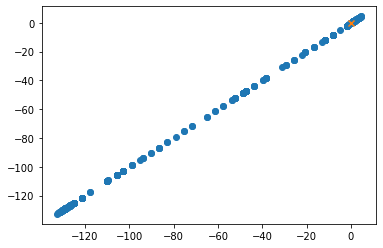

In [94]:
plt.scatter(x_ori,y_ori)
plt.scatter(x_ori[0],y_ori[0],marker='x')

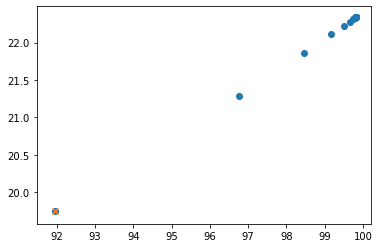

In [95]:
plt.scatter(x_o,y_o)
plt.scatter(x_o[0],y_o[0],marker='x')

In [93]:
x_o

[91.94809,
 96.75369,
 98.45212,
 99.16632,
 99.4951,
 99.65362,
 99.73184,
 99.77091,
 99.790535,
 99.800415,
 99.80541,
 99.80792,
 99.80919,
 99.80983,
 99.81016,
 99.810326,
 99.81041,
 99.810455,
 99.81047,
 99.81048,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.81049,
 99.810